To print variables in Jupyter notebook add this to the environment:

`pip3 install jupyter_contrib_nbextensions`

`jupyter contrib nbextension install --user`

`jupyter nbextension enable python-markdown/main`

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
#assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math 
from scipy import stats
from scipy.stats import norm,hypergeom,gaussian_kde,mannwhitneyu,fisher_exact,ttest_ind,multivariate_normal
from sklearn.mixture import GaussianMixture
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc,mean_squared_error,make_scorer, roc_auc_score, log_loss, accuracy_score, roc_curve, precision_recall_curve
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

# to plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = "Arial"
from matplotlib.colors import LogNorm
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# Set paths
DATASET_PATH = "../Data"
IMAGES_PATH = "../Figures/mousedata"

# Import rpy2 to work with R as well
%load_ext rpy2.ipython

# to make this notebook's output stable across runs
np.random.seed(255)

def image_path(fig_id):
    return os.path.join(IMAGES_PATH, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300,transparent=True)

In [2]:
#import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import isinstalled
from rpy2.rinterface import R_VERSION_BUILD
from rpy2.robjects.vectors import StrVector

print(R_VERSION_BUILD)

# import R's utility package
utils = importr('utils')
# import R's "base" package
importr('base')
# import R's "utils" package
importr('utils')


# select a mirror for R packages
utils.chooseCRANmirror(ind=55) # select the Swiss mirror

# R package names
#packnames = ('mice')
packnames = ('data.table', 'dplyr','knitr','chron','colortools','RColorBrewer','corrplot','geneplotter',
             'lme4','beeswarm','rlang','stargazer','viridis','mclust','ape','dendextend','wordcloud','reshape')




# Selectively install what needs to be install.
def install_import_packages(x):
    if not isinstalled(x):
        print(str(x)+' not installed yet')
        utils.install_packages(str(x))
        importr(x)
    else:
        print(str(x)+' already installed')
        importr(x)
 
        
for x in packnames:
    install_import_packages(x)

    
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()




('3', '3.3', '', 72310)
data.table already installed
dplyr already installed
knitr already installed
chron already installed
colortools already installed
RColorBrewer already installed
corrplot already installed
geneplotter already installed
lme4 already installed
beeswarm already installed
rlang already installed
stargazer already installed
viridis already installed
mclust already installed
ape already installed
dendextend already installed
wordcloud already installed
reshape already installed


Some useful functions in `R`

In [3]:
%%R 

#
#NESTED FUNCTIONS
#
#Because there might be several 'nuclei' detected in the slides per object given the 3D conformation of the
#cell and the folding, we need to aggregate all this object in a single one to obtain one measurement per cell                
AggregateData <- function(submat=nucB[which(nucB$uniqueID%in%unique(nucB$uniqueID)[1]),]){
  colmax <- setdiff(colnames(submat)[grep(colnames(submat),pattern="Max")],c("AreaShape_MaxFeretDiameter","AreaShape_MaximumRadius"))
  
  mvals<-c(apply(submat[,which(colnames(submat)%in%as.character(actions$collID)[which(actions$tobesummed)])],2,function(Z)return(sum(Z,na.rm=T))),
           apply(submat[,which(colnames(submat)%in%as.character(actions$collID)[which(actions$toMin)])],2,function(Z)return(min(Z,na.rm=T))),
           apply(submat[,match(colmax,colnames(submat))],2,function(Z)return(max(Z,na.rm=T))),
           unlist(lapply(which(colnames(submat)%in%as.character(actions$collID)[which(actions$tobeaveraged)]),function(IX)return(sum(submat$AreaShape_Area*submat[,IX],na.rm=T)/sum(submat$AreaShape_Area,na.rm=T)))))  
  
  names(mvals) <- colnames(submat)[c(which(colnames(submat)%in%as.character(actions$collID)[which(actions$tobesummed)]),
             which(colnames(submat)%in%as.character(actions$collID)[which(actions$toMin)]),
             match(colmax,colnames(submat)),
             which(colnames(submat)%in%as.character(actions$collID)[which(actions$tobeaveraged)]))]
  out <- submat[1,]
  out[match(names(mvals),names(out))]<-mvals
  
  return(out)
}  

plotProbsCells <- function(mycell="4G9D3"){
    mymat          <- subinfo_full[which(subinfo_full$'imageID'==mycell),c('prob_LR_total','prob_NN_tot','prob_LR_sub','prob_NN_sub')]
    rownames(mymat)<- subinfo_full$cellID[which(subinfo_full$'imageID'==mycell)]
    barplot(as.matrix(t(mymat)),beside=T,las=2,col=c("#2CA02C","#D62728","white","white"),
            border=c("#2CA02C","#D62728","#2CA02C","#D62728"),main=mycell,ylim=c(0,1))
    abline(h=0.5,col='black',lty=2)
}

plotPositionCells <- function(myimage="4G9D3"){
    mycols       <- c('grey','#663399','#669933')
    names(mycols)<-c("CTRL","SOD1","VCP")
    pos_x <- positions_cells$Location_Center_X[which(positions_cells$imageID==myimage)]
    pos_y <- 1024-positions_cells$Location_Center_Y[which(positions_cells$imageID==myimage)]
    cellIDs <- as.character(positions_cells$cellID[which(positions_cells$imageID==myimage)])
    plot(x=pos_x,
         y=pos_y,
        pch=19,cex=2.0,xlim=c(0,1024),ylim=c(0,1024),ylab="",xlab="",
         col=mycols[match(subinfo_full$mutation[match(myimage,subinfo_full$imageID)],names(mycols))],cex.axis=0.7,
        cex.lab=0.7)
    text(x=pos_x+3,y=pos_y+3,labels=cellIDs,cex=0.7)
    
}

plotCells <- function(mycell){
    plotProbsCells(mycell=mycell)
    plotPositionCells(myimage=mycell)
}
                         
                         
plotComponentMice <- function(IX=1,subdat=subdat,subinfo=subinfo){
  layout(matrix(c(1,1,1,2,3,4),byrow = TRUE,ncol=3,nrow=2))
  
  levels(subinfo$animal)<- unlist(lapply(c("CTRL","SOD1","VCP"),function(Z)return(sort(unique(subinfo$animal[which(subinfo$mutation==Z)])))))
  myCols                <- c("white","purple","darkgreen")
  names(myCols)         <- c("CTRL","SOD1","VCP")
  myColanimals          <- myCols[match(as.character(subinfo$mutation[match(levels(subinfo$animal),subinfo$animal)]),names(myCols))]
  
  mylist <- list(TOT=subinfo[,paste("PC",IX,sep="")],
                 CTRL=subinfo[subinfo$mutant=="CTRL",paste("PC",IX,sep="")],
                 MUTANT=subinfo[subinfo$mutant!="CTRL",paste("PC",IX,sep="")])
  
  multidensity(mylist,las=1,col=c("black","grey","red"),lty=c(1,2,2),xlab=paste("PC",IX),lwd=c(2,1,1),main=paste("PC",IX))
  
  boxplot(subinfo[,paste("PC",IX,sep="")]~subinfo$mutant,outline=FALSE,las=1,xlab="",ylab=paste("PC",IX),
          col=c("grey","red"),frame=F)
  beeswarm(subinfo[,paste("PC",IX,sep="")]~subinfo$mutant,outline=FALSE,las=1,xlab="",ylab=paste("PC",IX),
         bg="grey",col="black",frame=F,xaxt="n",add=TRUE,pch=21)
  grid()
  voi1=formatC(test_ALS$Chisquare[IX],format="e",digit=1)
  voi2=formatC(test_ALS$Pvalue[IX],format="e",digit=2)
  voi3=formatC(test_ALS$effect_avg[IX],digit=2)
  voi4=formatC(test_ALS$effect_sd[IX],digit=2)
  mtext(side=3,line=2.5,text=expr(paste("ALS effect by about ",!!voi3, "\u00B1",!!voi4," (sd) ",sep="")),cex=0.7)
  mtext(side=3,line=1,text=expr(paste(chi^2,"(1) = ",!!voi1,", P = ",!!voi2,sep="")),cex=0.7)
  
  
  boxplot(subinfo[,paste("PC",IX,sep="")]~subinfo$mutation,outline=FALSE,las=1,xlab="",ylab=paste("PC",IX),
          col=myCols[match(levels(subinfo$mutation),names(myCols))],frame=F)
  beeswarm(subinfo[,paste("PC",IX,sep="")]~subinfo$mutation,outline=FALSE,las=1,xlab="",ylab=paste("PC",IX),
         bg="grey",col="black",frame=F,xaxt="n",add=TRUE,pch=21)
  grid()
  #abline(lty=2,col="maroon",h=mean(SVD_eset$v[subinfo$mutant=="CTRL",IX]))
  voi1=formatC(test_SOD1$Chisquare[IX],format="e",digit=1)
  voi2=formatC(test_SOD1$Pvalue[IX],format="e",digit=2)
  voi3=formatC(test_SOD1$effect_avg[IX],digit=2)
  voi4=formatC(test_SOD1$effect_sd[IX],digit=2)
  mtext(side=3,line=2.5,text=expr(paste("SOD1 mutation effect by about ",!!voi3, "\u00B1",!!voi4," (sd) ",sep="")),cex=0.7)
  mtext(side=3,line=1,text=expr(paste(chi^2,"(1) = ",!!voi1,", P = ",!!voi2,sep="")),cex=0.7)
  
  
  
  boxplot(subinfo[,paste("PC",IX,sep="")]~subinfo$animal,outline=FALSE,las=1,xlab="",ylab=paste("PC",IX),
          col=myColanimals,frame=F)
  beeswarm(subinfo[,paste("PC",IX,sep="")]~subinfo$animal,outline=FALSE,las=1,xlab="",ylab=paste("PC",IX),
         bg="grey",col="black",frame=F,xaxt="n",add=TRUE,pch=21)
  grid()
  #abline(lty=2,col="maroon",h=mean(SVD_eset$v[subinfo$mutant=="CTRL",IX]))
  voi1=formatC(test_VCP$Chisquare[IX],format="e",digit=1)
  voi2=formatC(test_VCP$Pvalue[IX],format="e",digit=2)
  voi3=formatC(test_VCP$effect_avg[IX],digit=2)
  voi4=formatC(test_VCP$effect_sd[IX],digit=2)
  mtext(side=3,line=2.5,text=expr(paste("VCP mutation effect by about ",!!voi3, "\u00B1",!!voi4," (sd) ",sep="")),cex=0.7)
  mtext(side=3,line=1,text=expr(paste(chi^2,"(1) = ",!!voi1,", P = ",!!voi2,sep="")),cex=0.7)
  
  
  layout(matrix(c(1,2,3,1,4,5),byrow = TRUE,ncol=3,nrow=2))
  coroi<- myCorr[c(names(sort(myCorr[,IX],decreasing=TRUE))[c(1:10)],names(sort(myCorr[,IX],decreasing=FALSE))[rev(c(1:10))]),IX]
  par(mar=c(5,20,1,1))
  pal1 <- colorRampPalette(c("white","pink","red"))
  pal2 <- colorRampPalette(c("white","lightblue","navy"))
  
  barplot(rev(coroi),horiz = TRUE,cex.names=1.0,las=1,col=rev(c(rev(pal1(10)),pal2(10))))
  par(mar=c(4,4,4,1))
  #par(mfrow=c(2,2))
  myCols                <- c("white","purple","darkgreen")
  names(myCols)         <- c("CTRL","SOD1","VCP")
  myColanimals          <- myCols[match(as.character(myinfo$mutation[match(levels(myinfo$animal),myinfo$animal)]),names(myCols))]
  coroi<- myCorr[c(names(sort(myCorr[,IX],decreasing=TRUE))[c(1:2)],
                   names(sort(myCorr[,IX],decreasing=FALSE))[rev(c(1:2))]),IX]
  
  for(myvar in names(coroi)){
    PlotVariableAnimalsp(myvar=myvar,LOG=FALSE,subdat=data,subinfo=myinfo,myCols=myColanimals)
  }  
  

}
     
                                         
                                         
testLogNorm <- function(val){
  if(min(val)<0){
    return(FALSE)
  }
  if(min(val)>=0){
    val  <- val+min(val[val>0])
    valt <- log(val)
    m1   <- lm(quantile(val,probs=seq(0, 1, 0.01))~quantile(rnorm(n=length(val),mean(val),sd(val)),probs=seq(0, 1, 0.01)))
    m2   <- lm(quantile(valt,probs=seq(0, 1, 0.01))~quantile(rnorm(n=length(valt),mean(valt),sd(valt)),probs=seq(0, 1, 0.01)))
    return(-anova(m1)$F[1]+anova(m2)$F[1]>10)
  }
}



PlotVariableAnimalsp <- function(myvar,LOG=FALSE,subdat=data,subinfo=myinfo,myCols=myColanimals){
  par(mar=c(3,4,5,1))
  if(LOG){
     tempdat                <- data.frame(PC=log(subdat[,myvar]),subinfo)
  } else {
     tempdat                <- data.frame(PC=subdat[,myvar],subinfo) 
  }
    

  tempdat                <- tempdat[tempdat$mutation!="VCP",]
  tempdat$mutation       <- factor(as.character(tempdat$mutation))
  tempdat$animal         <- factor(as.character(tempdat$animal))
  tempdat$Lab            <- factor(as.character(tempdat$Lab))

    
  m1.full                <- lmer(PC~1+mutant+(1|animal/Lab), data = tempdat)
  m1.null                <- lmer(PC~1+(1|animal/Lab), data = tempdat)
  tempdat=data.frame(anova(m1.null,m1.full))
  tempdat2=data.frame(coef(summary(m1.full)))
  var_tests=data.frame(c(tempdat['m1.full','Chisq'],tempdat['m1.full','Pr..Chisq.'],tempdat2['mutantMutant','Estimate'],tempdat2['mutantMutant','Std..Error']))
  rownames(var_tests)<-c("Chisquare","Pvalue","effect_avg","effect_sd")

    
  if(LOG){
     tempdat                <- data.frame(PC=log(subdat[,myvar]),subinfo)
  } else {
     tempdat                <- data.frame(PC=subdat[,myvar],subinfo) 
  }
  tempdat                <- tempdat[tempdat$mutation!="SOD1",]
  tempdat$mutation       <- factor(as.character(tempdat$mutation))
  tempdat$animal         <- factor(as.character(tempdat$animal))
  tempdat$Lab            <- factor(as.character(tempdat$Lab))
  
  m1.full                <- lmer(PC~1+mutant+(1|animal/Lab), data = tempdat)
  m1.null                <- lmer(PC~1+(1|animal/Lab), data = tempdat)
  tempdat=data.frame(anova(m1.null,m1.full))
  tempdat2=data.frame(coef(summary(m1.full)))
  var_tests=data.frame(var_tests,c(tempdat['m1.full','Chisq'],tempdat['m1.full','Pr..Chisq.'],tempdat2['mutantMutant','Estimate'],tempdat2['mutantMutant','Std..Error']))
  colnames(var_tests)<-c("SOD1","VCP")
  
  
  boxplot(subdat[,myvar]~subinfo$animal,outline=FALSE,las=1,xlab="",ylab=myvar,col=myCols,frame=F)
  beeswarm(subdat[,myvar]~subinfo$animal,bg="grey",col="black",add=TRUE,pch=21,cex=0.8) 
  grid()
  #abline(lty=2,col="maroon",h=mean(subdat[subinfo$mutant=="CTRL",myvar]))
  voi1=formatC(var_tests["Chisquare","SOD1"],format="e",digit=1)
  voi2=formatC(var_tests["Pvalue","SOD1"],format="e",digit=2)
  voi3=formatC(var_tests["effect_avg","SOD1"],digit=2)
  voi4=formatC(var_tests["effect_sd","SOD1"],digit=2)
  mtext(side=3,line=2,text=expr(paste("SOD1 mutation effect by about ",!!voi3, "\u00B1",!!voi4," (sd) ",sep="")),cex=0.9)
  mtext(side=3,line=1,text=expr(paste(chi^2,"(1) = ",!!voi1,", P = ",!!voi2,sep="")),cex=0.9)
  
  voi1=formatC(var_tests["Chisquare","VCP"],format="e",digit=1)
  voi2=formatC(var_tests["Pvalue","VCP"],format="e",digit=2)
  voi3=formatC(var_tests["effect_avg","VCP"],digit=2)
  voi4=formatC(var_tests["effect_sd","VCP"],digit=2)
  mtext(side=3,line=4,text=expr(paste("VCP mutation effect by about ",!!voi3, "\u00B1",!!voi4," (sd) ",sep="")),cex=0.9)
  mtext(side=3,line=3,text=expr(paste(chi^2,"(1) = ",!!voi1,", P = ",!!voi2,sep="")),cex=0.9)
    
}



PlotVariableAnimals <- function(myvar){
  par(mar=c(3,4,5,1))
  tempdat                <- data.frame(PC=mat[myvar,],subinfo)
  tempdat                <- tempdat[tempdat$mutation!="VCP",]
  tempdat$mutation       <- factor(as.character(tempdat$mutation))
  tempdat$animal         <- factor(as.character(tempdat$animal))
  tempdat$Lab            <- factor(as.character(tempdat$Lab))
  
  m1.full                <- lmer(PC~1+mutant+(1|animal/Lab), data = tempdat)
  m1.null                <- lmer(PC~1+(1|animal/Lab), data = tempdat)
  tempdat=data.frame(anova(m1.null,m1.full))
  tempdat2=data.frame(coef(summary(m1.full)))
  var_tests=data.frame(c(tempdat['m1.full','Chisq'],tempdat['m1.full','Pr..Chisq.'],tempdat2['mutantMutant','Estimate'],tempdat2['mutantMutant','Std..Error']))
  rownames(var_tests)<-c("Chisquare","Pvalue","effect_avg","effect_sd")
  
  tempdat                <- data.frame(PC=mat[myvar,],subinfo)
  tempdat                <- tempdat[tempdat$mutation!="SOD1",]
  tempdat$mutation       <- factor(as.character(tempdat$mutation))
  tempdat$animal         <- factor(as.character(tempdat$animal))
  tempdat$Lab            <- factor(as.character(tempdat$Lab))
  
  m1.full                <- lmer(PC~1+mutant+(1|animal/Lab), data = tempdat)
  m1.null                <- lmer(PC~1+(1|animal/Lab), data = tempdat)
  tempdat=data.frame(anova(m1.null,m1.full))
  tempdat2=data.frame(coef(summary(m1.full)))
  var_tests=data.frame(var_tests,c(tempdat['m1.full','Chisq'],tempdat['m1.full','Pr..Chisq.'],tempdat2['mutantMutant','Estimate'],tempdat2['mutantMutant','Std..Error']))
  colnames(var_tests)<-c("SOD1","VCP")
  
  
  boxplot(mat[myvar,]~subinfo$animal,outline=FALSE,las=1,xlab="",ylab=myvar,col=myColanimals,frame=F)
  grid()
  abline(lty=2,col="maroon",h=mean(mat[myvar,subinfo$mutant=="CTRL"]))
  voi1=formatC(var_tests["Chisquare","SOD1"],format="e",digit=1)
  voi2=formatC(var_tests["Pvalue","SOD1"],format="e",digit=2)
  voi3=formatC(var_tests["effect_avg","SOD1"],digit=2)
  voi4=formatC(var_tests["effect_sd","SOD1"],digit=2)
  mtext(side=3,line=2,text=expr(paste("SOD1 mutation effect by about ",!!voi3, "\u00B1",!!voi4," (sd) ",sep="")),cex=0.7)
  mtext(side=3,line=1,text=expr(paste(chi^2,"(1) = ",!!voi1,", P = ",!!voi2,sep="")),cex=0.7)
  
  voi1=formatC(var_tests["Chisquare","VCP"],format="e",digit=1)
  voi2=formatC(var_tests["Pvalue","VCP"],format="e",digit=2)
  voi3=formatC(var_tests["effect_avg","VCP"],digit=2)
  voi4=formatC(var_tests["effect_sd","VCP"],digit=2)
  mtext(side=3,line=4,text=expr(paste("VCP mutation effect by about ",!!voi3, "\u00B1",!!voi4," (sd) ",sep="")),cex=0.7)
  mtext(side=3,line=3,text=expr(paste(chi^2,"(1) = ",!!voi1,", P = ",!!voi2,sep="")),cex=0.7)
  
  
}

plotRelevanceFeatures <- function(feature_importances,attributes,var1="Intensity_MeanIntensity_FUS_nc_ratios",
                          var2="Intensity_IntegratedIntensity_FUS_nc_rel",mytitle="contribution to LR",prot="FUS"){

    tempvar       <-feature_importances
    names(tempvar)<- attributes
    tempvar       <- sort(tempvar)
    tempcol       <- rep(rgb(0,0,0,0.2),length(tempvar))
    tempcol[names(tempvar)==var1]<-"green"
    tempcol[names(tempvar)==var2]<-"blue"
    tempw        <- rep(0.2,length(tempvar))
    tempw[names(tempvar)==var1]<-2.0
    tempw[names(tempvar)==var2]<-2.0


    par(mfrow=c(1,3))
    boxplot(tempvar,las=1,pch=19)
    mtext(side=2,line=3,text=mytitle)


    barplot(height=tempvar,width=tempw,col=tempcol,names.arg="",border=NA,las=1)
    grid()
    mtext(side=2,line=3,text="contribution to LR")
    legend("top",ncol=2,pch=15,col=c("green","blue"),leg=c("SFPQ N/C","FUS N/C"),cex=1.0)

    tempvar       <-abs(feature_importances)
    names(tempvar)<- attributes
    tempvar       <- sort(tempvar)
    tempcol       <- rep(rgb(0,0,0,0.2),length(tempvar))
    tempcol[names(tempvar)==var1]<-"green"
    tempcol[names(tempvar)==var2]<-"blue"
    tempw        <- rep(0.2,length(tempvar))
    tempw[names(tempvar)==var1]<-2.0
    tempw[names(tempvar)==var2]<-2.0


    barplot(height=tempvar,width=tempw,col=tempcol,names.arg="",border=NA,las=1)
    grid()
    mtext(side=2,line=3,text=paste("|",mytitle,"|"))
}  

#When using mclust to extract bimodal distribution to assign postprob to each measurements to belong to debris or true feature                     
plotMclust <- function(mydata=mydat[[1]],mybim=bimdens[[1]],myLim=log2(Lim[1]),myname=names(Lim)[1],mytitle="TPM"){
  x  <- seq(from=min(mydata), to=max(mydata),length=100)
  if(length(mybim$parameters$variance$sigmasq)>1){
    hx1 <- dnorm(x,mean=mybim$parameters$mean[1],sd=sqrt(mybim$parameters$variance$sigmasq[1]))
    hx2 <- dnorm(x,mean=mybim$parameters$mean[2],sd=sqrt(mybim$parameters$variance$sigmasq[2]))
    hist(mydata,breaks=100,col=rgb(0,0,0,alpha=0.2),freq=FALSE,ylim=c(0,max(c(hx1,hx2))),xlab="",ylab="",main="",xaxt="n",las=1)
    lines(x,hx2 , lwd=2, col="blue")
    lines(x,hx1 , lwd=2, col="red")
    abline(v=myLim,lty=2,col="red")
    mtext(side=2,line=2,text="density",cex=1.0)
    mtext(side=1,line=3,text=myname,cex=1.0)
    #Plot nice log-log axes
    full=c("1","2","4","8","16","32","64","128","256")
    y1   <- range(x)
    pow  <- seq(y1[1], y1[2]+1)
    ticksaty <- as.vector(sapply(pow, function(p) (1:10)*10^p))
    laby <- replicate(length(ticksaty),"")
    idy = match(as.numeric(full),ticksaty)
    idy = idy[!is.na(idy)]
    laby[idy]<-full[c(1:length(match(as.numeric(full),ticksaty)))]
    axis(side=1, at=ticksaty, labels=TRUE, tcl=-0.25, lwd=0, lwd.ticks=0.5,cex=0.8)
  }
  if(length(mybim$parameters$variance$sigmasq)==1){
    hx1 <- dnorm(x,mean=mybim$parameters$mean[1],sd=sqrt(mybim$parameters$variance$sigmasq[1]))
    hx2 <- dnorm(x,mean=mybim$parameters$mean[2],sd=sqrt(mybim$parameters$variance$sigmasq[1]))
    hist(mydata,breaks=100,col=rgb(0,0,0,alpha=0.2),freq=FALSE,ylim=c(0,max(c(hx1,hx2))),xlab="",ylab="",main="",xaxt="n",las=1)
    lines(x,hx2 , lwd=2, col="blue")
    lines(x,hx1 , lwd=2, col="red")
    abline(v=myLim,lty=2,col="red")
    mtext(side=2,line=2,text="density",cex=1.0)
    mtext(side=1,line=3,text=myname,cex=1.0)
    #Plot nice log-log axes
    full=c("1","2","4","8","16","32","64","128","256")
    y1   <- range(x)
    pow  <- seq(y1[1], y1[2]+1)
    ticksaty <- as.vector(sapply(pow, function(p) (1:10)*10^p))
    laby <- replicate(length(ticksaty),"")
    idy = match(as.numeric(full),ticksaty)
    idy = idy[!is.na(idy)]
    laby[idy]<-full[c(1:length(match(as.numeric(full),ticksaty)))]
    axis(side=1, at=ticksaty, labels=TRUE, tcl=-0.25, lwd=0, lwd.ticks=0.5,cex=0.8)
  }
}

Some useful functions in `Python`.


In [4]:
def GMM_analysis_mouse_automated(AB,df_sfpqm,myvar,ix_mu,ix_ct,limangle,fst,batch,title,colCT,colALS,Plot):
    random_state = np.random.RandomState(seed=1)
    coldens=['darkgreen', 'maroon'];
    df_sfpqm['ID']=df_sfpqm['mutation']+'-'+df_sfpqm['ID'];

    datoi=(df_sfpqm[myvar],
       df_sfpqm.groupby('mutation')[myvar].get_group('CTRL'),
       df_sfpqm.groupby('mutation')[myvar].get_group('VCP'),
       df_sfpqm.groupby('mutation')[myvar].get_group('SOD1'));
    
    myX=df_sfpqm[myvar].values.reshape(-1,1);
    gm = GaussianMixture(n_components=2,  n_init=20,covariance_type='full',init_params='kmeans')
    gm.fit(myX)
    min_max_idx = [np.argmin(gm.means_),np.argmax(gm.means_)];
    mu_idx = min_max_idx[ix_mu];
    ctrl_idx = min_max_idx[ix_ct];
    
    x = np.linspace(myX.min(), myX.max(), 1000)
    logprob = gm.score_samples(x.reshape(-1, 1))
    responsibilities = gm.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    df_sfpqm['posterior_probability']=gm.predict_proba(myX)[:,ctrl_idx];
    df_sfpqm['severity']=-np.log10(gm.predict_proba(myX)[:,ctrl_idx]);
    
    
    dft=df_sfpqm.sort_values(by='severity',ascending=True)
    dft=dft.loc[np.diff(dft['severity'])>0]
    xs=np.array(dft['severity'])
    mymax=np.max(xs)
    xs=xs/mymax
    ys=np.array(dft['posterior_probability'])
    ysg = gaussian_filter(ys, sigma=0.1)
    angles=np.degrees(np.arctan(ysg/xs))
    idx=np.argmax((angles<=limangle) & (angles>0))
    xs=xs*mymax
    severity_lim=dft.iloc[idx]['severity'];
    lowerbound=dft.iloc[idx]['posterior_probability'];
    limpc5=dft.iloc[idx][myvar];
    
    df_sfpqm['test']=df_sfpqm['posterior_probability']<lowerbound
    d = {'fraction':100*df_sfpqm.groupby(['ID'])['test'].apply(sum)/df_sfpqm.groupby(['ID'])['test'].apply(len),
        'avg_prob':1-df_sfpqm.groupby(['ID'])['posterior_probability'].mean()}

    summary_pc = pd.DataFrame(d)
    summary_pc['ntot']=0
    summary_pc['nsick']=0
    summary_pc['severity_global']=0
    summary_pc['severity_focus']=0
    summary_pc['ncr_global']=0
    summary_pc['ncr_focus']=0
    summary_pc['zscore_global']=0
    summary_pc['zscore_focus']=0
    summary_pc['htest']=0
    summary_pc['Shannon']=0
    summary_pc['probability_sick']=0
    summary_pc['like_sick']=0
    mytemp = df_sfpqm.drop_duplicates('ID')
    mytemp.index=mytemp['ID']
    summary_pc['mutation']=mytemp['mutation']

    avg_healthy=df_sfpqm.loc[df_sfpqm['posterior_probability']>lowerbound,myvar].mean()
    std_healthy=df_sfpqm.loc[df_sfpqm['posterior_probability']>lowerbound,myvar].std()
    
    for myid in df_sfpqm['ID'].unique():
        summary_pc.loc[myid,'ntot']=df_sfpqm.loc[(df_sfpqm['ID']==myid)].shape[0]
        summary_pc.loc[myid,'nsick']=df_sfpqm.loc[(df_sfpqm['ID']==myid)&(df_sfpqm['posterior_probability']<lowerbound)].shape[0]
        summary_pc.loc[myid,'severity_focus']=df_sfpqm.loc[(df_sfpqm['ID']==myid)&(df_sfpqm['posterior_probability']<lowerbound),
                                                          'severity'].mean()
        summary_pc.loc[myid,'ncr_focus']=df_sfpqm.loc[(df_sfpqm['ID']==myid)&(df_sfpqm['posterior_probability']<lowerbound),
                                                          myvar].mean()

        summary_pc.loc[myid,'severity_global']=df_sfpqm.loc[df_sfpqm['ID']==myid,'severity'].mean()
        summary_pc.loc[myid,'ncr_global']=df_sfpqm.loc[df_sfpqm['ID']==myid,myvar].mean()
        summary_pc.loc[myid,'zscore_focus']=(summary_pc.loc[myid,'ncr_focus']-avg_healthy)/np.sqrt(df_sfpqm.loc[(df_sfpqm['ID']==myid)&(df_sfpqm['posterior_probability']<lowerbound),
                                                          myvar].std()**2+std_healthy**2)

        summary_pc.loc[myid,'zscore_global']=(summary_pc.loc[myid,'ncr_global']-avg_healthy)/np.sqrt(df_sfpqm.loc[df_sfpqm['ID']==myid,myvar].std()**2+std_healthy**2)
        summary_pc.loc[myid,'Shannon']=(-sum(df_sfpqm.loc[df_sfpqm['ID']==myid,'posterior_probability']*np.log(df_sfpqm.loc[df_sfpqm['ID']==myid,'posterior_probability'])))

        like_ctrl=stats.norm.pdf(x=df_sfpqm.loc[df_sfpqm['ID']==myid,myvar], loc=gm.means_[ctrl_idx], scale=math.sqrt(gm.covariances_[ctrl_idx])).prod()
        like_mu=stats.norm.pdf(x=df_sfpqm.loc[df_sfpqm['ID']==myid,myvar], loc=gm.means_[mu_idx], scale=math.sqrt(gm.covariances_[mu_idx])).prod()

        summary_pc.loc[myid,'probability_sick']=like_mu/(like_mu+like_ctrl)
        summary_pc.loc[myid,'like_sick']=-np.log10(like_mu)

        M=summary_pc.loc[summary_pc['mutation']=='CTRL','ntot'].sum()+summary_pc.loc[myid,'ntot']
        n=summary_pc.loc[summary_pc['mutation']=='CTRL','nsick'].sum()+summary_pc.loc[myid,'nsick']
        N=summary_pc.loc[myid,'ntot']
        X=summary_pc.loc[myid,'nsick']-1
        summary_pc.loc[myid,'htest']=hypergeom.sf(X, M, n, N)
    summary_pc.sort_values(by=['mutation'],inplace=True)

    

    x = np.linspace(myX.min().round(), myX.max().round(), 1000)
    temp=pd.DataFrame({'name':df_sfpqm['ID'].unique()})
    g1=np.array(temp.loc[['CTRL' in i for i in temp['name']],'name'])
    g2=np.array(temp.loc[['VCP' in i for i in temp['name']],'name'])
    g3=np.array(temp.loc[['SOD' in i for i in temp['name']],'name'])
    myorder=np.append(np.append(g1,g3),g2)
    temp=pd.DataFrame({'name':myorder})
    temp['color']='grey'
    temp.loc[['VCP' in i for i in temp['name']],'color']='#669933'
    temp.loc[['SOD' in i for i in temp['name']],'color']='#663399'
    colorsbx=temp['color']

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
    st = fig.suptitle(title, fontsize=16,fontweight='bold')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)


    plt.subplot(2,4,1)
    colors = ['grey','#669933','#663399']
    names = ['CTRL', 'VCP','SOD1']
    x1=df_sfpqm.groupby(['mutation'])[myvar].get_group(('CTRL'));
    x2=df_sfpqm.groupby(['mutation'])[myvar].get_group(('VCP'));
    x3=df_sfpqm.groupby(['mutation'])[myvar].get_group(('SOD1'));

    plt.hist([x1, x2,x3], bins = 25, normed=True,color = ['orange','#669933','#663399'], label=names,alpha=0.5);
    density = gaussian_kde(datoi[0])
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(x,density(x),'k', color = 'black',linewidth=2.5,label='data')
    colors = coldens
    for i, color in enumerate(colors, start=0):
        plt.plot(x, pdf_individual[:,i],'--k', color=color,linewidth=2.0)
    plt.grid(color='grey', linestyle=':', linewidth=1)
    plt.title( "Gaussian mixture modeling")
    plt.xlabel(AB+' N/C protein [log]',fontsize=12)
    plt.ylabel('$p(x)$')
    plt.legend(loc='best')
    plt.axvline(x=limpc5,ls='--', color='maroon',linewidth=1.5)
    
    
    plt.subplot(2,4,2)
    plt.plot(xs, ys, '.')
    plt.plot(xs, ysg, '-')
    plt.grid(True,color='grey', linestyle=':', linewidth=1)
    plt.xlabel('-log10(P)',fontsize=12)
    plt.ylabel('probability P to be healthy',fontsize=12)
    plt.axvline(severity_lim,ls='--', color='rosybrown',linewidth=1.5)
    plt.axhline(lowerbound,ls='--', color='maroon',linewidth=1.5)
 
    plt.subplot(2,4,3)    
    colors=['grey','#663399','#669933'] 
    bplot1 = sns.boxplot(y='avg_prob', x='mutation', data=summary_pc, width=0.5,order=['CTRL','SOD1','VCP'],palette=colors,showfliers=False)
    bplot1 = sns.swarmplot(y='avg_prob', x='mutation', data=summary_pc, color="black",  size=8)
    plt.grid(True,color='grey', linestyle=':', linewidth=1)
    plt.ylabel('average probability',fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('') 
    welch_vcp=ttest_ind(a=summary_pc.groupby('mutation')['avg_prob'].get_group('CTRL'),
                    b=summary_pc.groupby('mutation')['avg_prob'].get_group('VCP'),equal_var=False).pvalue/2
    welch_sod1=ttest_ind(a=summary_pc.groupby('mutation')['avg_prob'].get_group('CTRL'),
                    b=summary_pc.groupby('mutation')['avg_prob'].get_group('SOD1'),equal_var=False).pvalue/2

    plt.title( "P-value(Welsch test SOD1)="+str('%.2E' % welch_sod1)+"\nP-value(Welsch test VCP)="+str('%.2E' % welch_vcp))

      
    plt.subplot(2,4,4)
    myloc=np.arange(1,summary_pc.shape[0]+1)
    plt.barh(myloc,summary_pc['fraction'],color=colorsbx)
    plt.xlim(0,100)
    plt.grid()
    plt.xlabel('% of sick cells',fontsize=12)
    plt.yticks([r + 1 for r in range(summary_pc.shape[0])], summary_pc.index,fontsize=fst)
    plt.ylabel('')
    
    plt.subplot(2,4,5)
    bplot1 = sns.violinplot(y=myvar, x='mutation', data=df_sfpqm, width=0.5,order=['CTRL','SOD1','VCP'],showfliers=False,
                    palette=['grey','#663399','#669933'])
    bplot1 = sns.swarmplot(y=myvar, x='mutation', data=df_sfpqm, color="black",order=['CTRL','SOD1','VCP'],  size=3)
    plt.grid(True,color='grey', linestyle=':', linewidth=1)
    plt.ylabel(AB+' N/C ratio [log]',fontsize=12)
    #plt.title( "P-value(MW)="+str('%.2E' % mannwhitneyu(x=dfc.groupby('mutation')['ratiosl'].get_group('CTRL'),
    #                 y=dfc.groupby('mutation')['ratiosl'].get_group('sALS'))[1]))
    plt.xlabel('') 
    
    plt.subplot(2,4,6)
    bplot1 = sns.boxplot(y=myvar, x='ID', data=df_sfpqm, width=0.5,palette=colorsbx,showfliers=False,
                     order=myorder)
    bplot1 = sns.swarmplot(y=myvar, x='ID', data=df_sfpqm, color="black",  size=3,order=myorder)
    plt.grid(True,color='grey', linestyle=':', linewidth=1)
    plt.ylabel(AB+' N/C ratio [log]',fontsize=12)
    plt.xlabel('')
    plt.xticks(fontsize=fst,rotation=-45)
    plt.axhline(y=limpc5,ls='--', color='maroon',linewidth=1.5)

    plt.subplot(2,4,7)
    bplot1 = sns.boxplot(y='posterior_probability', x='mutation', data=df_sfpqm, width=0.5,order=['CTRL','SOD1','VCP'],showfliers=False,
                    palette=['grey','#663399','#669933'])
    plt.grid(True,color='grey', linestyle=':', linewidth=1)
    plt.ylabel('Posterior probability P\n to be healthy',fontsize=12)
    plt.ylim(top=1.1)
    plt.xlabel('')

    plt.subplot(2,4,8)  
    bplot1 = sns.boxplot(y='posterior_probability', x='ID', data=df_sfpqm, width=0.5,
                     palette=colorsbx,showfliers=False,
                     order=myorder)
    plt.grid(True,color='grey', linestyle=':', linewidth=1)
    plt.ylabel('Posterior probability P\n to be healthy',fontsize=12)
    plt.xlabel('')
    plt.xticks(fontsize=fst,rotation=-45)
    plt.axhline(y=lowerbound,ls='--', color='maroon',linewidth=1.5)

    return df_sfpqm,limpc5,summary_pc,df_sfpqm['test'],df_sfpqm['posterior_probability']
    
  

In [5]:
def GMM_analysis_mouse_automated_mv(AB,df_sfpqm,myvar,limangle,fst,batch,title,Plot):
    random_state = np.random.RandomState(seed=1)
    coldens=['darkgreen', 'maroon'];
    df_sfpqm['ID']=df_sfpqm['mutation']+'-'+df_sfpqm['ID'];
    
    col_CTRL='grey'
    col_SOD1='#663399'
    col_VCP='#669933'
    
    temp=pd.DataFrame({'name':df_sfpqm['ID'].unique()})
    g1=np.array(temp.loc[['CTRL' in i for i in temp['name']],'name'])
    g2=np.array(temp.loc[['VCP' in i for i in temp['name']],'name'])
    g3=np.array(temp.loc[['SOD' in i for i in temp['name']],'name'])
    myorder=np.append(np.append(g1,g3),g2)
    temp=pd.DataFrame({'name':myorder})
    temp['color']=col_CTRL
    temp.loc[['VCP' in i for i in temp['name']],'color']=col_VCP
    temp.loc[['SOD' in i for i in temp['name']],'color']=col_SOD1
    colorsbx=temp['color']

    
    datoi=(df_sfpqm[myvar],
       df_sfpqm.groupby('mutation')[myvar].get_group('CTRL'),
       df_sfpqm.groupby('mutation')[myvar].get_group('VCP'),
       df_sfpqm.groupby('mutation')[myvar].get_group('SOD1'));
    
    myX=df_sfpqm[myvar].to_numpy();
    gm = GaussianMixture(n_components=2,  n_init=20,covariance_type='full',init_params='kmeans')
    gm.fit(myX)
    
    df_sfpqm['p1']=gm.predict_proba(myX)[:,0]
    if np.argmax(df_sfpqm.groupby(['mutation'])['p1'].mean())=='VCP':
        mu_idx=0;
        ctrl_idx=1;
    else:
        mu_idx=1;
        ctrl_idx=0;
        
    df_sfpqm['posterior_probability']=gm.predict_proba(myX)[:,ctrl_idx];
    df_sfpqm['severity']=-np.log10(gm.predict_proba(myX)[:,ctrl_idx]);
       
    dft=df_sfpqm.sort_values(by='severity',ascending=True)
    dft=df_sfpqm.loc[np.diff(dft['severity'])>0]    
    
    xs=np.array(dft['severity'])
    mymax=np.max(xs)
    xs=xs/mymax
    ys=np.array(dft['posterior_probability'])
    ysg = gaussian_filter(ys, sigma=0.1)
    angles=np.degrees(np.arctan(ysg/xs))
    idx=np.argmax((angles<=limangle) & (angles>0))
    xs=xs*mymax
    severity_lim=dft.iloc[idx]['severity'];
    lowerbound=dft.iloc[idx]['posterior_probability'];
    limpc5=dft.iloc[idx][myvar];
    
    
    df_sfpqm['test']=df_sfpqm['posterior_probability']<lowerbound
    d = {'fraction':100*df_sfpqm.groupby(['ID'])['test'].apply(sum)/df_sfpqm.groupby(['ID'])['test'].apply(len),
        'avg_prob':1-df_sfpqm.groupby(['ID'])['posterior_probability'].mean()}

    summary_pc = pd.DataFrame(d)
    summary_pc['ntot']=0
    summary_pc['nsick']=0
    summary_pc['severity_global']=0
    summary_pc['severity_focus']=0
    summary_pc['ncr_global']=0
    summary_pc['ncr_focus']=0
    summary_pc['htest']=0
    summary_pc['Shannon']=0
    summary_pc['probability_sick']=0
    summary_pc['like_sick']=0
    mytemp = df_sfpqm.drop_duplicates('ID')
    mytemp.index=mytemp['ID']
    summary_pc['mutation']=mytemp['mutation']    
    
    for myid in df_sfpqm['ID'].unique():   
        summary_pc.loc[myid,'ntot']=df_sfpqm.loc[(df_sfpqm['ID']==myid)].shape[0]
        summary_pc.loc[myid,'nsick']=df_sfpqm.loc[(df_sfpqm['ID']==myid)&(df_sfpqm['posterior_probability']<lowerbound)].shape[0]
        summary_pc.loc[myid,'severity_focus']=df_sfpqm.loc[(df_sfpqm['ID']==myid)&(df_sfpqm['posterior_probability']<lowerbound),
                                                          'severity'].mean()
        summary_pc.loc[myid,'severity_global']=df_sfpqm.loc[df_sfpqm['ID']==myid,'severity'].mean()
        summary_pc.loc[myid,'Shannon']=(-sum(df_sfpqm.loc[df_sfpqm['ID']==myid,'posterior_probability']*np.log(df_sfpqm.loc[df_sfpqm['ID']==myid,'posterior_probability'])))

        var=multivariate_normal(gm.means_[mu_idx], cov=gm.covariances_[mu_idx])
        like_mu=var.pdf(df_sfpqm.loc[df_sfpqm['ID']==myid,myvar]).prod()
        var=multivariate_normal(gm.means_[ctrl_idx], cov=gm.covariances_[ctrl_idx])
        like_ctrl=var.pdf(df_sfpqm.loc[df_sfpqm['ID']==myid,myvar]).prod()
        summary_pc.loc[myid,'probability_sick']=like_mu/(like_mu+like_ctrl)
        summary_pc.loc[myid,'like_sick']=np.log10(like_mu)
        M=summary_pc.loc[summary_pc['mutation']=='CTRL','ntot'].sum()+summary_pc.loc[myid,'ntot']
        n=summary_pc.loc[summary_pc['mutation']=='CTRL','nsick'].sum()+summary_pc.loc[myid,'nsick']
        N=summary_pc.loc[myid,'ntot']
        X=summary_pc.loc[myid,'nsick']-1
        summary_pc.loc[myid,'htest']=hypergeom.sf(X, M, n, N)
        
    summary_pc.sort_values(by=['mutation'],inplace=True)

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
    st = fig.suptitle(title, fontsize="x-large")
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)

    plt.subplot(1,4,1)
    x1 = np.linspace(myX.min(axis=0)[0], myX.max(axis=0)[0], 1000)
    x2 = np.linspace(myX.min(axis=0)[1], myX.max(axis=0)[1], 1000)
    X1,X2 = np.meshgrid(x1, x2)
    XX = np.array([X1.ravel(), X2.ravel()]).T
    logprob = gm.score_samples(XX)
    responsibilities = gm.predict_proba(XX)
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    Z = -gm.score_samples(XX)
    Z = Z.reshape(X1.shape)
    CS = plt.contour(X1, X2, Z, norm=LogNorm(vmin=0.1, vmax=100.0),levels=np.logspace(-100, 100, 2500),alph=0.5)
    plt.scatter(myX[subinfo['mutation']=='VCP', 0], myX[subinfo['mutation']=='VCP', 1], 20.0,color=col_VCP)
    plt.scatter(myX[subinfo['mutation']=='CTRL', 0], myX[subinfo['mutation']=='CTRL', 1], 20.0,color=col_CTRL)
    plt.scatter(myX[subinfo['mutation']=='SOD1', 0], myX[subinfo['mutation']=='SOD1', 1], 20.0,color=col_SOD1)
    plt.xlabel(myvar[0],fontsize=12)
    plt.ylabel(myvar[1],fontsize=12)

    plt.subplot(1,4,2)
    bplot1 = sns.boxplot(y='posterior_probability', x='mutation', data=df_sfpqm, width=0.5,order=['CTRL','SOD1','VCP'],showfliers=False,
                    palette=['grey','#663399','#669933'])
    plt.grid(True,color='grey', linestyle=':', linewidth=1)
    plt.ylabel('Posterior probability P\n to be healthy',fontsize=12)
    plt.ylim(top=1.1)
    plt.xlabel('')
    plt.axhline(y=lowerbound,ls='--', color='maroon',linewidth=1.5)
    plt.xticks(fontsize=fst,rotation=45)

    plt.subplot(1,4,3) 
    myloc=np.arange(1,summary_pc.shape[0]+1)
    plt.barh(myloc,summary_pc['fraction'],color=colorsbx)
    plt.xlim(0,100)
    plt.grid()
    plt.xlabel('% of sick cells',fontsize=12)
    plt.yticks([r + 1 for r in range(summary_pc.shape[0])], summary_pc.index,fontsize=fst)
    plt.ylabel('')
    
    plt.subplot(1,4,4)
    colors=['grey','#663399','#669933'] 
    bplot1 = sns.boxplot(y='avg_prob', x='mutation', data=summary_pc, width=0.5,order=['CTRL','SOD1','VCP'],palette=colors,showfliers=False)
    bplot1 = sns.swarmplot(y='avg_prob', x='mutation', data=summary_pc, color="black",  size=8)
    plt.grid(True,color='grey', linestyle=':', linewidth=1)
    plt.ylabel('average probability',fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('') 
    welch_vcp=ttest_ind(a=summary_pc.groupby('mutation')['avg_prob'].get_group('CTRL'),
                    b=summary_pc.groupby('mutation')['avg_prob'].get_group('VCP'),equal_var=False).pvalue/2
    welch_sod1=ttest_ind(a=summary_pc.groupby('mutation')['avg_prob'].get_group('CTRL'),
                    b=summary_pc.groupby('mutation')['avg_prob'].get_group('SOD1'),equal_var=False).pvalue/2

    plt.title( "P-value(Welsch test SOD1)="+str('%.2E' % welch_sod1)+"\nP-value(Welsch test VCP)="+str('%.2E' % welch_vcp))
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
                                  
    return df_sfpqm,limpc5,summary_pc,df_sfpqm['test'],df_sfpqm['posterior_probability']
    


In [6]:
def GMM_analysis_mouse_automated_focus(AB,df_sfpqm,myvar,limangle,fst,batch,title,Plot):
    random_state = np.random.RandomState(seed=1)
    coldens=['darkgreen', 'maroon'];
    df_sfpqm['ID']=df_sfpqm['mutation']+'-'+df_sfpqm['ID'];
    
    col_CTRL='grey'
    col_SOD1='#663399'
    col_VCP='#669933'
    
    temp=pd.DataFrame({'name':df_sfpqm['ID'].unique()})
    g1=np.array(temp.loc[['CTRL' in i for i in temp['name']],'name'])
    g2=np.array(temp.loc[['VCP' in i for i in temp['name']],'name'])
    g3=np.array(temp.loc[['SOD' in i for i in temp['name']],'name'])
    myorder=np.append(np.append(g1,g3),g2)
    temp=pd.DataFrame({'name':myorder})
    temp['color']=col_CTRL
    temp.loc[['VCP' in i for i in temp['name']],'color']=col_VCP
    temp.loc[['SOD' in i for i in temp['name']],'color']=col_SOD1
    colorsbx=temp['color']

    
    datoi=(df_sfpqm[myvar],
       df_sfpqm.groupby('mutation')[myvar].get_group('CTRL'),
       df_sfpqm.groupby('mutation')[myvar].get_group('VCP'),
       df_sfpqm.groupby('mutation')[myvar].get_group('SOD1'));
    
    myX=df_sfpqm[myvar].to_numpy();
    gm = GaussianMixture(n_components=2,  n_init=20,covariance_type='full',init_params='kmeans')
    gm.fit(myX)
    
    df_sfpqm['p1']=gm.predict_proba(myX)[:,0]
    if np.argmax(df_sfpqm.groupby(['mutation'])['p1'].mean())=='VCP':
        mu_idx=0;
        ctrl_idx=1;
    else:
        mu_idx=1;
        ctrl_idx=0;
        
    df_sfpqm['posterior_probability']=gm.predict_proba(myX)[:,ctrl_idx];
    df_sfpqm['severity']=-np.log10(gm.predict_proba(myX)[:,ctrl_idx]);
       
    dft=df_sfpqm.sort_values(by='severity',ascending=True)
    dft=df_sfpqm.loc[np.diff(dft['severity'])>0]    
    
    xs=np.array(dft['severity'])
    mymax=np.max(xs)
    xs=xs/mymax
    ys=np.array(dft['posterior_probability'])
    ysg = gaussian_filter(ys, sigma=0.1)
    angles=np.degrees(np.arctan(ysg/xs))
    idx=np.argmax((angles<=limangle) & (angles>0))
    xs=xs*mymax
    severity_lim=dft.iloc[idx]['severity'];
    lowerbound=dft.iloc[idx]['posterior_probability'];
    limpc5=dft.iloc[idx][myvar];
    
    
    df_sfpqm['test']=df_sfpqm['posterior_probability']<lowerbound
    d = {'fraction':100*df_sfpqm.groupby(['ID'])['test'].apply(sum)/df_sfpqm.groupby(['ID'])['test'].apply(len),
        'avg_prob':1-df_sfpqm.groupby(['ID'])['posterior_probability'].mean()}

    summary_pc = pd.DataFrame(d)
    summary_pc['ntot']=0
    summary_pc['nsick']=0
    summary_pc['severity_global']=0
    summary_pc['severity_focus']=0
    summary_pc['ncr_global']=0
    summary_pc['ncr_focus']=0
    summary_pc['htest']=0
    summary_pc['Shannon']=0
    summary_pc['probability_sick']=0
    summary_pc['like_sick']=0
    mytemp = df_sfpqm.drop_duplicates('ID')
    mytemp.index=mytemp['ID']
    summary_pc['mutation']=mytemp['mutation']    
    
    for myid in df_sfpqm['ID'].unique():   
        summary_pc.loc[myid,'ntot']=df_sfpqm.loc[(df_sfpqm['ID']==myid)].shape[0]
        summary_pc.loc[myid,'nsick']=df_sfpqm.loc[(df_sfpqm['ID']==myid)&(df_sfpqm['posterior_probability']<lowerbound)].shape[0]
        summary_pc.loc[myid,'severity_focus']=df_sfpqm.loc[(df_sfpqm['ID']==myid)&(df_sfpqm['posterior_probability']<lowerbound),
                                                          'severity'].mean()
        summary_pc.loc[myid,'severity_global']=df_sfpqm.loc[df_sfpqm['ID']==myid,'severity'].mean()
        summary_pc.loc[myid,'Shannon']=(-sum(df_sfpqm.loc[df_sfpqm['ID']==myid,'posterior_probability']*np.log(df_sfpqm.loc[df_sfpqm['ID']==myid,'posterior_probability'])))

        var=multivariate_normal(gm.means_[mu_idx], cov=gm.covariances_[mu_idx])
        like_mu=var.pdf(df_sfpqm.loc[df_sfpqm['ID']==myid,myvar]).prod()
        var=multivariate_normal(gm.means_[ctrl_idx], cov=gm.covariances_[ctrl_idx])
        like_ctrl=var.pdf(df_sfpqm.loc[df_sfpqm['ID']==myid,myvar]).prod()
        summary_pc.loc[myid,'probability_sick']=like_mu/(like_mu+like_ctrl)
        summary_pc.loc[myid,'like_sick']=np.log10(like_mu)
        M=summary_pc.loc[summary_pc['mutation']=='CTRL','ntot'].sum()+summary_pc.loc[myid,'ntot']
        n=summary_pc.loc[summary_pc['mutation']=='CTRL','nsick'].sum()+summary_pc.loc[myid,'nsick']
        N=summary_pc.loc[myid,'ntot']
        X=summary_pc.loc[myid,'nsick']-1
        summary_pc.loc[myid,'htest']=hypergeom.sf(X, M, n, N)
        
    summary_pc.sort_values(by=['mutation'],inplace=True)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
    st = fig.suptitle(title, fontsize="x-large")
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)


    plt.subplot(1,3,1)
    bplot1 = sns.boxplot(y='posterior_probability', x='mutation', data=df_sfpqm, width=0.5,order=['CTRL','SOD1','VCP'],showfliers=False,
                    palette=['grey','#663399','#669933'])
    plt.grid(True,color='grey', linestyle=':', linewidth=1)
    plt.ylabel('Posterior probability P\n to be healthy',fontsize=12)
    plt.ylim(top=1.1)
    plt.xlabel('')
    plt.axhline(y=lowerbound,ls='--', color='maroon',linewidth=1.5)
    plt.xticks(fontsize=fst,rotation=45)

    plt.subplot(1,3,2) 
    myloc=np.arange(1,summary_pc.shape[0]+1)
    plt.barh(myloc,summary_pc['fraction'],color=colorsbx)
    plt.xlim(0,100)
    plt.grid()
    plt.xlabel('% of sick cells',fontsize=12)
    plt.yticks([r + 1 for r in range(summary_pc.shape[0])], summary_pc.index,fontsize=fst)
    plt.ylabel('')
    
    plt.subplot(1,3,3)
    colors=['grey','#663399','#669933'] 
    bplot1 = sns.boxplot(y='avg_prob', x='mutation', data=summary_pc, width=0.5,order=['CTRL','SOD1','VCP'],palette=colors,showfliers=False)
    bplot1 = sns.swarmplot(y='avg_prob', x='mutation', data=summary_pc, color="black",  size=8)
    plt.grid(True,color='grey', linestyle=':', linewidth=1)
    plt.ylabel('average probability',fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('') 
    welch_vcp=ttest_ind(a=summary_pc.groupby('mutation')['avg_prob'].get_group('CTRL'),
                    b=summary_pc.groupby('mutation')['avg_prob'].get_group('VCP'),equal_var=False).pvalue/2
    welch_sod1=ttest_ind(a=summary_pc.groupby('mutation')['avg_prob'].get_group('CTRL'),
                    b=summary_pc.groupby('mutation')['avg_prob'].get_group('SOD1'),equal_var=False).pvalue/2

    plt.title( "P-value(Welsch test SOD1)="+str('%.2E' % welch_sod1)+"\nP-value(Welsch test VCP)="+str('%.2E' % welch_vcp))
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
                                  
    return df_sfpqm,limpc5,summary_pc,df_sfpqm['test'],df_sfpqm['posterior_probability']
    


In [7]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_accuracy, val_accuracy = [], []
    for m in range(10, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_accuracy.append(sum(y_train_predict == y_train[:m])/len(y_train[:m]))
        val_accuracy.append(sum(y_val_predict == y_val)/len(y_val))
    
    plt.plot(np.arange(10, len(X_train)),train_accuracy, "r-+", linewidth=2, label="train")
    plt.plot(np.arange(10, len(X_train)),val_accuracy, "b-", linewidth=3, label="val")
    plt.xlabel("Training set size", fontsize=18)
    plt.ylabel("accuracy", fontsize=18)
    plt.legend(loc="upper right", fontsize=14)
    plt.ylim(0,1)
    plt.grid()
    plt.title('Leaning curve')


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('FP',fontsize=16)
    plt.ylabel('TP',fontsize=16)
    plt.grid(color='b', linestyle='--', linewidth=0.5)

    
def PlotPositionImage(myID):
    mydf=positions_cells[positions_cells.imageID==myID]
    mydf['Location_Center_Y']=1024-mydf['Location_Center_Y']
    # basic plot
    p1=sns.regplot(data=mydf, x="Location_Center_X", y="Location_Center_Y", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
    # add annotations one by one with a loop
    for line in range(0,mydf.shape[0]):
         p1.text(mydf.Location_Center_X[line]+0.2, mydf.Location_Center_Y[line], mydf.cellID[line], 
                 horizontalalignment='left', size='medium', color='black', weight='semibold')
    plt.ylim(0, 1024)
    plt.xlim(0, 1024)

In [8]:
def ML_analysis_updated(myvars,dfc,fst,batch,limangle,title):
    lowerbound=0.5
    random_state = np.random.RandomState(seed=1)
    dfc['group']=dfc['mutation']+'-'+dfc['ID'];
    dfc['posterior_probability']=dfc[myvars];
    dfc['severity']=-np.log10(1-dfc[myvars]);
    limpc5=lowerbound
    temp=pd.DataFrame({'name':dfc['group'].unique()})
    g1=np.array(temp.loc[['CTRL' in i for i in temp['name']],'name'])
    g2=np.array(temp.loc[['VCP' in i for i in temp['name']],'name'])
    g3=np.array(temp.loc[['SOD' in i for i in temp['name']],'name'])
    myorder=np.append(np.append(g1,g3),g2)
    temp=pd.DataFrame({'name':myorder})
    temp['color']='grey'
    temp.loc[['VCP' in i for i in temp['name']],'color']='#669933'
    temp.loc[['SOD' in i for i in temp['name']],'color']='#663399'
    colorsbx=temp['color']
    colors=['grey','#663399','#669933']
        
    dfc['test']=dfc['posterior_probability']<lowerbound
    d = {'fraction':100*dfc.groupby(['ID'])['test'].apply(sum)/dfc.groupby(['ID'])['test'].apply(len),
         'avg_prob':1-dfc.groupby(['ID'])['posterior_probability'].mean()}

    summary_pc = pd.DataFrame(d)
    summary_pc['ntot']=0
    summary_pc['nsick']=0
    mytemp = dfc.drop_duplicates('ID')
    mytemp.index=mytemp['ID']
    summary_pc['mutation']=mytemp['mutation']

    for myid in dfc['ID'].unique():
            summary_pc.loc[myid,'ntot']=dfc.loc[(dfc['ID']==myid)].shape[0]
            summary_pc.loc[myid,'nsick']=dfc.loc[(dfc['ID']==myid)&(dfc['posterior_probability']<lowerbound)].shape[0]
  

    summary_pc.sort_values(by=['mutation'],inplace=True)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
    st = fig.suptitle(title, fontsize="x-large")
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)

    plt.subplot(1,3,1)
    bplot1 = sns.boxplot(y='posterior_probability', x='group', data=dfc, width=0.5,palette=colorsbx,order=myorder,showfliers=False)
    bplot1 = sns.swarmplot(y='posterior_probability', x='group', data=dfc, color="black", order=myorder, size=3)
    plt.grid(True,color='grey', linestyle=':', linewidth=1)
    plt.ylabel('Posterior probability P\n to be healthy',fontsize=12)
    plt.xticks(fontsize=fst,rotation=45)
    plt.xlabel('')
    plt.axhline(y=lowerbound,ls='--', color='maroon',linewidth=1.5)

    plt.subplot(1,3,2)   
    frac=100*dfc.groupby(['group'])['test'].apply(sum)/dfc.groupby(['group'])['test'].apply(len)
    x=np.arange(1,len(frac)+1)
    plt.barh(x,frac,color=colorsbx)
    plt.xlim(0,100)
    plt.grid()
    plt.xlabel('% of sick cells',fontsize=12)
    plt.yticks([r + 1 for r in range(len(frac))], pd.DataFrame(frac).index,fontsize=fst)
    plt.ylabel('')
    
    plt.subplot(1,3,3)   
    colors=['grey','#663399','#669933'] 
    bplot1 = sns.boxplot(y='avg_prob', x='mutation', data=summary_pc, width=0.5,order=['CTRL','SOD1','VCP'],palette=colors,showfliers=False)
    bplot1 = sns.swarmplot(y='avg_prob', x='mutation', data=summary_pc, color="black",  size=8)
    plt.grid(True,color='grey', linestyle=':', linewidth=1)
    plt.ylabel('average probability',fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('') 
    welch_vcp=ttest_ind(a=summary_pc.groupby('mutation')['avg_prob'].get_group('CTRL'),
                    b=summary_pc.groupby('mutation')['avg_prob'].get_group('VCP'),equal_var=False).pvalue/2
    welch_sod1=ttest_ind(a=summary_pc.groupby('mutation')['avg_prob'].get_group('CTRL'),
                    b=summary_pc.groupby('mutation')['avg_prob'].get_group('SOD1'),equal_var=False).pvalue/2

    plt.title( "P-value(Welsch test SOD1)="+str('%.2E' % welch_sod1)+"\nP-value(Welsch test VCP)="+str('%.2E' % welch_vcp))

                                  
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
                                  
    return dfc,limpc5,summary_pc,dfc['test'],dfc['posterior_probability']


In [9]:
path_to_action = os.path.join(DATASET_PATH,"actions.csv")
path_to_info=os.path.join(DATASET_PATH,"annotation_mice_images.csv")
path_to_MNs=os.path.join(DATASET_PATH,"spMN_mouse_MNs.csv")
path_to_Nuclei=os.path.join(DATASET_PATH,"spMN_mouse_Nuclei.csv")
path_to_Cyto=os.path.join(DATASET_PATH,"spMN_mouse_Cytoplasm.csv")

## Import data

fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
[1] "Lower bound for MNs= 38.9483375158268 um2"
[1] "Lower bound for Nuclear area= 39.1206752924455 um2"
[1] "Lower bound for cytoplasmic area= 19.3018309812947 um2"


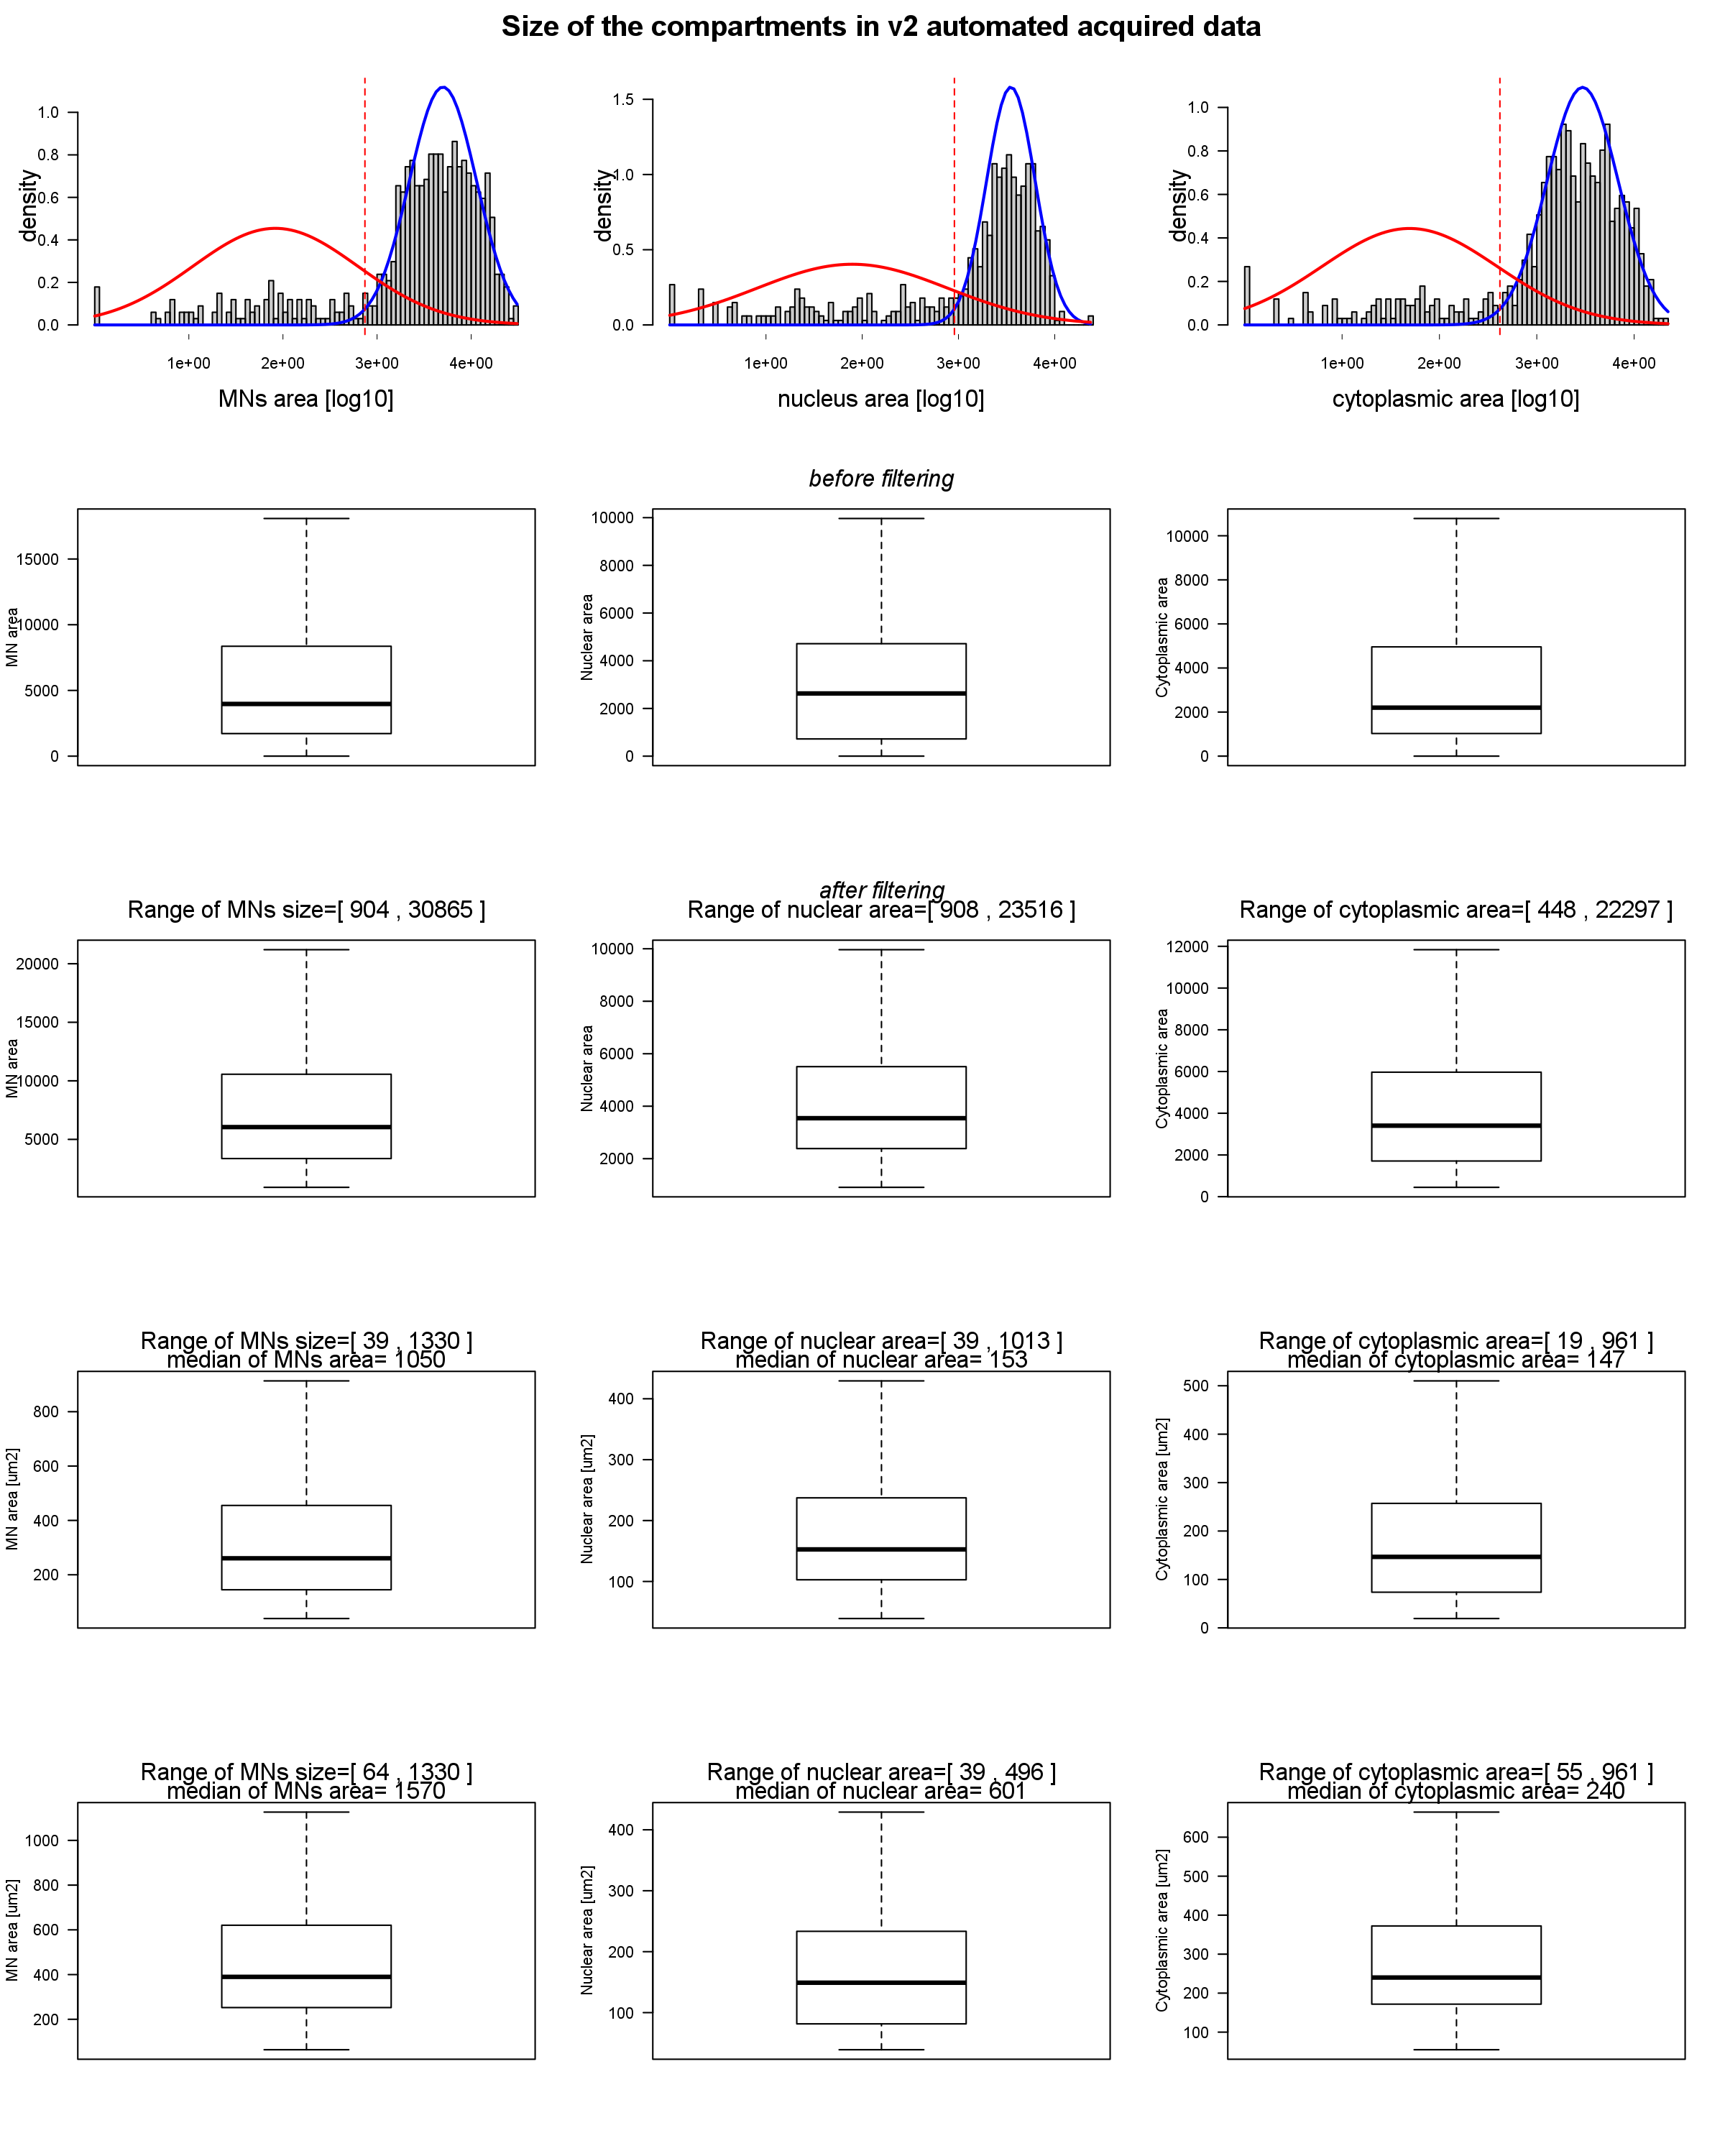

In [41]:
%%R -w 12 -h 15 --units in -r 200 -o positions_cells  -i path_to_action -i path_to_info -i path_to_MNs -i path_to_Nuclei -i path_to_Nuclei -i path_to_Cyto -o data -o myinfo

actions <- read.csv(path_to_action)
myinfo  <- read.csv(path_to_info)

###MNs
MNs                     <- read.csv(path_to_MNs)
MNs$imageID             <- as.character(MNs$Metadata_ID)
rownames(MNs)           <- paste(MNs$imageID,MNs$ObjectNumber,sep="_")
positions_cells         <- MNs[,c("imageID","Location_Center_X","Location_Center_Y","AreaShape_Center_X","AreaShape_Center_Y")]
positions_cells$cellID  <- rownames(MNs)
MNs                     <- MNs[,-which(colnames(MNs)%in%as.character(actions$collID)[which(actions$toberemoved)])]
MNs                     <- MNs[which(MNs$imageID%in%myinfo$imageID),]
infocells               <- myinfo[match(MNs$imageID,myinfo$imageID),]
infocells$cellID        <- rownames(MNs)
MNs                     <- MNs[,-match(c('imageID','Metadata_ID.1'),colnames(MNs))]

##Nuclei
nucleus             <- read.csv(path_to_Nuclei)
nucleus$imageID     <- as.character(nucleus$Metadata_ID)
nucleus             <- nucleus[-which(nucleus$Parent_ML_MN==0),]
nucleus$uniqueID    <- paste(nucleus$imageID,nucleus$Parent_ML_MN,sep="_")
#Remove MNs woth no cellID
infocells           <- infocells[!is.na(match(rownames(MNs),nucleus$uniqueID)),]
MNs                 <- MNs[!is.na(match(rownames(MNs),nucleus$uniqueID)),]
#Aggregate when several nuclei elements
temp                <- data.frame(table(nucleus$uniqueID))
temp                <- temp[temp$Freq>1,]
nucA                <- nucleus[!nucleus$uniqueID%in%temp$Var1,]
nucB                <- nucleus[nucleus$uniqueID%in%temp$Var1,]
nucB_agg            <- do.call(what=rbind,args=lapply(unique(nucB$uniqueID),function(rowid)return(AggregateData(submat=nucB[which(nucB$uniqueID%in%rowid),]))))
nucleus_f           <- rbind(nucB_agg,nucA)
rownames(nucleus_f) <- nucleus_f$uniqueID
nucleus_f           <- nucleus_f[,-which(colnames(nucleus_f)%in%as.character(actions$collID)[which(actions$toberemoved)])]
nucleus_f           <- nucleus_f[,-match(c('imageID','Metadata_ID.1','uniqueID'),colnames(nucleus_f))]
nucleus_f           <- nucleus_f[!is.na(match(rownames(nucleus_f),rownames(MNs))),]
infocells           <- infocells[match(rownames(nucleus_f),rownames(MNs)),]
MNs_f               <- MNs[match(rownames(nucleus_f),rownames(MNs)),]
                                                       
#Cytoplasms 
cyto               <- read.csv(path_to_Cyto)
cyto$imageID       <- as.character(cyto$Metadata_ID)
cyto$uniqueID      <- paste(cyto$imageID,cyto$Parent_ML_MNs_Cyto,sep="_")
rownames(cyto)     <- cyto$uniqueID
cyto_f             <- cyto[,-which(colnames(cyto)%in%as.character(actions$collID)[which(actions$toberemoved)])]
cyto_f             <- cyto_f[,-which(colnames(cyto_f)%in%c('imageID','Metadata_ID.1','uniqueID'))]
cyto_f             <- cyto_f[match(rownames(nucleus_f),rownames(cyto_f)),]

#Remove when cyto area is NaN
infocells         <- infocells[!is.na(cyto_f$AreaShape_Area),]
nucleus_f         <- nucleus_f[!is.na(cyto_f$AreaShape_Area),]
MNs_f             <- MNs_f[!is.na(cyto_f$AreaShape_Area),]
cyto_f            <- cyto_f[!is.na(cyto_f$AreaShape_Area),]                                                       

#Filter out cells with small nuclei and cytoplasm                                                      
par(mfrow=c(5,3))
bimdens_MNs<- densityMclust(data=log10(MNs_f$AreaShape_Area),G=2)
LimMNs     <- 10^qnorm(0.01,mean=bimdens_MNs$parameters$mean[2],sd=sqrt(bimdens_MNs$parameters$variance$sigmasq[2]))
plotMclust(mydata=log10(MNs_f$AreaShape_Area),mybim=bimdens_MNs,myLim=log10(LimMNs),myname="MNs area [log10]")
                                                    
                                                    
bimdens_Nuc<- densityMclust(data=log10(nucleus_f$AreaShape_Area),G=2)
LimNuc     <- 10^qnorm(0.01,mean=bimdens_Nuc$parameters$mean[2],sd=sqrt(bimdens_Nuc$parameters$variance$sigmasq[2]))
plotMclust(mydata=log10(nucleus_f$AreaShape_Area),mybim=bimdens_Nuc,myLim=log10(LimNuc),myname="nucleus area [log10]")
mtext(side=3,line=2,font=2,text="Size of the compartments in v2 automated acquired data",cex=1.2)

                                                    
bimdens_Cyto<- densityMclust(data=log10(cyto_f$AreaShape_Area+1),G=2)
LimCyto     <- 10^qnorm(0.01,mean=bimdens_Cyto$parameters$mean[2],sd=sqrt(bimdens_Cyto$parameters$variance$sigmasq[2]))
plotMclust(mydata=log10(cyto_f$AreaShape_Area+1),mybim=bimdens_Cyto,myLim=log10(LimCyto),myname="cytoplasmic area [log10]")

                                                    
boxplot(MNs_f$AreaShape_Area,las=1,ylab="MN area",outline=FALSE)
boxplot(nucleus_f$AreaShape_Area,las=1,ylab="Nuclear area",outline=FALSE)
mtext(side=3,line=1,font=3,text="before filtering",cex=1.0)
boxplot(cyto_f$AreaShape_Area,las=1,ylab="Cytoplasmic area",outline=FALSE)                                                    
   

tokeep      <- cyto_f$AreaShape_Area>=LimCyto&nucleus_f$AreaShape_Area>=LimNuc&MNs_f$AreaShape_Area>=LimMNs
infocells   <- infocells[tokeep,]
nucleus_f   <- nucleus_f[tokeep,]
MNs_f       <- MNs_f[tokeep,]
cyto_f      <- cyto_f[tokeep,]    
                                                      
                                                                                                          
                                                      
cytoplasm_motif <- cyto_f
for(i in c(1:ncol(cytoplasm_motif))){
  cytoplasm_motif[which(cytoplasm_motif[,i]==0),i]<-min(cyto_f[cyto_f[,i]>0,i],na.rm=TRUE)
}


nc_ratios             <- nucleus_f[,c(match(colnames(nucleus_f)[grep(colnames(nucleus_f),pattern="MeanIntensity")],colnames(nucleus_f)),match(colnames(nucleus_f)[grep(colnames(nucleus_f),pattern="MedianIntensity")],colnames(nucleus_f)))]/cytoplasm_motif[,c(match(colnames(nucleus_f)[grep(colnames(nucleus_f),pattern="MeanIntensity")],colnames(cytoplasm_motif)),match(colnames(nucleus_f)[grep(colnames(nucleus_f),pattern="MedianIntensity")],colnames(cytoplasm_motif)))]
nc_rel                <- nucleus_f[,c(match(colnames(nucleus_f)[grep(colnames(nucleus_f),pattern="IntegratedIntensity_")],colnames(nucleus_f)),match(colnames(nucleus_f)[grep(colnames(nucleus_f),pattern="AreaShape_Area")],colnames(nucleus_f)))]/(nucleus_f[,c(match(colnames(nucleus_f)[grep(colnames(nucleus_f),pattern="IntegratedIntensity_")],colnames(nucleus_f)),match(colnames(nucleus_f)[grep(colnames(nucleus_f),pattern="AreaShape_Area")],colnames(nucleus_f)))]+cytoplasm_motif[,c(match(colnames(nucleus_f)[grep(colnames(nucleus_f),pattern="IntegratedIntensity_")],colnames(cytoplasm_motif)),match(colnames(nucleus_f)[grep(colnames(nucleus_f),pattern="AreaShape_Area")],colnames(cytoplasm_motif)))])

boxplot(MNs_f$AreaShape_Area,las=1,ylab="MN area",outline=FALSE)
mtext(paste("Range of MNs size=[",
            round(min(MNs_f$AreaShape_Area)),
            ",",
            round(max(MNs_f$AreaShape_Area)),"]"),side=3,line=1,font=1)
boxplot(nucleus_f$AreaShape_Area,las=1,ylab="Nuclear area",outline=FALSE)
mtext(side=3,line=2,font=3,text="after filtering",cex=1.0)
mtext(paste("Range of nuclear area=[",
            round(min(nucleus_f$AreaShape_Area)),
            ",",
            round(max(nucleus_f$AreaShape_Area)),"]"),side=3,line=1,font=1)
boxplot(cyto_f$AreaShape_Area,las=1,ylab="Cytoplasmic area",outline=FALSE)                                                    
mtext(paste("Range of cytoplasmic area=[",
            round(min(cyto_f$AreaShape_Area)),
            ",",
            round(max(cyto_f$AreaShape_Area)),"]"),side=3,line=1,font=1)
                                                    
     
#In um2                               
boxplot(MNs_f$AreaShape_Area*(1/4.8177)^2,las=1,ylab="MN area [um2]",outline=FALSE)
mtext(paste("Range of MNs size=[",
            round(min(MNs_f$AreaShape_Area*(1/4.8177)^2)),
            ",",
            round(max(MNs_f$AreaShape_Area*(1/4.8177)^2)),"]"),side=3,line=1,font=1)
mtext(paste("median of MNs area=", round(median(MNs_f$AreaShape_Area*(1/2.4)^2))),side=3,line=0,font=1)                                  
                            
boxplot(nucleus_f$AreaShape_Area*(1/4.8177)^2,las=1,ylab="Nuclear area [um2]",outline=FALSE)
mtext(paste("Range of nuclear area=[",
            round(min(nucleus_f$AreaShape_Area*(1/4.8177)^2)),
            ",",
            round(max(nucleus_f$AreaShape_Area*(1/4.8177)^2)),"]"),side=3,line=1,font=1)
mtext(paste("median of nuclear area=", round(median(nucleus_f$AreaShape_Area*(1/4.8177)^2))),side=3,line=0,font=1)                                  

boxplot(cyto_f$AreaShape_Area*(1/4.8177)^2,las=1,ylab="Cytoplasmic area [um2]",outline=FALSE)                                                    
mtext(paste("Range of cytoplasmic area=[",
            round(min(cyto_f$AreaShape_Area*(1/4.8177)^2)),
            ",",
            round(max(cyto_f$AreaShape_Area*(1/4.8177)^2)),"]"),side=3,line=1,font=1)  
mtext(paste("median of cytoplasmic area=", round(median(cyto_f$AreaShape_Area*(1/4.8177)^2))),side=3,line=0,font=1)                                  
      
                                
                                
#In um2 after remving cells with nuclei > MNs
mysel=nucleus_f$AreaShape_Area<cyto_f$AreaShape_Area                                
boxplot(MNs_f$AreaShape_Area[mysel]*(1/4.8177)^2,las=1,ylab="MN area [um2]",outline=FALSE)
mtext(paste("Range of MNs size=[",
            round(min(MNs_f$AreaShape_Area[mysel]*(1/4.8177)^2)),
            ",",
            round(max(MNs_f$AreaShape_Area[mysel]*(1/4.8177)^2)),"]"),side=3,line=1,font=1)
mtext(paste("median of MNs area=", round(median(MNs_f$AreaShape_Area[mysel]*(1/2.4)^2))),side=3,line=0,font=1)                                  
                            
boxplot(nucleus_f$AreaShape_Area[mysel]*(1/4.8177)^2,las=1,ylab="Nuclear area [um2]",outline=FALSE)
mtext(paste("Range of nuclear area=[",
            round(min(nucleus_f$AreaShape_Area[mysel]*(1/4.8177)^2)),
            ",",
            round(max(nucleus_f$AreaShape_Area[mysel]*(1/4.8177)^2)),"]"),side=3,line=1,font=1)
mtext(paste("median of nuclear area=", round(median(nucleus_f$AreaShape_Area[mysel]*(1/2.4)^2))),side=3,line=0,font=1)                                  

boxplot(cyto_f$AreaShape_Area[mysel]*(1/4.8177)^2,las=1,ylab="Cytoplasmic area [um2]",outline=FALSE)                                                    
mtext(paste("Range of cytoplasmic area=[",
            round(min(cyto_f$AreaShape_Area[mysel]*(1/4.8177)^2)),
            ",",
            round(max(cyto_f$AreaShape_Area[mysel]*(1/4.8177)^2)),"]"),side=3,line=1,font=1)  
mtext(paste("median of cytoplasmic area=", round(median(cyto_f$AreaShape_Area[mysel]*(1/4.8177)^2))),side=3,line=0,font=1)                                  
      
                                  
                                
print(paste("Lower bound for MNs=",min(MNs_f$AreaShape_Area*(1/4.8177)^2),"um2"))
print(paste("Lower bound for Nuclear area=",min(nucleus_f$AreaShape_Area*(1/4.8177)^2),"um2"))
print(paste("Lower bound for cytoplasmic area=",min(cyto_f$AreaShape_Area*(1/4.8177)^2),"um2"))                                 
 
                                                      
                                                      
colnames(MNs_f)       <- paste(colnames(MNs_f),"_MNs",sep="")
colnames(nucleus_f)   <- paste(colnames(nucleus_f),"_nuc",sep="")
colnames(cyto_f)      <- paste(colnames(cyto_f),"_cyto",sep="")
colnames(nc_ratios)   <- paste(colnames(nc_ratios),"_nc_ratios",sep="")
colnames(nc_rel)      <- paste(colnames(nc_rel),"_nc_rel",sep="")

                                                    
                                                  
data                  <- cbind(MNs_f,nucleus_f,cyto_f,nc_ratios,nc_rel)
myinfo                <- infocells  
                                                      

              
                                
#Keep when animals used for previous manuscripts
tokeep                          <- which(myinfo$animal%in%c("VCP1", "VCP2", "VCP3","4G9", "4G13", "4G15","4G10", "4G12", "4G14", "4G16"))
data                            <- data[tokeep,]
myinfo                          <- myinfo[tokeep,]
myinfo$animal                   <- factor(as.character(myinfo$animal),
                           levels=c(unique(as.character(myinfo$animal[myinfo$mutation=="CTRL"])),
                                   unique(as.character(myinfo$animal[myinfo$mutation=="SOD1"])),
                                    unique(as.character(myinfo$animal[myinfo$mutation=="VCP"])))) 

myinfo$ID                       <- myinfo$animal
                                      

colnames(data)   <- gsub(colnames(data),pattern="RBP2",repl="FUS")
colnames(data)   <- gsub(colnames(data),pattern="RBP1",repl="SFPQ")
data             <- data[,apply(data,2,function(Z)return(var(Z,na.rm=TRUE)))>0]
data             <- data[,colnames(data)!='Children_ML_Nuc_NoInc_Count_nuc']                                
myinfo$mutant    <- ifelse(myinfo$mutation=="CTRL","CTRL","Mutant")                                                    
positions_cells <- positions_cells[match(myinfo$cellID,positions_cells$cellID),]                                                                                         

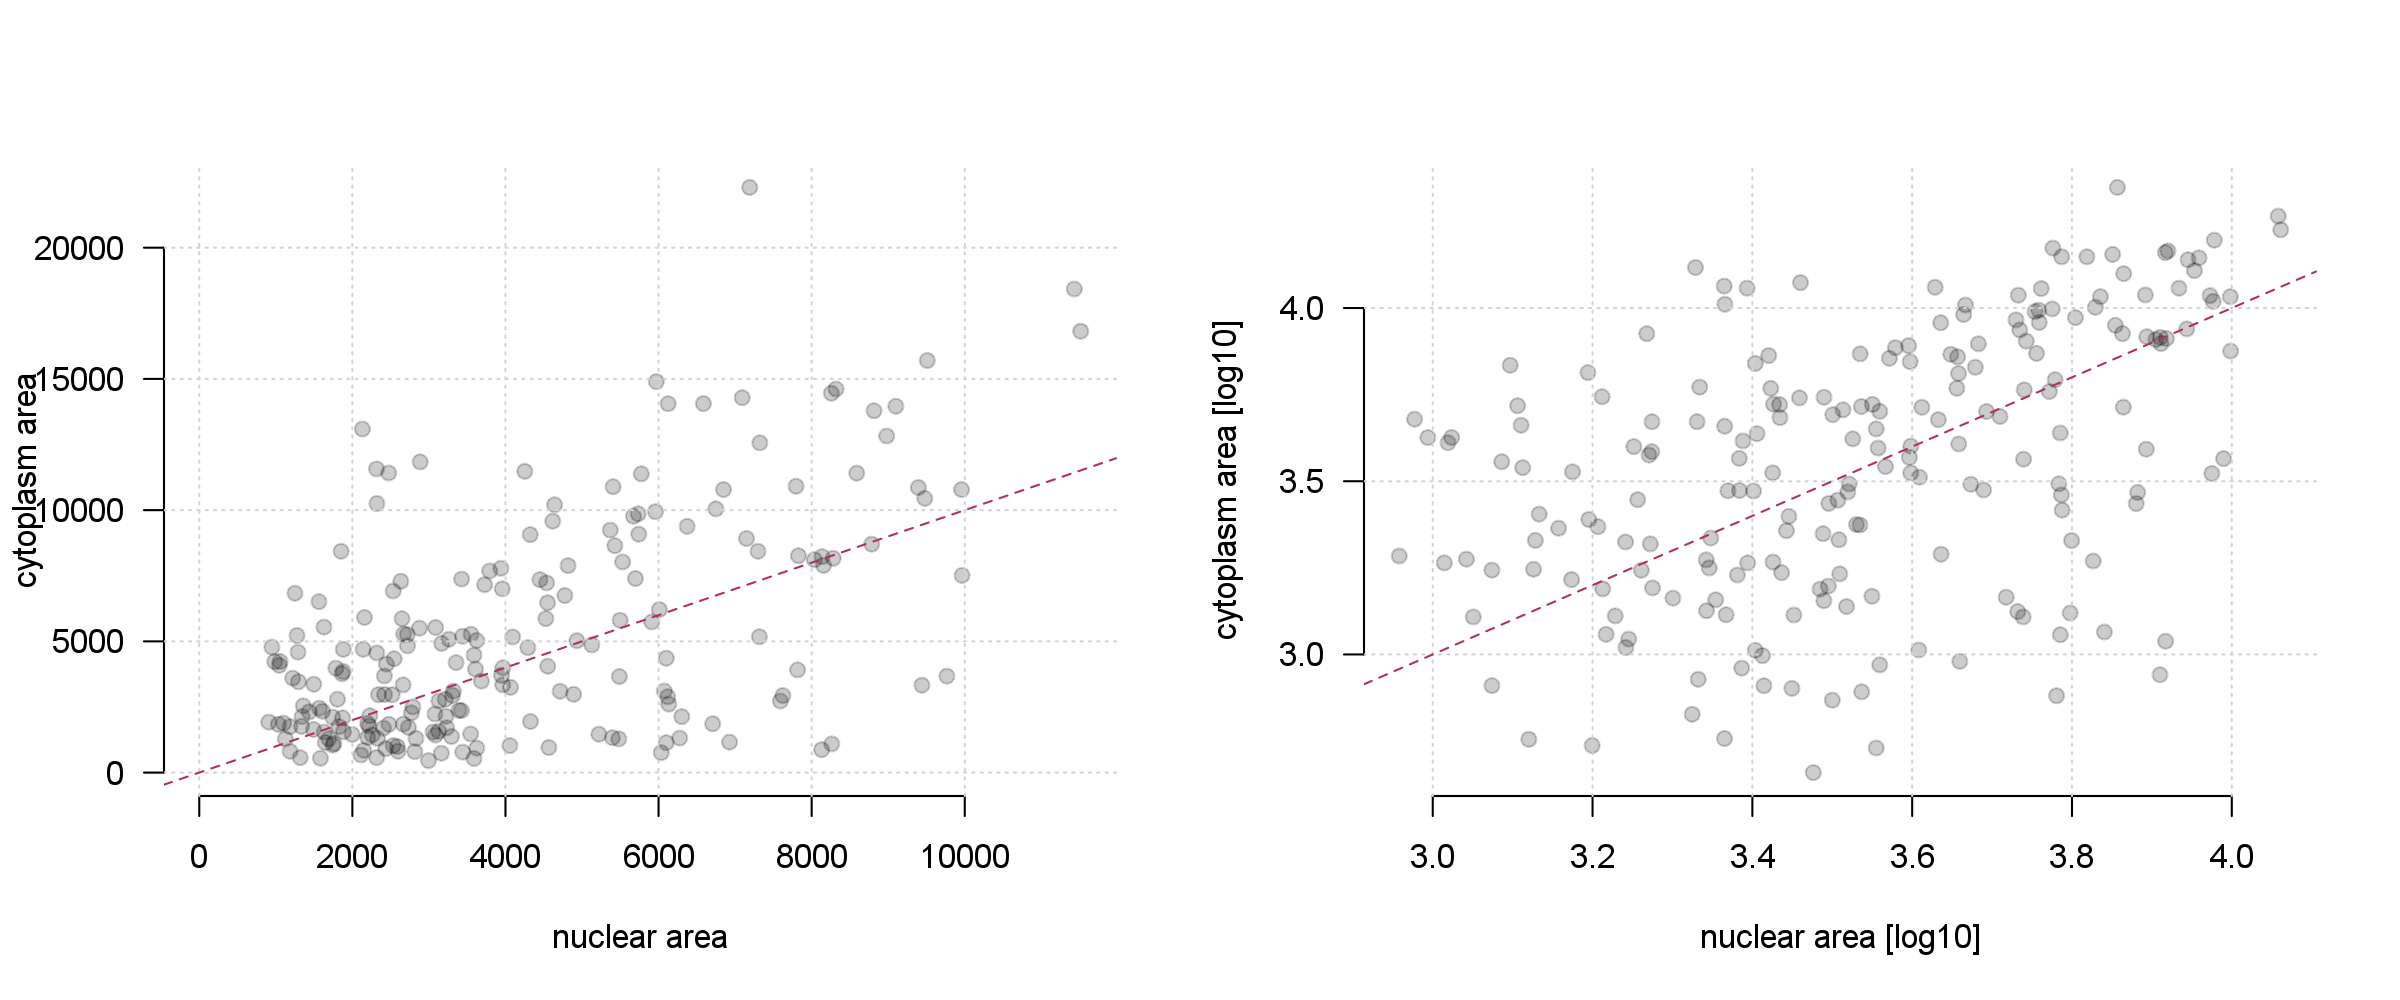

In [42]:
%%R -w 12 -h 5 --units in -r 200
par(mfrow=c(1,2))
plot(y=data[,'AreaShape_Area_cyto'],x=data[,'AreaShape_Area_nuc'],
     pch=19,col=rgb(0,0,0,0.2),ylab='cytoplasm area',xlab='nuclear area',las=1,
     xlim=c(0,max(data[,'AreaShape_Area_nuc'])),
     ylim=c(0,max(data[,'AreaShape_Area_cyto'])),frame=F)
grid()
abline(0,1,col='maroon',lty=2)

plot(y=log10(data[,'AreaShape_Area_cyto']),x=log10(data[,'AreaShape_Area_nuc']),
     pch=19,col=rgb(0,0,0,0.2),ylab='cytoplasm area [log10]',xlab='nuclear area [log10]',las=1,frame=F)
grid()
abline(0,1,col='maroon',lty=2)

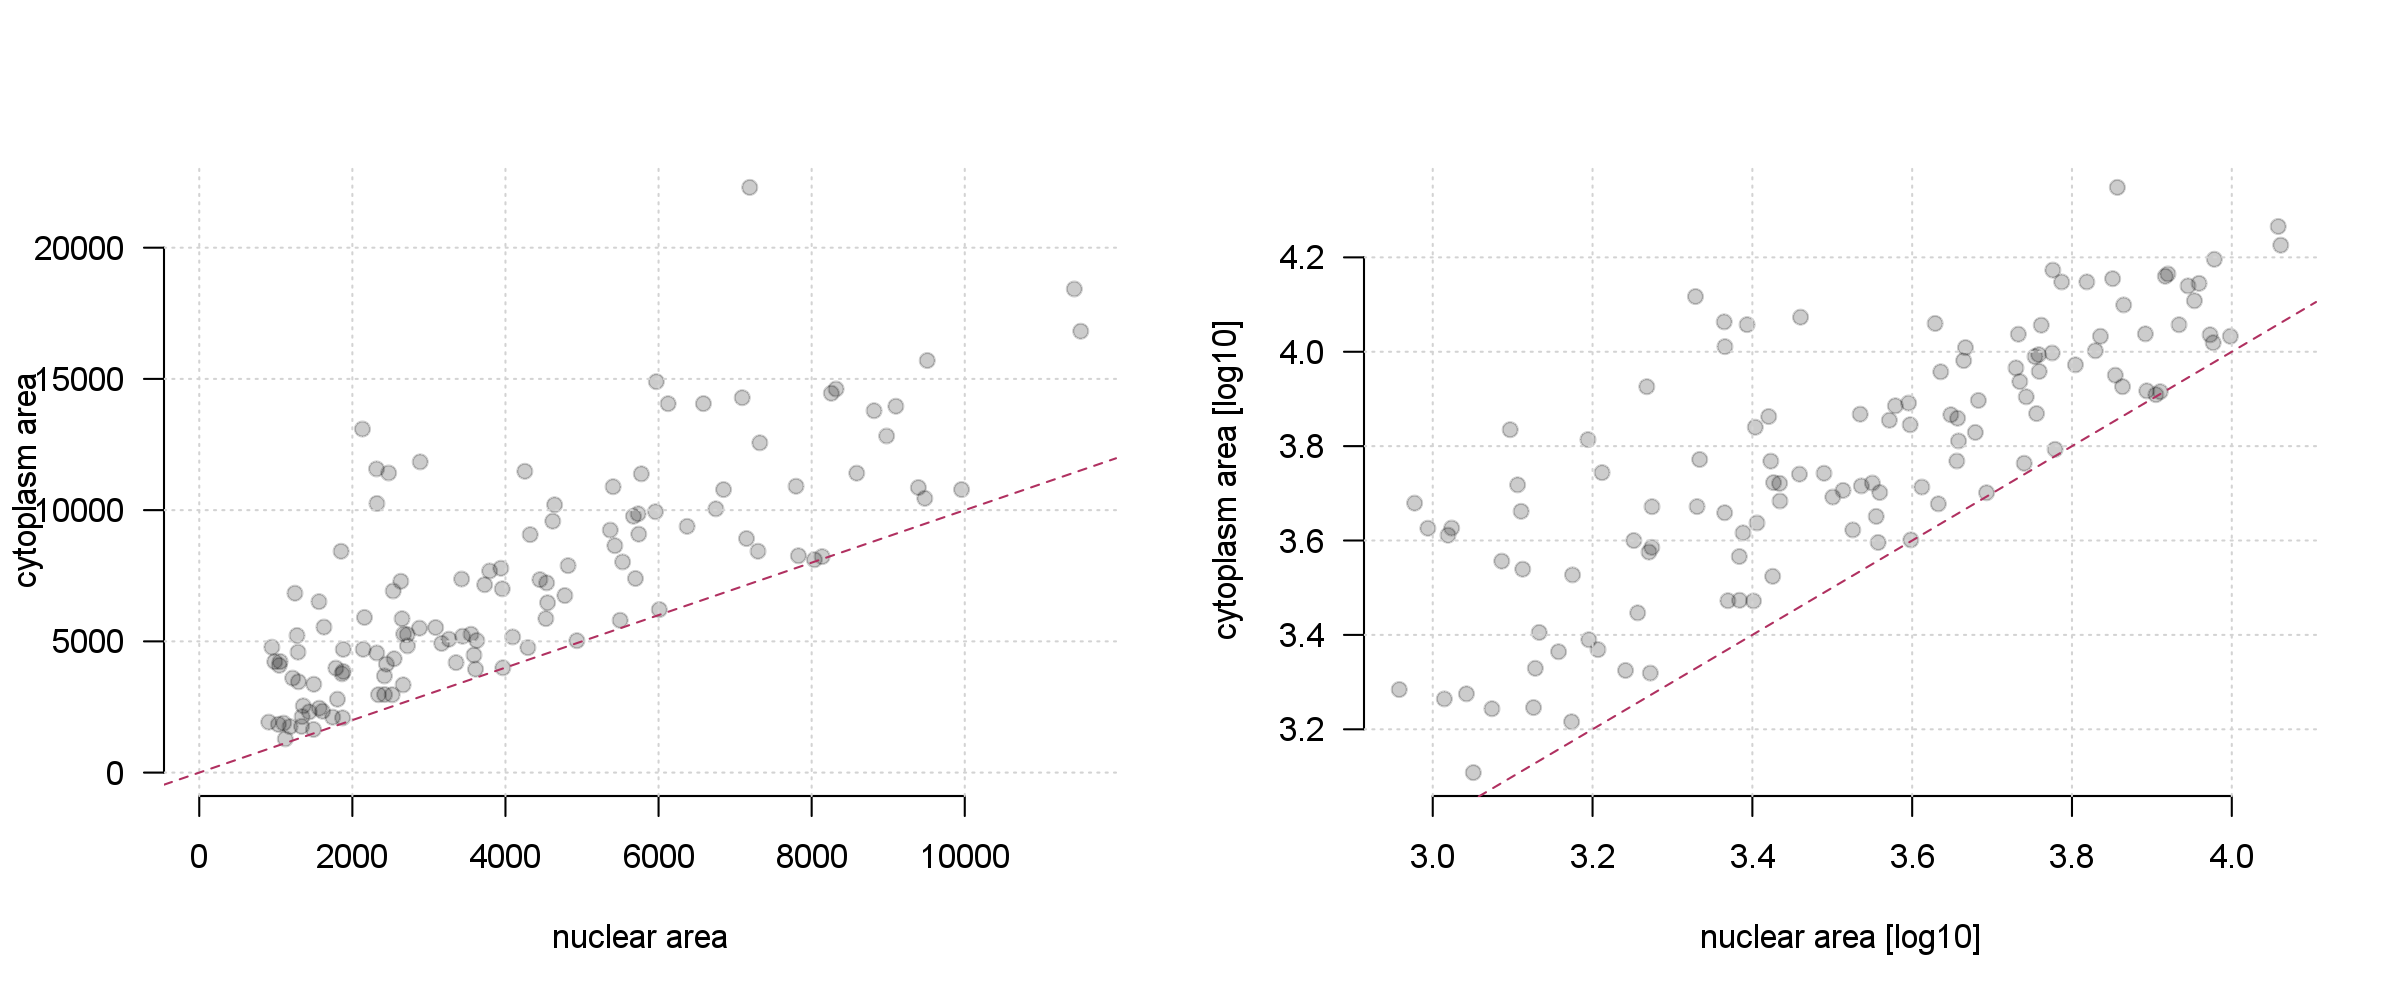

In [43]:
%%R -w 12 -h 5 --units in -r 200 -o data -o myinfo -o myinfo_full -o data_full
data_full   <- data
myinfo_full <- myinfo
#Remove when nuclear area is larger than cytplasm
torm   <- data[,'AreaShape_Area_cyto']<data[,'AreaShape_Area_nuc']
data   <- data[!torm,]
myinfo <- myinfo[!torm,] 

par(mfrow=c(1,2))
plot(y=data[,'AreaShape_Area_cyto'],x=data[,'AreaShape_Area_nuc'],
     pch=19,col=rgb(0,0,0,0.2),ylab='cytoplasm area',xlab='nuclear area',las=1,
     xlim=c(0,max(data[,'AreaShape_Area_nuc'])),
     ylim=c(0,max(data[,'AreaShape_Area_cyto'])),frame=F)
grid()
abline(0,1,col='maroon',lty=2)

plot(y=log10(data[,'AreaShape_Area_cyto']),x=log10(data[,'AreaShape_Area_nuc']),
     pch=19,col=rgb(0,0,0,0.2),ylab='cytoplasm area [log10]',xlab='nuclear area [log10]',las=1,frame=F)
grid()
abline(0,1,col='maroon',lty=2)

In [44]:
myinfo.head()

X imageID mutation  RBP1 RBP2 animal origin   Lab     pairs     cellID  \
2.30  2  4G10D2     SOD1  SFPQ  FUS   4G10     GT  Gipi  SFPQ_FUS  4G10D2_31   
3.6   3  4G12D1     SOD1  SFPQ  FUS   4G12     GT  Gipi  SFPQ_FUS   4G12D1_7   
3.8   3  4G12D1     SOD1  SFPQ  FUS   4G12     GT  Gipi  SFPQ_FUS   4G12D1_9   
3.33  3  4G12D1     SOD1  SFPQ  FUS   4G12     GT  Gipi  SFPQ_FUS  4G12D1_34   
4     4  4G12D2     SOD1  SFPQ  FUS   4G12     GT  Gipi  SFPQ_FUS   4G12D2_1   

        ID  mutant  
2.30  4G10  Mutant  
3.6   4G12  Mutant  
3.8   4G12  Mutant  
3.33  4G12  Mutant  
4     4G12  Mutant

In [45]:
myinfo.mutation.value_counts()

VCP     64
SOD1    29
CTRL    28
Name: mutation, dtype: int64

In [46]:
data.shape

(121, 958)

In [47]:
data.head()

AreaShape_Area_MNs  AreaShape_Compactness_MNs  \
4G10D2_31                3032                   1.091447   
4G12D1_7                20541                   1.211483   
4G12D1_9                 9901                   1.895280   
4G12D1_34                2418                   2.033945   
4G12D2_1                 7780                   1.106061   

           AreaShape_Eccentricity_MNs  AreaShape_Extent_MNs  \
4G10D2_31                    0.673342              0.619155   
4G12D1_7                     0.803382              0.586634   
4G12D1_9                     0.780502              0.352148   
4G12D1_34                    0.907131              0.439636   
4G12D2_1                     0.601491              0.589394   

           AreaShape_FormFactor_MNs  AreaShape_MajorAxisLength_MNs  \
4G10D2_31                  0.478946                      73.737454   
4G12D1_7                   0.178509                     215.861756   
4G12D1_9                   0.068775                     185.005652   
4G12D1_34                  0.165059                     103.004287   
4G12D2_1                   0.237204                     115.470265   

           AreaShape_MaxFeretDiameter_MNs  AreaShape_MaximumRadius_MNs  \
4G10D2_31                       82.873397                    25.632011   
4G12D1_7                       235.552542                    55.009090   
4G12D1_9                       197.010152                    27.294688   
4G12D1_34                      103.092192                    14.000000   
4G12D2_1                       131.186890                    36.496575   

           AreaShape_MeanRadius_MNs  AreaShape_MedianRadius_MNs  ...  \
4G10D2_31                  8.814155                    7.615773  ...   
4G12D1_7                  19.002718                   16.401219  ...   
4G12D1_9                   7.024312                    5.830952  ...   
4G12D1_34                  4.942093                    4.242641  ...   
4G12D2_1                  11.981588                   10.000000  ...   

           Intensity_MeanIntensity_FUS_nc_ratios  \
4G10D2_31                               1.451250   
4G12D1_7                                1.393970   
4G12D1_9                                1.249412   
4G12D1_34                               1.155348   
4G12D2_1                                1.089586   

           Intensity_MedianIntensity_CHAT_nc_ratios  \
4G10D2_31                                  1.019592   
4G12D1_7                                   0.977717   
4G12D1_9                                   0.912661   
4G12D1_34                                  0.859623   
4G12D2_1                                   0.989749   

           Intensity_MedianIntensity_DAPI_nc_ratios  \
4G10D2_31                                  1.497668   
4G12D1_7                                   1.224975   
4G12D1_9                                   1.151327   
4G12D1_34                                  1.380733   
4G12D2_1                                   1.108623   

           Intensity_MedianIntensity_SFPQ_nc_ratios  \
4G10D2_31                                  1.456906   
4G12D1_7                                   1.349448   
4G12D1_9                                   2.195676   
4G12D1_34                                  1.761245   
4G12D2_1                                   1.186739   

           Intensity_MedianIntensity_FUS_nc_ratios  \
4G10D2_31                                 1.495505   
4G12D1_7                                  1.377802   
4G12D1_9                                  1.279129   
4G12D1_34                                 1.164203   
4G12D2_1                                  1.088087   

           Intensity_IntegratedIntensity_CHAT_nc_rel  \
4G10D2_31                                   0.442756   
4G12D1_7                                    0.315943   
4G12D1_9                                    0.168951   
4G12D1_34                                   0.362734   
4G12D2_1                                    0.333822   

    

In [48]:
number_cells_mt=pd.DataFrame({
              'automated_full':myinfo_full.loc[myinfo_full['RBP1']=='SFPQ']['ID'].value_counts(),
               'automated_sel':myinfo.loc[myinfo['RBP1']=='SFPQ']['ID'].value_counts()})
number_cells_mt=number_cells_mt.reset_index()
a = number_cells_mt['index'].tolist()
b = myinfo['ID'].tolist()
number_cells_mt['mutation']=myinfo.iloc[ [b.index(x) if x in b else None for x in a] ]['mutation'].reset_index()['mutation']
number_cells_mt[['index','mutation','automated_full','automated_sel']]

index mutation  automated_full  automated_sel
0  4G10     SOD1               7              2
1  4G12     SOD1              10              7
2  4G13     CTRL              15             11
3  4G14     SOD1              14              7
4  4G15     CTRL              12              6
5  4G16     SOD1              24             13
6   4G9     CTRL              13             11
7  VCP1      VCP              39             35
8  VCP2      VCP              40              5
9  VCP3      VCP              36             24

In [49]:
info = number_cells_mt;
info['ID']=info['mutation']+'-'+info['index'];
info.index=info['ID']
info

index  automated_full  automated_sel mutation         ID
ID                                                                
SOD1-4G10  4G10               7              2     SOD1  SOD1-4G10
SOD1-4G12  4G12              10              7     SOD1  SOD1-4G12
CTRL-4G13  4G13              15             11     CTRL  CTRL-4G13
SOD1-4G14  4G14              14              7     SOD1  SOD1-4G14
CTRL-4G15  4G15              12              6     CTRL  CTRL-4G15
SOD1-4G16  4G16              24             13     SOD1  SOD1-4G16
CTRL-4G9    4G9              13             11     CTRL   CTRL-4G9
VCP-VCP1   VCP1              39             35      VCP   VCP-VCP1
VCP-VCP2   VCP2              40              5      VCP   VCP-VCP2
VCP-VCP3   VCP3              36             24      VCP   VCP-VCP3

## Machine learning methods for ALS cells prediction


### A. SVD analysis


In [55]:
%%R 
subinfo                     <- myinfo
subdat                      <- data
subinfo_full                <- myinfo_full
subdat_full                 <- data_full

#Remove measurements with NAs -same on full and sel
subdat_full                        <- subdat_full[,apply(is.na(subdat),2,sum)==0]
subdat                             <- subdat[,apply(is.na(subdat),2,sum)==0]
mat                                <- data.matrix(subdat)
mat_full                           <- data.matrix(subdat_full)

#Test for log-normality of the measurements across the cells
dF               <- unlist(lapply(c(1:ncol(mat)),function(ix)return(testLogNorm(mat[,ix]))))&apply(mat,2,min)>=0
print(sum(dF))


[1] 484


[1] "Dimension of transposed matrix = 750"
[2] "Dimension of transposed matrix = 121"


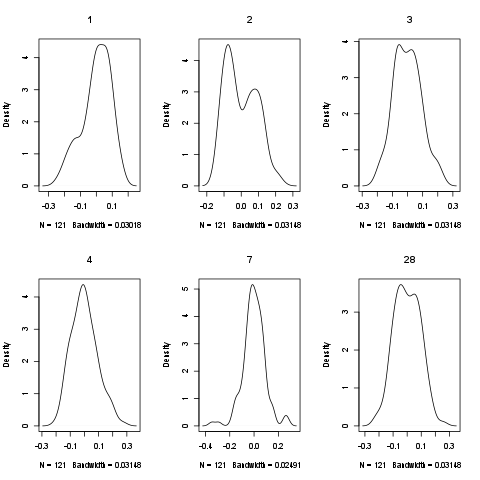

In [78]:
%%R 
  
subinfo                     <- myinfo
subdat                      <- data
subinfo_full                <- myinfo_full
subdat_full                 <- data_full

#Remove measurements with NAs -same on full and sel
subdat_full                        <- subdat_full[,apply(is.na(subdat),2,sum)==0]
subdat                             <- subdat[,apply(is.na(subdat),2,sum)==0]
mat                                <- data.matrix(subdat)
mat_full                           <- data.matrix(subdat_full)


testLogNorm <- function(val){
  if(min(val)<0){
    return(FALSE)
  }
  if(min(val)>=0){
    val  <- val+min(val[val>0])
    valt <- log(val)
    set.seed(5) 
    m1   <- lm(quantile(val,probs=seq(0, 1, 0.01))~quantile(rnorm(n=length(val),mean(val),sd(val)),probs=seq(0, 1, 0.01)))
    set.seed(5) 
    m2   <- lm(quantile(valt,probs=seq(0, 1, 0.01))~quantile(rnorm(n=length(valt),mean(valt),sd(valt)),probs=seq(0, 1, 0.01)))
    return(-anova(m1)$F[1]+anova(m2)$F[1]>10)
  }
}
#Test for log-normality of the measurements across the cells
dF               <- unlist(lapply(c(1:ncol(mat)),function(ix)return(testLogNorm(mat[,ix]))))&apply(mat,2,min)>=0
for(ix in which(dF)){
  mat_full[,ix]<-log(mat_full[,ix]+min(mat[mat[,ix]>0,ix]))
  mat[,ix]     <-log(mat[,ix]+min(mat[mat[,ix]>0,ix]))
}
                                  
#Standardized the measurements across the MNs
myavg <- apply(mat,2,function(Z)return(mean(Z,na.rm=T)))  
mysd  <- apply(mat,2,function(Z)return(sd(Z,na.rm=T)))  
for(i in c(1:ncol(mat))){
    mat[,i]     <- (mat[,i]-myavg[i])/mysd[i]
    mat_full[,i]<- (mat_full[,i]-myavg[i])/mysd[i]
}                         

mat              <- t(mat)
mat_full         <- t(mat_full)
mat_full         <- mat_full[apply(is.na(mat),1,sum)==0,]               
mat              <- mat[apply(is.na(mat),1,sum)==0,]
print(paste("Dimension of transposed matrix =",dim(mat)))

mat_stored = mat               
#SVD
SVD_eset    <- svd(mat)
pi          <- SVD_eset$d*SVD_eset$d/sum(SVD_eset$d*SVD_eset$d)
d           <- -1*sum(pi*log10(pi))/log10(length(pi))
Us          <- data.frame(SVD_eset$u)
               
par(mfrow=c(2,3))
for(i in c(1,2,3,4,7,28)){
    plot(density(SVD_eset$v[,i]),main=i)
}
                                

In [73]:
%%R
ix=8
valp=mat2[,ix]
testLogNorm(val)

[1] FALSE


[1] "Initial dimension of matrix = 121" "Initial dimension of matrix = 751"
[1] "Dimension of transposed matrix = 750"
[2] "Dimension of transposed matrix = 121"


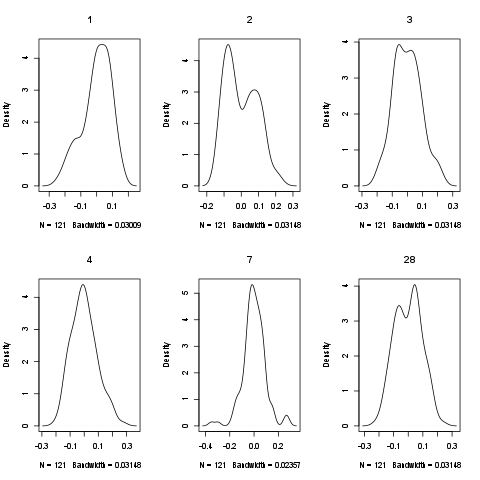

In [31]:
%%R 
subinfo                     <- myinfo
subdat                      <- data
subinfo_full                <- myinfo_full
subdat_full                 <- data_full

#Remove measurements with NAs -same on full and sel
subdat_full                        <- subdat_full[,apply(is.na(subdat),2,sum)==0]
subdat                             <- subdat[,apply(is.na(subdat),2,sum)==0]
mat                                <- data.matrix(subdat)
mat_full                           <- data.matrix(subdat_full)
print(paste("Initial dimension of matrix =",dim(mat)))

#Test for log-normality of the measurements across the cells
dF               <- unlist(lapply(c(1:ncol(mat)),function(ix)return(testLogNorm(mat[,ix]))))&apply(mat,2,min)>=0
for(ix in which(dF)){
  mat_full[,ix]<-log(mat_full[,ix]+min(mat[mat[,ix]>0,ix]))
  mat[,ix]     <-log(mat[,ix]+min(mat[mat[,ix]>0,ix]))
}
                                  
#Standardized the measurements across the MNs
myavg <- apply(mat,2,function(Z)return(mean(Z,na.rm=T)))  
mysd  <- apply(mat,2,function(Z)return(sd(Z,na.rm=T)))  
for(i in c(1:ncol(mat))){
    mat[,i]     <- (mat[,i]-myavg[i])/mysd[i]
    mat_full[,i]<- (mat_full[,i]-myavg[i])/mysd[i]
}                         

mat              <- t(mat)
mat_full         <- t(mat_full)
mat_full         <- mat_full[apply(is.na(mat),1,sum)==0,]               
mat              <- mat[apply(is.na(mat),1,sum)==0,]
print(paste("Dimension of transposed matrix =",dim(mat)))

mat_stored = mat               
#SVD
SVD_eset    <- svd(mat)
pi          <- SVD_eset$d*SVD_eset$d/sum(SVD_eset$d*SVD_eset$d)
d           <- -1*sum(pi*log10(pi))/log10(length(pi))
Us          <- data.frame(SVD_eset$u)
               
par(mfrow=c(2,3))
for(i in c(1,2,3,4,7,28)){
    plot(density(SVD_eset$v[,i]),main=i)
}

[1] "Initial dimension of matrix = 121" "Initial dimension of matrix = 751"
[1] "Dimension of transposed matrix = 750"
[2] "Dimension of transposed matrix = 121"


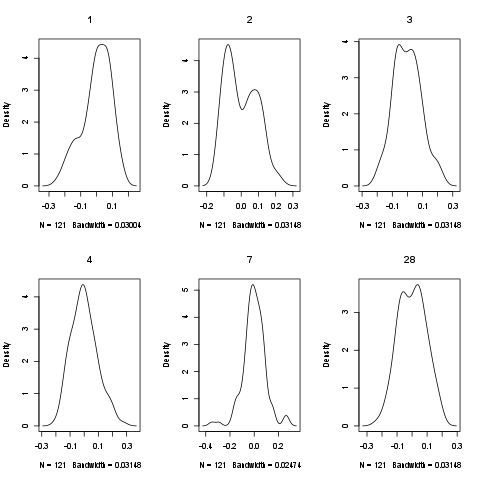

In [32]:
%%R 
subinfo                     <- myinfo
subdat                      <- data
subinfo_full                <- myinfo_full
subdat_full                 <- data_full

#Remove measurements with NAs -same on full and sel
subdat_full                        <- subdat_full[,apply(is.na(subdat),2,sum)==0]
subdat                             <- subdat[,apply(is.na(subdat),2,sum)==0]
mat                                <- data.matrix(subdat)
mat_full                           <- data.matrix(subdat_full)
print(paste("Initial dimension of matrix =",dim(mat)))

#Test for log-normality of the measurements across the cells
dF               <- unlist(lapply(c(1:ncol(mat)),function(ix)return(testLogNorm(mat[,ix]))))&apply(mat,2,min)>=0
for(ix in which(dF)){
  mat_full[,ix]<-log(mat_full[,ix]+min(mat[mat[,ix]>0,ix]))
  mat[,ix]     <-log(mat[,ix]+min(mat[mat[,ix]>0,ix]))
}
                                  
#Standardized the measurements across the MNs
myavg <- apply(mat,2,function(Z)return(mean(Z,na.rm=T)))  
mysd  <- apply(mat,2,function(Z)return(sd(Z,na.rm=T)))  
for(i in c(1:ncol(mat))){
    mat[,i]     <- (mat[,i]-myavg[i])/mysd[i]
    mat_full[,i]<- (mat_full[,i]-myavg[i])/mysd[i]
}                         

mat              <- t(mat)
mat_full         <- t(mat_full)
mat_full         <- mat_full[apply(is.na(mat),1,sum)==0,]               
mat              <- mat[apply(is.na(mat),1,sum)==0,]
print(paste("Dimension of transposed matrix =",dim(mat)))

#SVD
SVD_eset    <- svd(mat)
pi          <- SVD_eset$d*SVD_eset$d/sum(SVD_eset$d*SVD_eset$d)
d           <- -1*sum(pi*log10(pi))/log10(length(pi))
Us          <- data.frame(SVD_eset$u)
               
par(mfrow=c(2,3))
for(i in c(1,2,3,4,7,28)){
    plot(density(SVD_eset$v[,i]),main=i)
}

In [33]:
%%R


print(rownames(mat)[apply(mat-mat_stored,1,sum)>0])

#Intensity_MeanIntensityEdge_FUS_MNs


 [1] "AreaShape_MeanRadius_MNs"                     
 [2] "AreaShape_MinFeretDiameter_MNs"               
 [3] "AreaShape_MinorAxisLength_MNs"                
 [4] "AreaShape_Zernike_3_1_MNs"                    
 [5] "AreaShape_Zernike_4_0_MNs"                    
 [6] "AreaShape_Zernike_7_3_MNs"                    
 [7] "Intensity_StdIntensity_CHAT_MNs"              
 [8] "Texture_DifferenceEntropy_DAPI_3_00_MNs"      
 [9] "Texture_DifferenceEntropy_DAPI_3_01_MNs"      
[10] "Texture_DifferenceEntropy_SFPQ_3_01_MNs"      
[11] "Texture_DifferenceEntropy_FUS_3_00_MNs"       
[12] "Texture_Entropy_CHAT_3_01_MNs"                
[13] "Texture_Entropy_DAPI_3_00_MNs"                
[14] "Texture_Entropy_SFPQ_3_02_MNs"                
[15] "Texture_Entropy_FUS_3_02_MNs"                 
[16] "Texture_Entropy_FUS_3_03_MNs"                 
[17] "Texture_InfoMeas2_CHAT_3_03_MNs"              
[18] "Texture_InfoMeas2_FUS_3_02_MNs"               
[19] "Texture_InfoMeas2_FUS_3_03_MNs"         

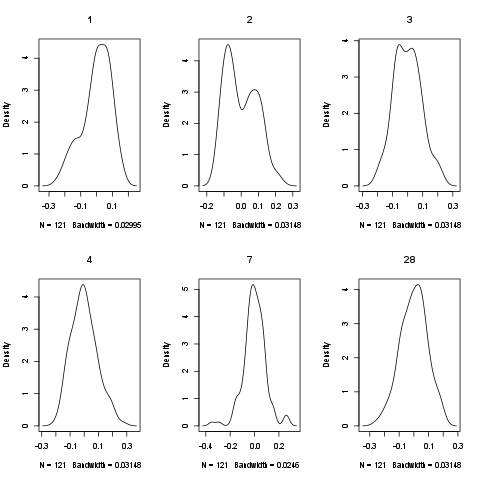

In [23]:
%%R 
subinfo                     <- myinfo
subdat                      <- data
subinfo_full                <- myinfo_full
subdat_full                 <- data_full

#Remove measurements with NAs -same on full and sel
subdat_full                        <- subdat_full[,apply(is.na(subdat),2,sum)==0]
subdat                             <- subdat[,apply(is.na(subdat),2,sum)==0]
mat                                <- data.matrix(subdat)
mat_full                           <- data.matrix(subdat_full)


#Test for log-normality of the data
dF               <- unlist(lapply(c(1:ncol(mat)),function(ix)return(testLogNorm(mat[,ix]))))&apply(mat,2,min)>=0
for(ix in which(dF)){
  mat_full[,ix]<-log(mat_full[,ix]+min(mat[mat[,ix]>0,ix]))
  mat[,ix]<-log(mat[,ix]+min(mat[mat[,ix]>0,ix]))
}
                                  
#Standardized the measurements across the MNs
myavg <- apply(mat,2,function(Z)return(mean(Z,na.rm=T)))  
mysd  <- apply(mat,2,function(Z)return(sd(Z,na.rm=T)))  
for(i in c(1:ncol(mat))){
    mat[,i]     <- (mat[,i]-myavg[i])/mysd[i]
    mat_full[,i]<- (mat_full[,i]-myavg[i])/mysd[i]
}                         

mat              <- t(mat)
mat_full         <- t(mat_full)
mat_full         <- mat_full[apply(is.na(mat),1,sum)==0,]               
mat              <- mat[apply(is.na(mat),1,sum)==0,]
               
#SVD
SVD_eset    <- svd(mat)
pi          <- SVD_eset$d*SVD_eset$d/sum(SVD_eset$d*SVD_eset$d)
d           <- -1*sum(pi*log10(pi))/log10(length(pi))
Us          <- data.frame(SVD_eset$u)
               
par(mfrow=c(2,3))
for(i in c(1,2,3,4,7,28)){
    plot(density(SVD_eset$v[,i]),main=i)
}

In [27]:
%%R  -o Us -o subdat -o subinfo -o mat -o mat_full -o subdat_full -o subinfo_full
subinfo                     <- myinfo
subdat                      <- data
subinfo_full                <- myinfo_full
subdat_full                 <- data_full

#Remove measurements with NAs -same on full and sel
subdat_full                        <- subdat_full[,apply(is.na(subdat),2,sum)==0]
subdat                             <- subdat[,apply(is.na(subdat),2,sum)==0]
mat                                <- data.matrix(subdat)
mat_full                           <- data.matrix(subdat_full)


#Test for log-normality of the data
dF               <- unlist(lapply(c(1:ncol(mat)),function(ix)return(testLogNorm(mat[,ix]))))&apply(mat,2,min)>=0
for(ix in which(dF)){
  mat_full[,ix]<-log(mat_full[,ix]+min(mat[mat[,ix]>0,ix]))
  mat[,ix]<-log(mat[,ix]+min(mat[mat[,ix]>0,ix]))
}
                                  
#Standardized the measurements across the MNs
myavg <- apply(mat,2,function(Z)return(mean(Z,na.rm=T)))  
mysd  <- apply(mat,2,function(Z)return(sd(Z,na.rm=T)))  
for(i in c(1:ncol(mat))){
    mat[,i]     <- (mat[,i]-myavg[i])/mysd[i]
    mat_full[,i]<- (mat_full[,i]-myavg[i])/mysd[i]
}                         

mat              <- t(mat)
mat_full         <- t(mat_full)
mat_full         <- mat_full[apply(is.na(mat),1,sum)==0,]               
mat              <- mat[apply(is.na(mat),1,sum)==0,]
               
#SVD
SVD_eset    <- svd(mat)
pi          <- SVD_eset$d*SVD_eset$d/sum(SVD_eset$d*SVD_eset$d)
d           <- -1*sum(pi*log10(pi))/log10(length(pi))
Us          <- data.frame(SVD_eset$u)
rownames(Us)<- rownames(mat)
colnames(Us)<- paste("PC",c(1:ncol(Us)),sep="")
ncomp        <- which(cumsum(pi)>=0.9)[1]
                                  
                                  
#LMM to test for association between ALS and each component                                  
test_ALS <- do.call(what=rbind,args=lapply(c(1:ncomp),function(IX){
  tempdat                <- data.frame(PC=SVD_eset$v[,IX],subinfo)
  m1.full                <- lmer(PC~1+mutant+(1|animal/Lab), data = tempdat)
  m1.null                <- lmer(PC~1+(1|animal/Lab), data = tempdat)
  tempdat=data.frame(anova(m1.null,m1.full))
  tempdat2=data.frame(coef(summary(m1.full)))
  return(c(tempdat['m1.full','Chisq'],tempdat['m1.full','Pr..Chisq.'],tempdat2['mutantMutant','Estimate'],tempdat2['mutantMutant','Std..Error']))
}))

colnames(test_ALS)<-c("Chisquare","Pvalue","effect_avg","effect_sd")
rownames(test_ALS)<-paste("PC",c(1:ncomp),sep="")
test_ALS <- data.frame(test_ALS)
sel_ALS  <- c(1:ncomp)[test_ALS$Pvalue<=0.05]



#LMM to test for association between VCP and each component                                  
test_VCP <- do.call(what=rbind,args=lapply(c(1:ncomp),function(IX){
  tempdat                <- data.frame(PC=SVD_eset$v[,IX],subinfo)
  tempdat                <- tempdat[tempdat$mutation!="SOD1",]
  tempdat$mutation       <- factor(as.character(tempdat$mutation))
  tempdat$animal         <- factor(as.character(tempdat$animal))
  tempdat$Lab            <- factor(as.character(tempdat$Lab))
  
  m1.full                <- lmer(PC~1+mutant+(1|animal/Lab), data = tempdat)
  m1.null                <- lmer(PC~1+(1|animal/Lab), data = tempdat)
  tempdat=data.frame(anova(m1.null,m1.full))
  tempdat2=data.frame(coef(summary(m1.full)))
  return(c(tempdat['m1.full','Chisq'],tempdat['m1.full','Pr..Chisq.'],tempdat2['mutantMutant','Estimate'],tempdat2['mutantMutant','Std..Error']))
}))
                                  
colnames(test_VCP)<-c("Chisquare","Pvalue","effect_avg","effect_sd")
rownames(test_VCP)<-paste("PC",c(1:ncomp),sep="")
test_VCP <- data.frame(test_VCP)
sel_VCP   <- c(1:nrow(test_VCP))[test_VCP$Pvalue<=0.05]


#Because data have been scaled projection and correlation are equivalent
myCorr <- do.call(what=cbind,args=lapply(c(1:ncomp),function(IX){
  return(unlist(lapply(c(1:nrow(mat)),function(ix)return(cor(x=SVD_eset$v[,IX],y=mat[ix,],method='pearson')))))
}))
rownames(myCorr)<- rownames(mat)
         
temp           <- SVD_eset$v[,c(1:ncomp)]
colnames(temp) <- paste("PC",c(1:ncomp),sep="")
subinfo        <- data.frame(subinfo,temp) 
         


In [29]:
subinfo['fullID']=subinfo['mutation'].astype(str)+subinfo['animal'].astype(str)
lut = dict(CTRL='grey', SOD1="#663399", VCP='#669933')
palette_animal = dict(CTRL4G9='#C0C1BF',CTRL4G13='#777777',CTRL4G15='#333332',
                      SOD14G10='#B383EA',SOD14G12='#8954D3',SOD14G14='#6C2DC4',SOD14G16='#6107E0',
                     VCPVCP1='#819965',VCPVCP2='#669933',VCPVCP3='#519303')
row_colors = subinfo.mutation.map(lut)
row_colors_full = subinfo.fullID.map(palette_animal)
data_tot=pd.DataFrame(mat.transpose(),index=row_colors.index)


In [30]:
data_tot.shape

(121, 750)

Saving figure Heatmap_measurements_across_cells_mouse_spMNs


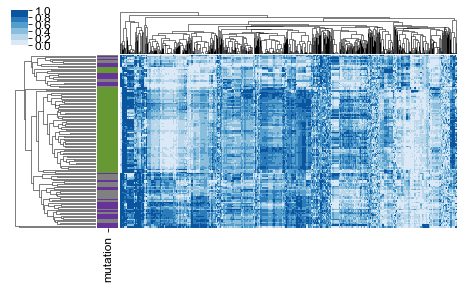

In [31]:
g=sns.clustermap(data_tot,row_colors=row_colors,yticklabels=False,standard_scale=1,xticklabels=False,
               cmap=sns.color_palette("Blues"),figsize=(8,4))
save_fig(fig_id='Heatmap_measurements_across_cells_mouse_spMNs', tight_layout=False)

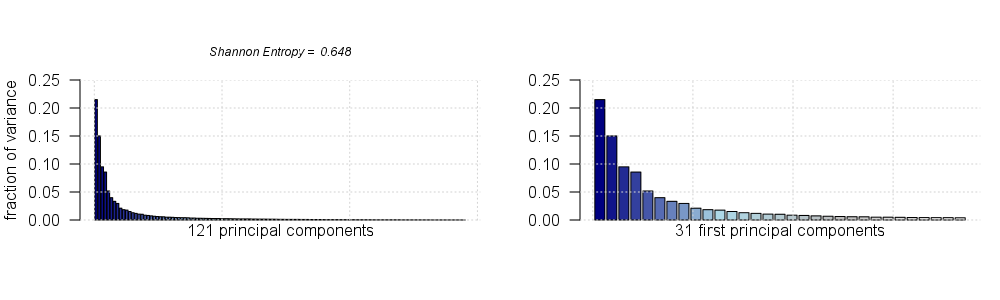

In [32]:
%%R -w 10 -h 3 --units in -r 100 -o pi

pal <- colorRampPalette(c("white","grey", "lightblue","navy"))
par(mfrow=c(1,2),mar=c(4,4,4,1))
barplot(pi,las=1,col=rev(pal(length(pi))),ylim=c(0,0.25))
mtext(side=1,line=0,text=paste(length(pi)," principal components",sep=""))
mtext(side=2,line=3,text="fraction of variance")
grid()
mtext(side = 3, line = 1, text = paste("Shannon Entropy = ",round(d,digits=3)), col = "black",cex=0.7, font=3,las=1)
barplot(pi[c(1:ncomp)],las=1,col=rev(pal(ncomp)),ylim=c(0,0.25))
mtext(side=1,line=0,text=paste(ncomp,"first principal components",sep=" "))
grid()


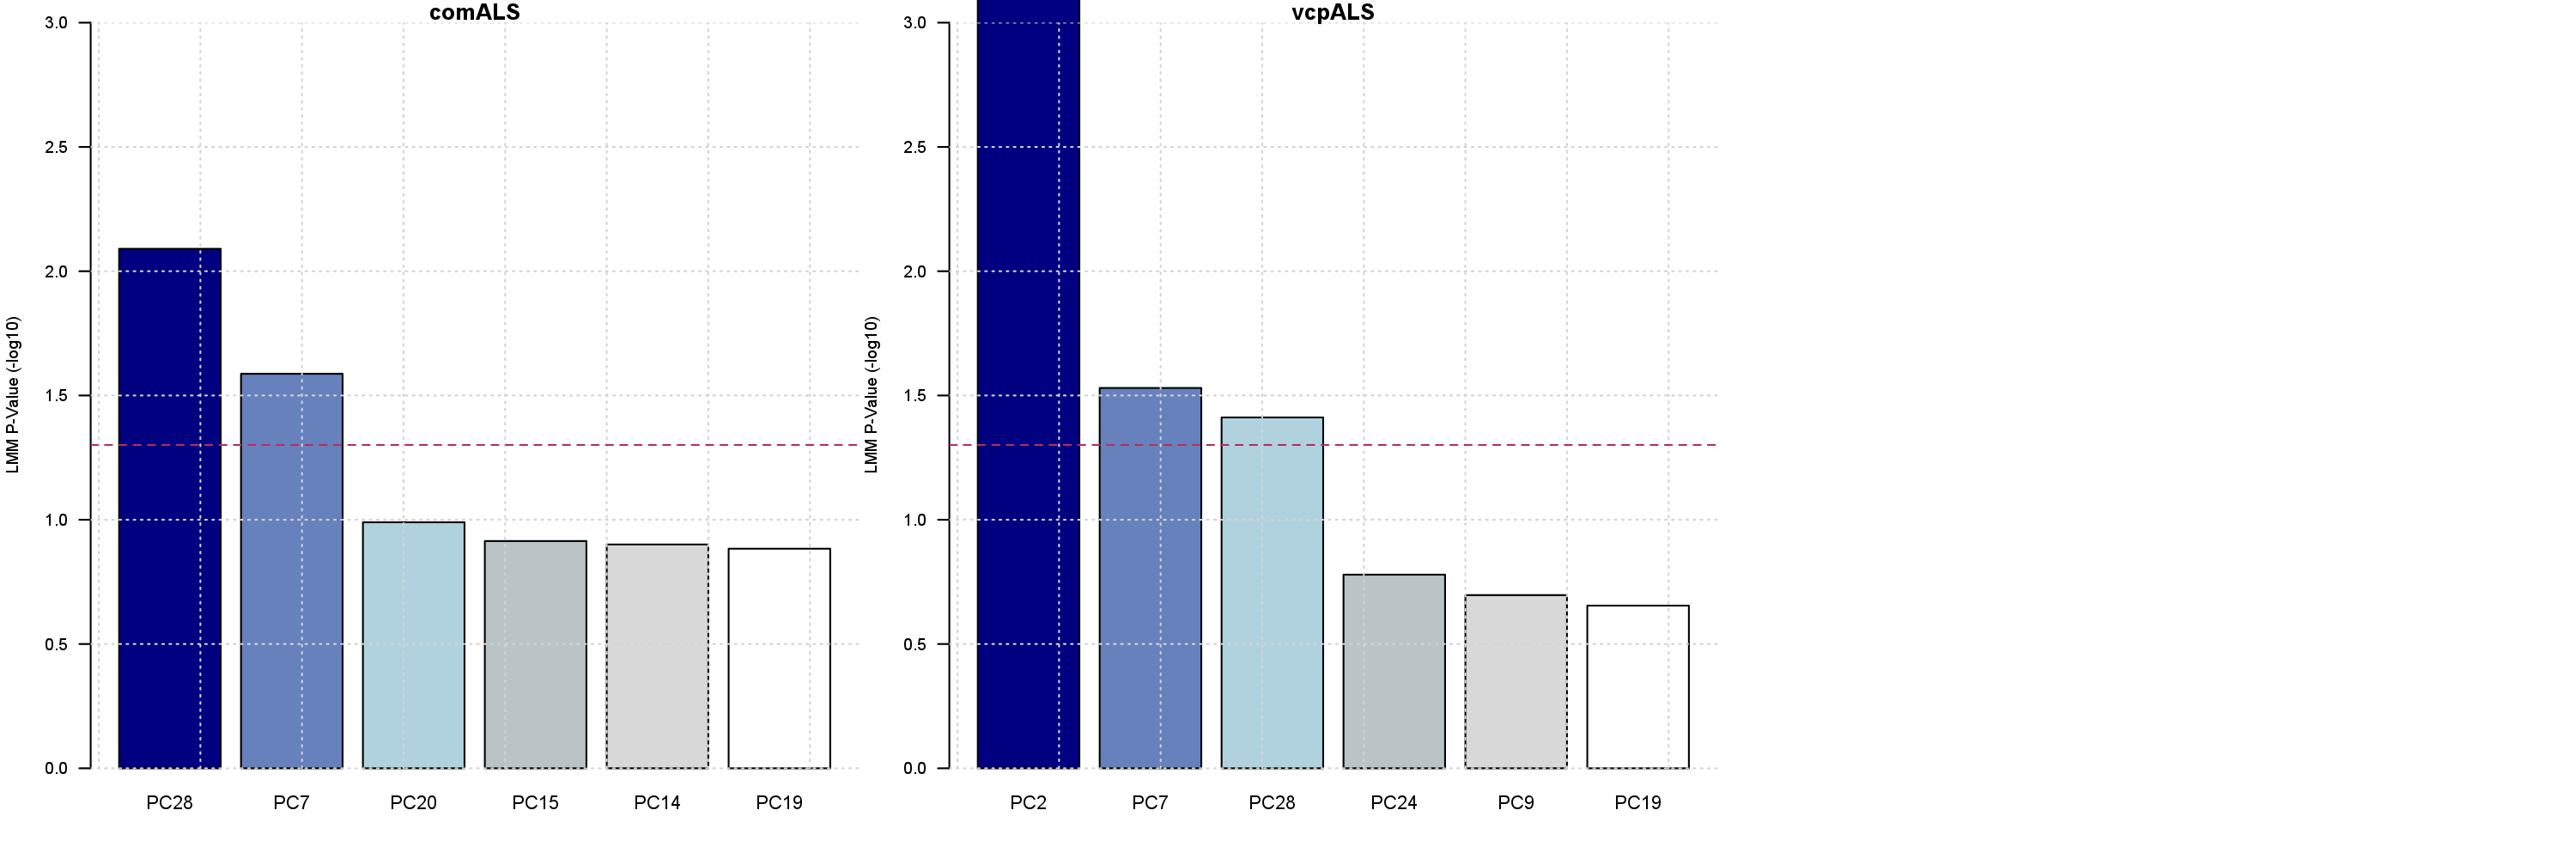

In [33]:
%%R -w 15 -h 5 --units in -r 200
pal <- colorRampPalette(c("white","grey", "lightblue","navy"))

par(mar=c(4,4,1,0),mfrow=c(1,3))
mytests                   <- -log10(test_ALS$Pvalue)
names(mytests)            <- paste("PC",c(1:ncomp),sep="")
mytests                   <- sort(mytests,decreasing=TRUE)[c(1:6)]
barplot(mytests,col=rev(pal(length(mytests))),las=1,ylim=c(0,3),ylab="LMM P-Value (-log10)",
        cex.axis=0.85,cex.names=1.0,cex.lab=0.85,main='comALS')
grid()
abline(h=-log10(0.05),lty=2,col='maroon')


mytests                   <- -log10(test_VCP$Pvalue)
names(mytests)            <- paste("PC",c(1:ncomp),sep="")
mytests                   <- sort(mytests,decreasing=TRUE)[c(1:6)]
barplot(mytests,col=rev(pal(length(mytests))),las=1,ylim=c(0,3),ylab="LMM P-Value (-log10)",
        cex.axis=0.85,cex.names=1.0,cex.lab=0.85,main='vcpALS')
grid()
abline(h=-log10(0.05),lty=2,col='maroon')


Saving figure PCA_plot_spMN


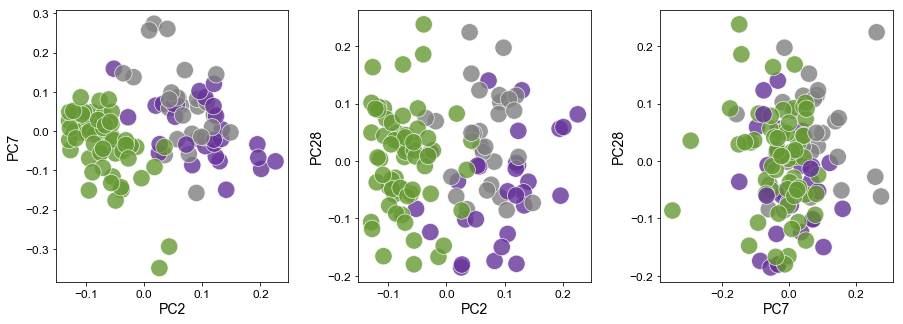

In [34]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = "Arial"
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)

g1=sns.scatterplot(x="PC2", y="PC7", data=subinfo, hue='mutation',
           palette=dict(CTRL='grey', SOD1="#663399", VCP='#669933'),markers=["o", "o", "o"],
                alpha=0.8, ax=axes[0],s=300,legend=False)

#label_point(subinfo['PC2'], subinfo['PC7'], subinfo['animal'], g1) 
g1=sns.scatterplot(x="PC2", y="PC28", data=subinfo, hue='mutation',
           palette=dict(CTRL='grey', SOD1="#663399", VCP='#669933'),markers=["o", "o", "o"],
                alpha=0.8, ax=axes[1],s=300,legend=False)
g1=sns.scatterplot(x="PC7", y="PC28", data=subinfo, hue='mutation',
           palette=dict(CTRL='grey', SOD1="#663399", VCP='#669933'),markers=["o", "o", "o"],
                alpha=0.8, ax=axes[2],s=300,legend=False)
save_fig(fig_id='PCA_plot_spMN', tight_layout=False)


Saving figure Contributions_cells_PCi_spMN


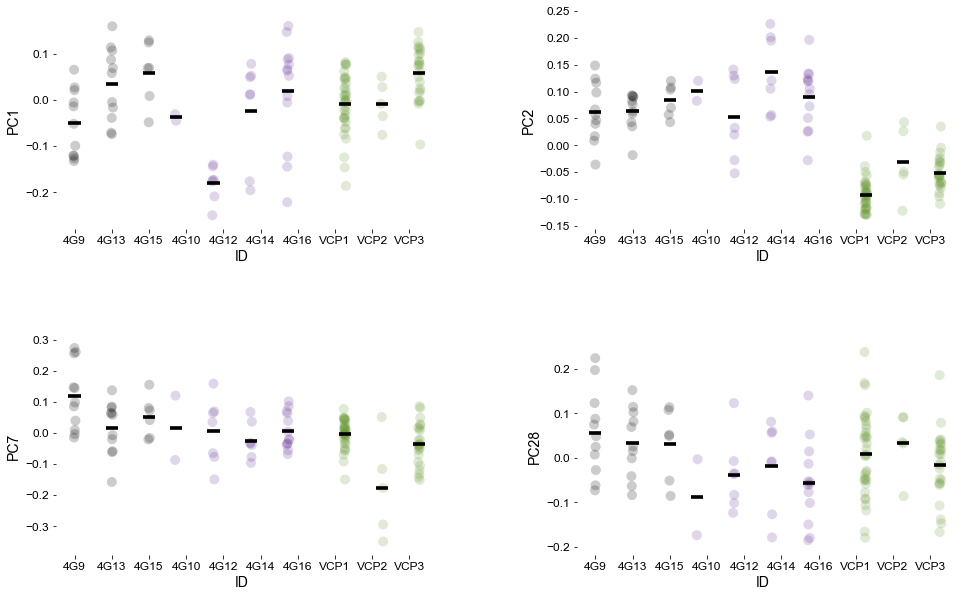

In [35]:
#sns.set(style="whitegrid")  
myorder=['4G9','4G13','4G15','4G10','4G12','4G14','4G16','VCP1','VCP2','VCP3']  

def PlotIndividualValues(myval,myax):
    # Show each observation with a scatterplot  
    gs=sns.stripplot(x="ID", y=myval, hue="mutation", s=10, 
                  data=subinfo, dodge=True, jitter=True,
                  palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),order=myorder,
                  alpha=.2, zorder=1,ax=myax)
    gs.legend_.remove()
    # Show the conditional means 
    gs=sns.pointplot(x="ID", y=myval, hue="mutation",s=14,
                  data=subinfo, dodge=.532, join=False,  
                  palette=dict(CTRL='black', SOD1="black", VCP='black'),order=myorder,
                  markers="_", scale=1.8, ci=None,ax=myax)
    gs.legend_.remove()

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.5)
sns.despine(bottom=True, left=True)  

PlotIndividualValues(myval='PC1',myax=axes[0,0])
PlotIndividualValues(myval='PC2',myax=axes[0,1])
PlotIndividualValues(myval='PC7',myax=axes[1,0])
PlotIndividualValues(myval='PC28',myax=axes[1,1])

save_fig(fig_id='Contributions_cells_PCi_spMN', tight_layout=False)

Saving figure Distribution_PCi_spMN_1


<Figure size 432x288 with 0 Axes>

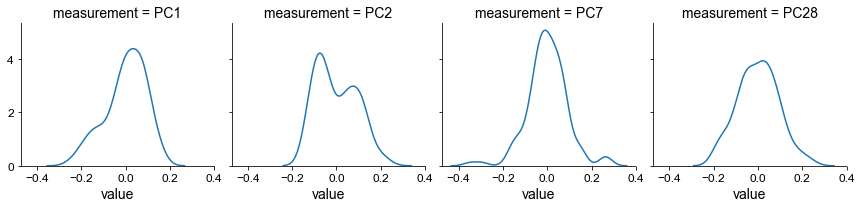

In [36]:
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.5)
melted_dat=pd.melt(subinfo[['mutation','PC1','PC2','PC7','PC28']],"mutation", var_name="measurement")
g = sns.FacetGrid(melted_dat, col='measurement')
g = (g.map(sns.distplot, "value", hist=False, rug=False))
save_fig(fig_id='Distribution_PCi_spMN_1', tight_layout=False)

### Gaussian mixture modelling



#### GMM on PC2  -- VCP background

Saving figure GMM-PC2_spMN_mouse


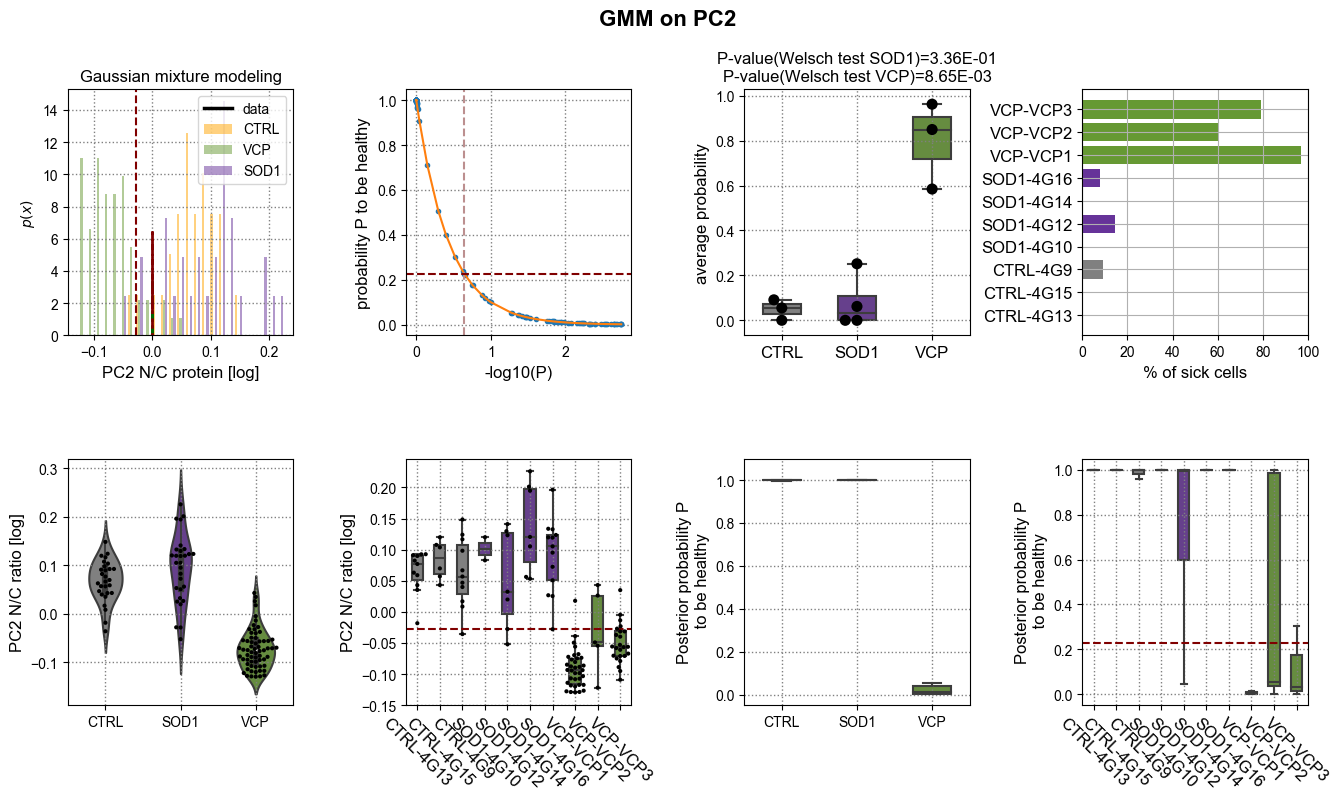

In [50]:

mypc,mylim,mysummary,mytest,myprob=GMM_analysis_mouse_automated(df_sfpqm=subinfo.copy(),AB="PC2",
                                                                      myvar='PC2',ix_mu=0,ix_ct=1,
                                            limangle=45,fst=12,batch=False,colCT='#56B4E9',colALS='#E69F00',
                       title='GMM on PC2',Plot=True)
subinfo['test_PC2']=mytest;
subinfo['prob_PC2']=1-myprob;
subinfo['severity_PC2']=-np.log10(myprob);
info['frac_GMM_PC2']=mysummary['fraction'];
info['prob_GMM_PC2']=mysummary['avg_prob'];

save_fig(fig_id='GMM-PC2_spMN_mouse', tight_layout=False)

Saving figure GMM_PC2_metrics2


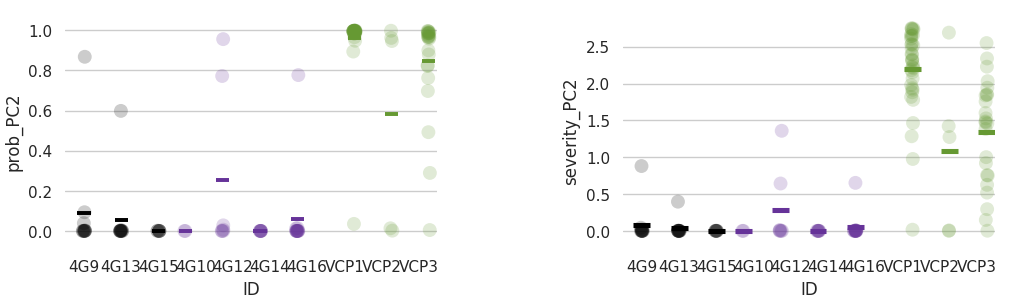

In [51]:
sns.set(style="whitegrid")  
iris = sns.load_dataset("iris")  
myorder=['4G9','4G13','4G15','4G10','4G12','4G14','4G16','VCP1','VCP2','VCP3']  


f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
sns.despine(bottom=True, left=True)  
  
# Show each observation with a scatterplot  
gs=sns.stripplot(x="ID", y="prob_PC2", hue="mutation", s=10, 
              data=subinfo, dodge=True, jitter=True,
              palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),
              alpha=.2, zorder=1,ax=axes[0],order=myorder)  
gs.legend_.remove()
# Show the conditional means  
gs=sns.pointplot(x="ID", y="prob_PC2", hue="mutation",  
              legend=False,s=14,
              data=subinfo, dodge=.532, join=False,  
              palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),
              markers="_", scale=1.4, ci=None,ax=axes[0],order=myorder)  
gs.legend_.remove()
# Show each observation with a scatterplot  
gs=sns.stripplot(x="ID", y="severity_PC2", hue="mutation", s=10, 
              data=subinfo, dodge=True, jitter=True,
              palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),
              alpha=.2, zorder=1,ax=axes[1],order=myorder)  
gs.legend_.remove()  
# Show the conditional means  
gs=sns.pointplot(x="ID", y="severity_PC2", hue="mutation",  
              legend=False,s=14,
              data=subinfo, dodge=.532, join=False,  
              palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),
              markers="_", scale=1.8, ci=None,ax=axes[1],order=myorder)  

gs.legend_.remove()

save_fig(fig_id='GMM_PC2_metrics2', tight_layout=False)
plt.style.use('default')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = "Arial"

#### GMM-PC2,PC7

Saving figure GMM-PC2-7_spMN_mouse


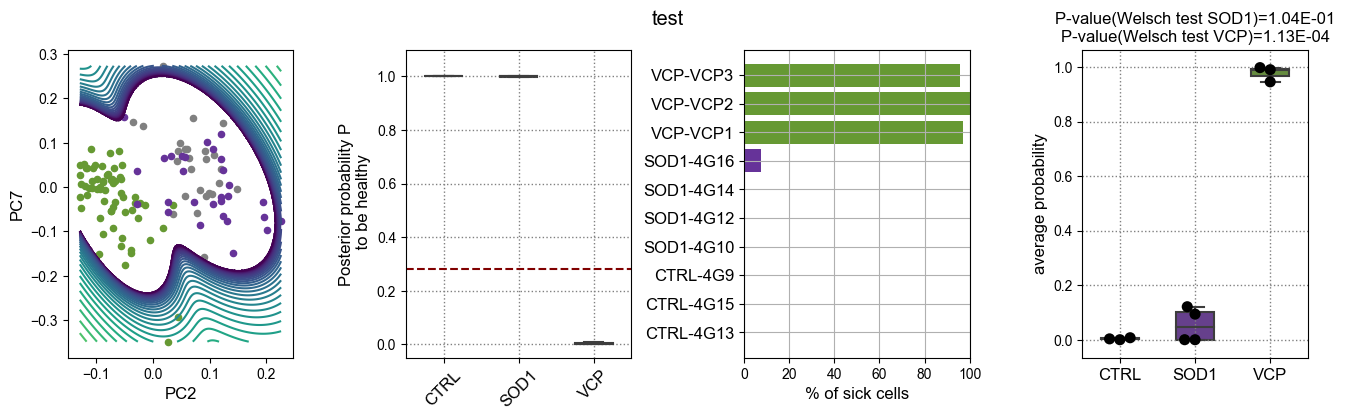

In [54]:
plt.style.use('default')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = "Arial"
info.index=info['ID']
mypc,mylim,mysummary,mytest,myprob=GMM_analysis_mouse_automated_mv(df_sfpqm=subinfo.copy(),AB="PC2 and PC7",myvar=['PC2','PC7'],
                                            limangle=85,fst=12,batch=False,
                       title='test',Plot=True)
subinfo['test_PC2-7']=mytest;
subinfo['prob_PC2-7']=1-myprob;
subinfo['severity_PC2-7']=-np.log10(myprob);
info['frac_GMM_PC2-7']=mysummary['fraction'];
info['prob_GMM_PC2-7']=mysummary['avg_prob'];

save_fig(fig_id='GMM-PC2-7_spMN_mouse', tight_layout=False)

Saving figure GMM_PC2-7_metrics2


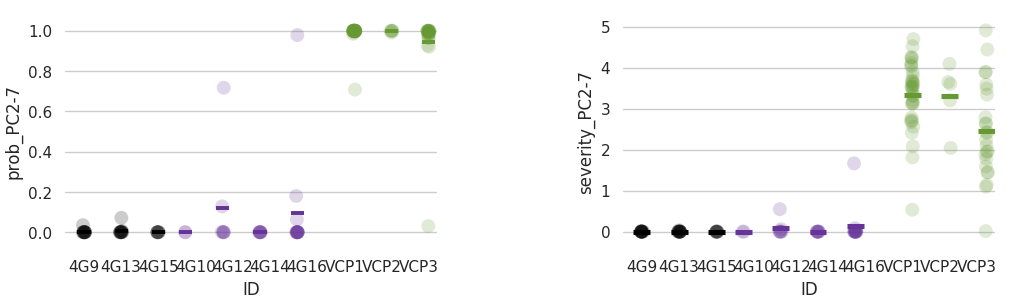

In [55]:
sns.set(style="whitegrid")  
iris = sns.load_dataset("iris")  
myorder=['4G9','4G13','4G15','4G10','4G12','4G14','4G16','VCP1','VCP2','VCP3']  


f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
sns.despine(bottom=True, left=True)  
  
# Show each observation with a scatterplot  
gs=sns.stripplot(x="ID", y="prob_PC2-7", hue="mutation", s=10, 
              data=subinfo, dodge=True, jitter=True,
              palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),
              alpha=.2, zorder=1,ax=axes[0],order=myorder)  
gs.legend_.remove()
# Show the conditional means  
gs=sns.pointplot(x="ID", y="prob_PC2-7", hue="mutation",  
              legend=False,s=14,
              data=subinfo, dodge=.532, join=False,  
              palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),
              markers="_", scale=1.4, ci=None,ax=axes[0],order=myorder)  
gs.legend_.remove()
# Show each observation with a scatterplot  
gs=sns.stripplot(x="ID", y="severity_PC2-7", hue="mutation", s=10, 
              data=subinfo, dodge=True, jitter=True,
              palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),
              alpha=.2, zorder=1,ax=axes[1],order=myorder)  
gs.legend_.remove()  
# Show the conditional means  
gs=sns.pointplot(x="ID", y="severity_PC2-7", hue="mutation",  
              legend=False,s=14,
              data=subinfo, dodge=.532, join=False,  
              palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),
              markers="_", scale=1.8, ci=None,ax=axes[1],order=myorder)  

gs.legend_.remove()

save_fig(fig_id='GMM_PC2-7_metrics2', tight_layout=False)
plt.style.use('default')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = "Arial"

#### GMM on PC28  to extract proportion of sick cells 

Saving figure GMM-PC28_spMN_mouse


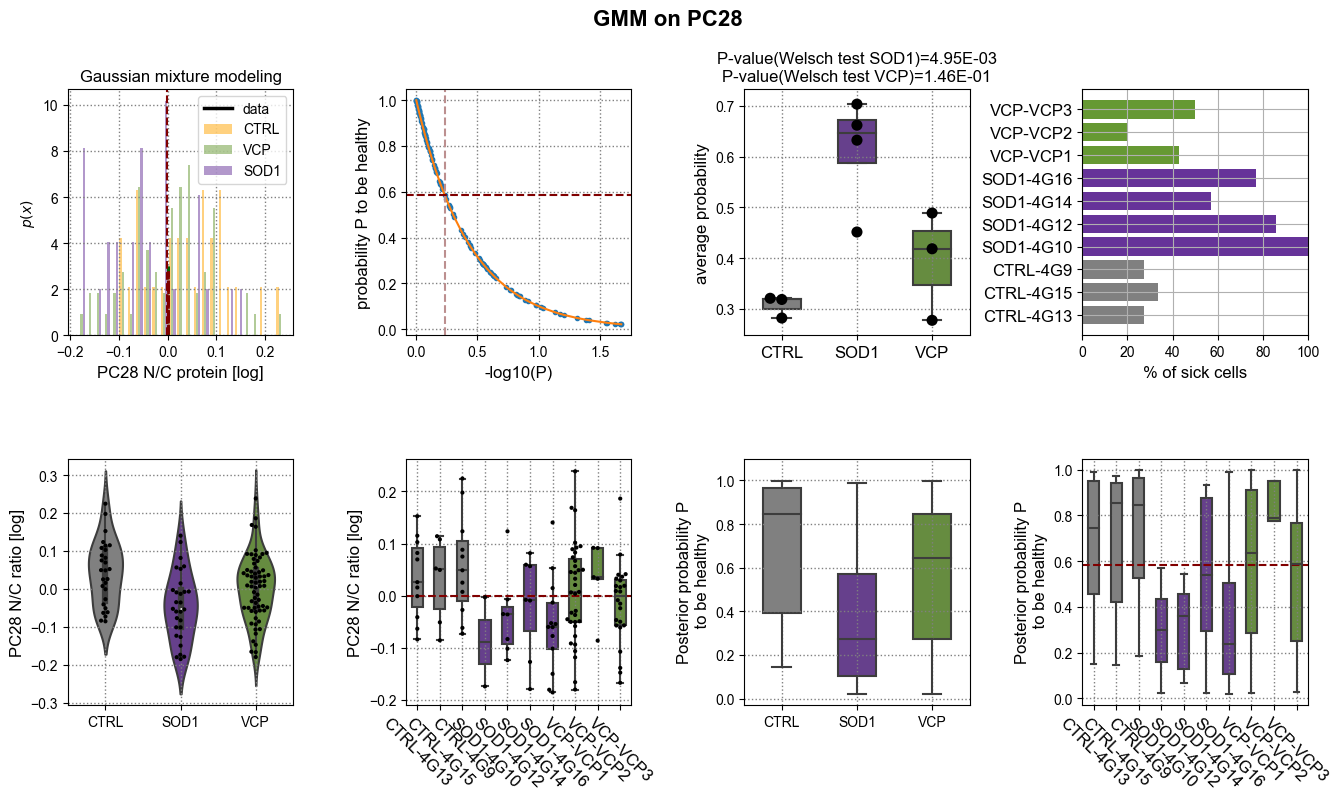

In [56]:
plt.style.use('default')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = "Arial"
info.index=info['ID']
mypc,mylim,mysummary,mytest,myprob=GMM_analysis_mouse_automated(df_sfpqm=subinfo.copy(),AB="PC28",
                                                                      myvar='PC28',ix_mu=0,ix_ct=1,
                                            limangle=78,fst=12,batch=False,colCT='#56B4E9',colALS='#E69F00',
                       title='GMM on PC28',Plot=True)
subinfo['test_PC28']=mytest;
subinfo['prob_PC28']=1-myprob;
subinfo['severity_PC28']=-np.log10(myprob);
info['frac_GMM_PC28']=mysummary['fraction'];
info['prob_GMM_PC28']=mysummary['avg_prob'];

save_fig(fig_id='GMM-PC28_spMN_mouse', tight_layout=False)

Saving figure GMM_PC28_metrics2


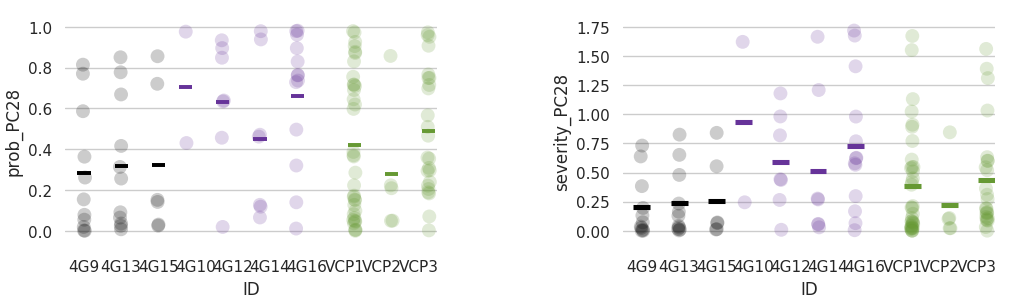

In [57]:
sns.set(style="whitegrid")  
iris = sns.load_dataset("iris")  
myorder=['4G9','4G13','4G15','4G10','4G12','4G14','4G16','VCP1','VCP2','VCP3']  


f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
sns.despine(bottom=True, left=True)  
  
# Show each observation with a scatterplot  
gs=sns.stripplot(x="ID", y="prob_PC28", hue="mutation", s=10, 
              data=subinfo, dodge=True, jitter=True,
              palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),
              alpha=.2, zorder=1,ax=axes[0],order=myorder)  
gs.legend_.remove()
# Show the conditional means  
gs=sns.pointplot(x="ID", y="prob_PC28", hue="mutation",  
              legend=False,s=14,
              data=subinfo, dodge=.532, join=False,  
              palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),
              markers="_", scale=1.4, ci=None,ax=axes[0],order=myorder)  
gs.legend_.remove()
# Show each observation with a scatterplot  
gs=sns.stripplot(x="ID", y="severity_PC28", hue="mutation", s=10, 
              data=subinfo, dodge=True, jitter=True,
              palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),
              alpha=.2, zorder=1,ax=axes[1],order=myorder)  
gs.legend_.remove()  
# Show the conditional means  
gs=sns.pointplot(x="ID", y="severity_PC28", hue="mutation",  
              legend=False,s=14,
              data=subinfo, dodge=.532, join=False,  
              palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),
              markers="_", scale=1.8, ci=None,ax=axes[1],order=myorder)  

gs.legend_.remove()

save_fig(fig_id='GMM_PC28_metrics2', tight_layout=False)
plt.style.use('default')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = "Arial"

#### GMM-PC7,PC28

Saving figure GMM-PC7-28_spMN_mouse


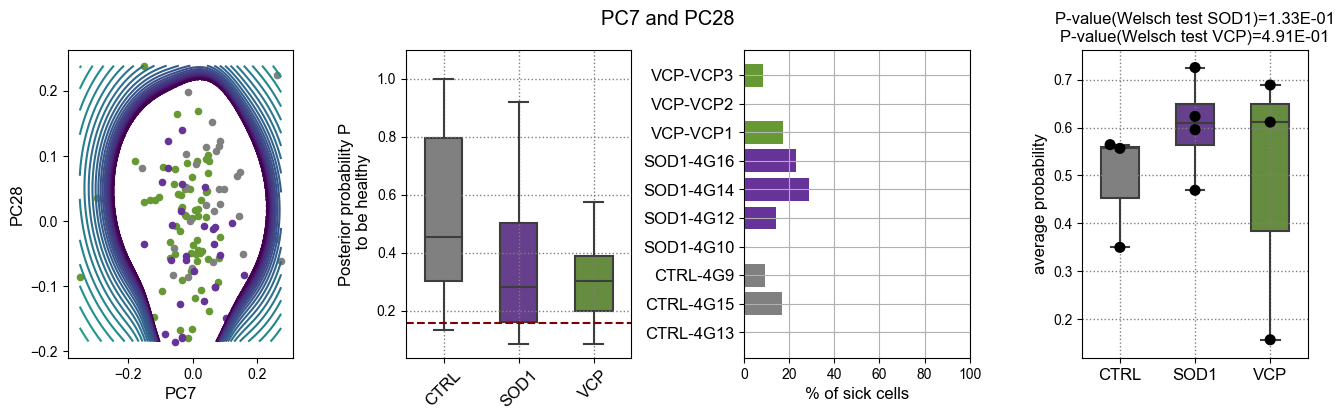

In [58]:
plt.style.use('default')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = "Arial"
info.index=info['ID']
mypc,mylim,mysummary,mytest,myprob=GMM_analysis_mouse_automated_mv(df_sfpqm=subinfo.copy(),AB="PC7 and PC28",
                                                                   myvar=['PC7','PC28'],
                                            limangle=60,fst=12,batch=False,
                       title='PC7 and PC28',Plot=True)
subinfo['test_PC7-28']=mytest;
subinfo['prob_PC7-28']=1-myprob;
subinfo['severity_PC7-28']=-np.log10(myprob);
info['frac_GMM_PC7-28']=mysummary['fraction'];
info['prob_GMM_PC7-28']=mysummary['avg_prob'];

save_fig(fig_id='GMM-PC7-28_spMN_mouse', tight_layout=False)

Saving figure GMM_PC7-28_metrics2


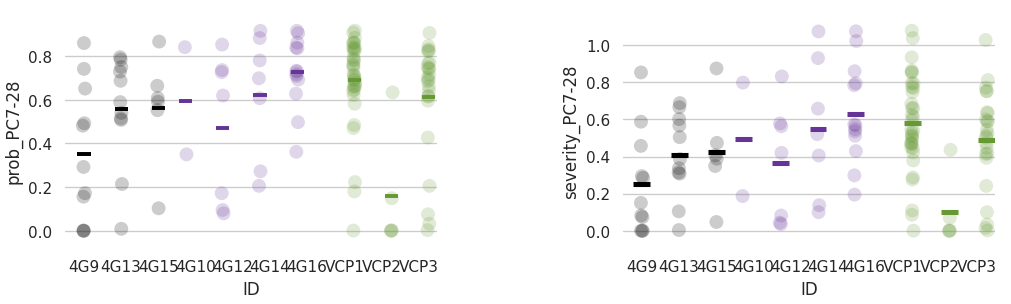

In [59]:
sns.set(style="whitegrid")  
iris = sns.load_dataset("iris")  
myorder=['4G9','4G13','4G15','4G10','4G12','4G14','4G16','VCP1','VCP2','VCP3']  


f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
sns.despine(bottom=True, left=True)  
  
# Show each observation with a scatterplot  
gs=sns.stripplot(x="ID", y="prob_PC7-28", hue="mutation", s=10, 
              data=subinfo, dodge=True, jitter=True,
              palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),
              alpha=.2, zorder=1,ax=axes[0],order=myorder)  
gs.legend_.remove()
# Show the conditional means  
gs=sns.pointplot(x="ID", y="prob_PC7-28", hue="mutation",  
              legend=False,s=14,
              data=subinfo, dodge=.532, join=False,  
              palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),
              markers="_", scale=1.4, ci=None,ax=axes[0],order=myorder)  
gs.legend_.remove()
# Show each observation with a scatterplot  
gs=sns.stripplot(x="ID", y="severity_PC7-28", hue="mutation", s=10, 
              data=subinfo, dodge=True, jitter=True,
              palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),
              alpha=.2, zorder=1,ax=axes[1],order=myorder)  
gs.legend_.remove()  
# Show the conditional means  
gs=sns.pointplot(x="ID", y="severity_PC7-28", hue="mutation",  
              legend=False,s=14,
              data=subinfo, dodge=.532, join=False,  
              palette=dict(CTRL='black', SOD1="#663399", VCP='#669933'),
              markers="_", scale=1.8, ci=None,ax=axes[1],order=myorder)  

gs.legend_.remove()

save_fig(fig_id='GMM_PC7-28_metrics2', tight_layout=False)
plt.style.use('default')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = "Arial"

### Logistic Regression

####  Data preprocessing --  Prepare for machine learning

In [69]:
%%R -i subinfo -i subinfo_full -i mat -i mat_full -o info_ML -o mat_sub -o mat_tot -o mat_tot_full -o subinfo_full -o subinfo
#Here I remove the SOD1 in order to compare with and without the SOD1
mat_sub               <- mat[,subinfo$mutation!='SOD1']
subinfo$ismutant      <- ifelse(subinfo$mutation=="CTRL",0,1)
info_ML               <- subinfo[subinfo$mutation!='SOD1',]
mat_sub               <- t(mat_sub)
mat_tot               <- t(mat)
mat_tot_full          <- t(mat_full)
subinfo_full$ismutant <- ifelse(subinfo_full$mutation=="CTRL",0,1)

In [70]:
%%R -i subinfo_full -i mat_full -o mat_tot_full -o subinfo_full
print(sum(is.na(mat_full)))
print(dim(mat_full))
myavg<-apply(mat_full,1,function(Z)return(mean(Z,na.rm=T)))
ixr  <-which(apply(is.na(mat_full),1,sum)>0)
ixc  <-which(apply(is.na(mat_full),2,sum)>0)             
mat_full[ixr,ixc]<-myavg[ixc]         
mat_tot_full          <- t(mat_full)
subinfo_full$ismutant <- ifelse(subinfo_full$mutation=="CTRL",0,1)

[1] 0
[1] 750 210


In [71]:
X_tot_full = mat_tot_full
y_tot_full = subinfo_full['ismutant'].copy()

In [156]:
X_sub = mat_sub
y_sub = info_ML['ismutant'].copy()
stratification_sub=info_ML['mutation']+'-'+info_ML['ID']
# preprocess dataset, split into training and test part
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=.3,
                                                                    stratify=stratification_sub,
                                                                   random_state = np.random.RandomState(seed=10))
scaler_sub = StandardScaler()
# Don't cheat - fit only on training data
scaler_sub.fit(X_sub_train)
X_sub_train = scaler_sub.transform(X_sub_train)
# apply same transformation to test data
X_sub_test = scaler_sub.transform(X_sub_test)


In [157]:
X_tot = mat_tot
y_tot = subinfo['ismutant'].copy()
stratification_tot=subinfo['mutation']+'-'+subinfo['ID']
# preprocess dataset, split into training and test part
X_tot_train, X_tot_test, y_tot_train, y_tot_test = train_test_split(X_tot, y_tot, test_size=.3,
                                                                    stratify=stratification_tot,
                                                                   random_state = np.random.RandomState(seed=10))
scaler_tot = StandardScaler()
# Don't cheat - fit only on training data
scaler_tot.fit(X_tot_train)
X_tot_train = scaler_tot.transform(X_tot_train)
# apply same transformation to test data
X_tot_test = scaler_tot.transform(X_tot_test)

In [158]:
y_sub_train.sum()/y_sub_train.shape[0]

0.6875

In [159]:
y_tot_train.sum()/y_tot_train.shape[0]

0.7619047619047619

In [160]:
y_sub_test.sum()/y_sub_test.shape[0]

0.7142857142857143

In [161]:
y_tot_test.sum()/y_tot_test.shape[0]

0.7837837837837838

### Logistic regression (LR)

In [162]:
log_reg = LogisticRegression(solver='lbfgs',n_jobs=-1,max_iter=500,random_state = np.random.RandomState(seed=10))
myCs = np.concatenate([np.logspace(-5, 0, 10),np.linspace(1.5,10,50)],axis=0)
param_grid = [
 {'C': myCs}
 ]
# The hyperparameter controlling the regularization strength of a Scikit-Learn LogisticRegression model is C. 
# The higher the value of C, the less the model is regularized.
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

#### LR with total data

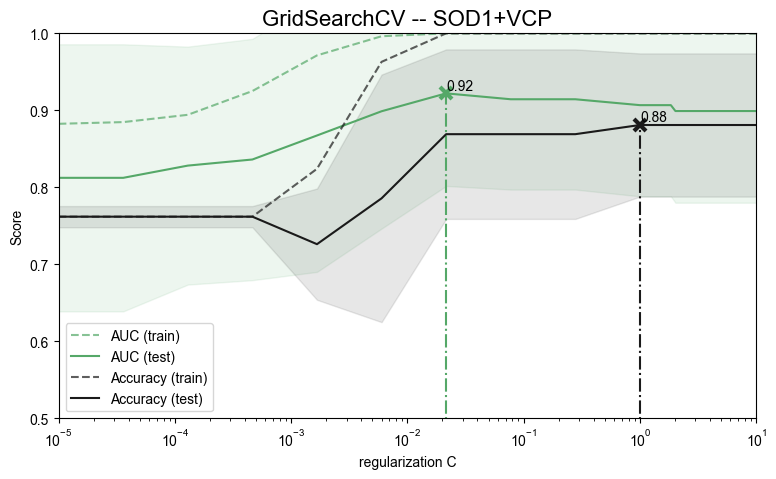

In [163]:
grid_lr_tot = GridSearchCV(log_reg, param_grid, cv=10, verbose=0,scoring=scoring,refit='Accuracy')
grid_lr_tot.fit(X_tot_train, y_tot_train)
results = grid_lr_tot.cv_results_
plt.figure(figsize=(9, 5))
plt.title("GridSearchCV -- SOD1+VCP",fontsize=16)
plt.xlabel("regularization C")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(min(myCs), max(myCs))
ax.set_ylim(0.5, 1)
ax.set_xscale('log')

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [164]:
grid_lr_tot.best_params_['C']

1.0

In [165]:
grid_lr_tot.score(X_tot_test, y_tot_test)

0.918918918918919

Saving figure ROC_LR_with_SOD_spMN_mouse


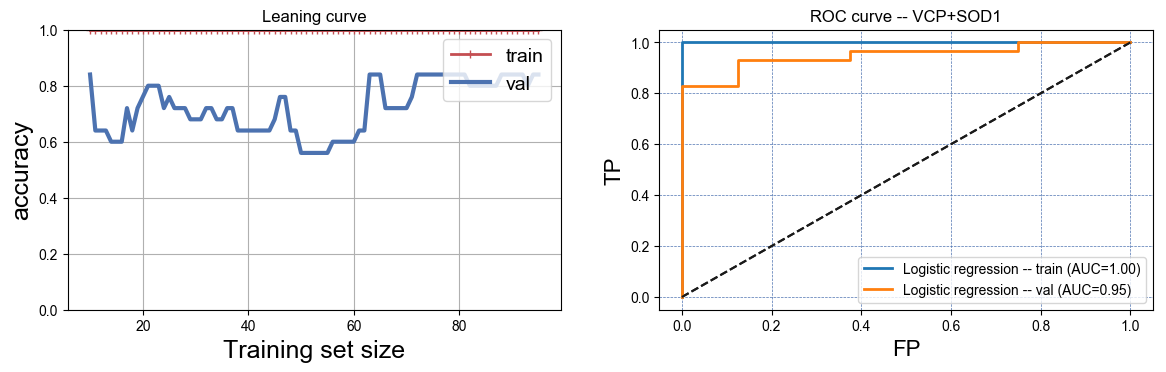

In [166]:
y_tot_scores=grid_lr_tot.predict_proba(X_tot_train)[:,1]    
y_tot_scores_val=grid_lr_tot.predict_proba(X_tot_test)[:,1]  
auc_train_tot=roc_auc_score(y_tot_train, y_tot_scores)
auc_val_tot=roc_auc_score(y_tot_test, y_tot_scores_val)

plt.figure(figsize=(14, 8))
plt.subplot(221)
log_reg_tot = LogisticRegression(solver='lbfgs',n_jobs=4,max_iter=500,C=grid_lr_tot.best_params_['C'])
plot_learning_curves(log_reg_tot, X_tot, y_tot)

plt.subplot(222)  
precisions, recalls, thresholds = precision_recall_curve(y_tot_train, y_tot_scores)
fpr, tpr, thresholds = roc_curve(y_tot_train,y_tot_scores)
fpr_test, tpr_test, thresholds_test = roc_curve(y_tot_test,y_tot_scores_val)
#plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr, tpr, "Logistic regression -- train (AUC="+"%0.2f" % auc_train_tot+")")
plot_roc_curve(fpr_test, tpr_test, "Logistic regression -- val (AUC="+"%0.2f" % auc_val_tot+")")
plt.legend(loc="best")
plt.title('ROC curve -- VCP+SOD1')
save_fig(fig_id='ROC_LR_with_SOD_spMN_mouse', tight_layout=False)

Saving figure LR_result_with_SOD_spMN_mouse


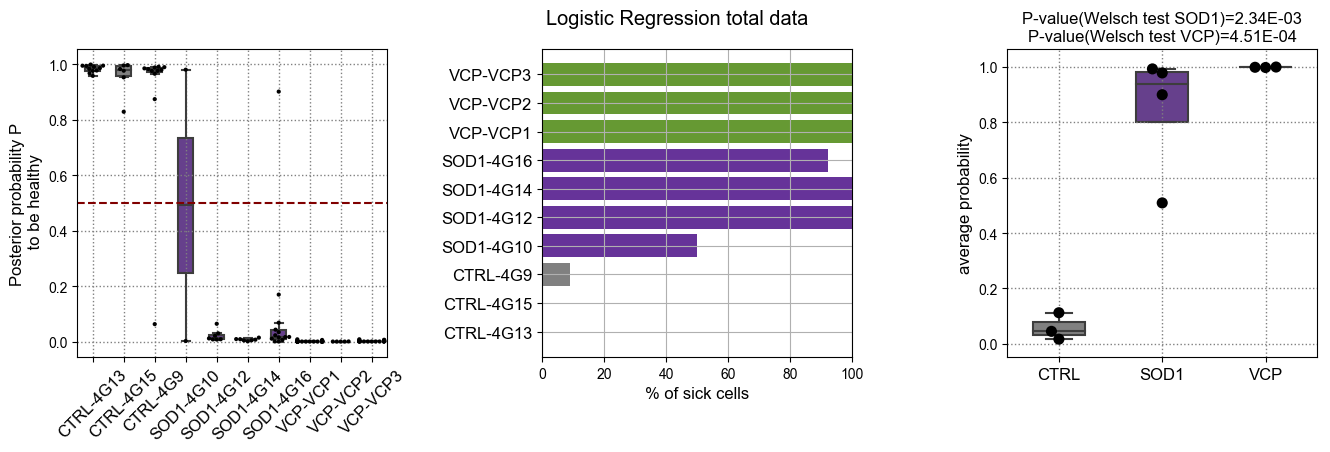

In [167]:
info.index=info['index']
subinfo['prob_LR_tot']=grid_lr_tot.predict_proba(scaler_tot.transform(X_tot))[:,0] 
myLR,mylim,mysummary,mytest,myprob=ML_analysis_updated(myvars='prob_LR_tot',dfc=subinfo.copy(),
                            fst=12,batch=False,limangle=45,title='Logistic Regression total data')

subinfo['test_LR_total']=mytest;
subinfo['prob_LR_total']=1-myprob;
subinfo['severity_LR_total']=-np.log10(myprob);

info['frac_LR_total']=mysummary['fraction'];
info['prob_LR_total']=mysummary['avg_prob'];
save_fig(fig_id='LR_result_with_SOD_spMN_mouse', tight_layout=False)


Saving figure LR_result_full_with_SOD_spMN_mouse


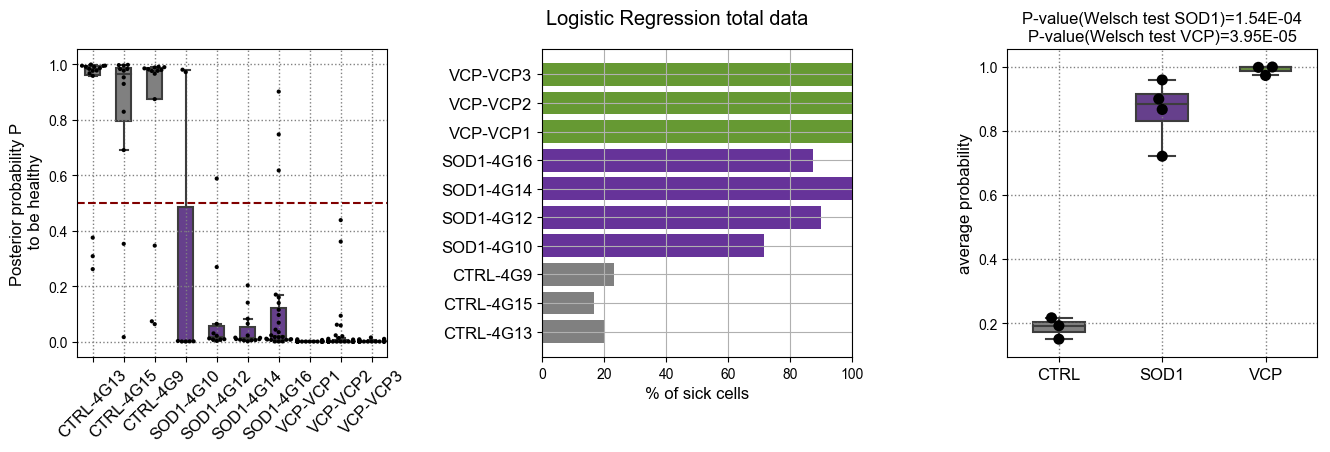

In [168]:
subinfo_full['prob_LR_total']=grid_lr_tot.predict_proba(scaler_tot.transform(X_tot_full))[:,0] 
myLR,mylim,mysummary,mytest,myprob=ML_analysis_updated(myvars='prob_LR_total',dfc=subinfo_full.copy(),
                            fst=12,batch=False,limangle=45,title='Logistic Regression total data')
save_fig(fig_id='LR_result_full_with_SOD_spMN_mouse', tight_layout=False)

subinfo_full['test_LR_total']=mytest;
subinfo_full['prob_LR_total']=1-myprob;
subinfo_full['severity_LR_total']=-np.log10(myprob);


#### LR with VCP data only

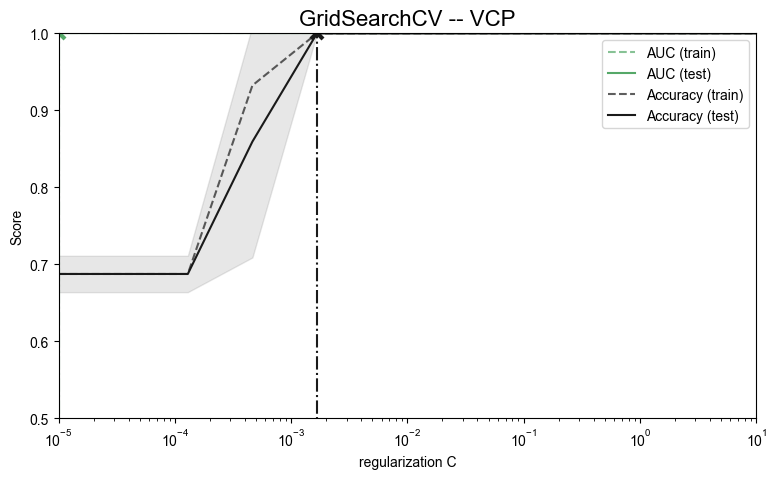

In [169]:
grid_lr_sub = GridSearchCV(log_reg, param_grid, cv=10, verbose=0,scoring=scoring,refit='Accuracy')
grid_lr_sub.fit(X_sub_train, y_sub_train)
results = grid_lr_sub.cv_results_
plt.figure(figsize=(9, 5))
plt.title("GridSearchCV -- VCP",fontsize=16)
plt.xlabel("regularization C")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(min(myCs), max(myCs))
ax.set_ylim(0.5, 1)
ax.set_xscale('log')

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [170]:
grid_lr_sub.best_params_['C']

0.0016681005372000592

In [171]:
grid_lr_sub.score(X_sub_test, y_sub_test)

1.0

Saving figure ROC_LR_wo_SOD_spMN_mouse


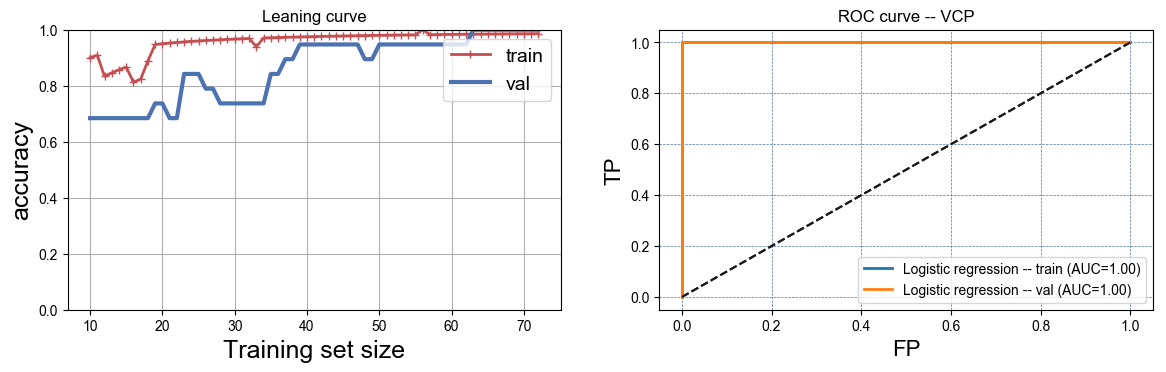

In [172]:
y_sub_scores=grid_lr_sub.predict_proba(X_sub_train)[:,1]    
y_sub_scores_val=grid_lr_sub.predict_proba(X_sub_test)[:,1]  
auc_train_sub=roc_auc_score(y_sub_train, y_sub_scores)
auc_val_sub=roc_auc_score(y_sub_test, y_sub_scores_val)

plt.figure(figsize=(14, 8))
plt.subplot(221)
log_reg_sub = LogisticRegression(solver='lbfgs',n_jobs=4,max_iter=500,C=grid_lr_sub.best_params_['C'])
plot_learning_curves(log_reg_sub, X_sub, y_sub)

plt.subplot(222)  
precisions, recalls, thresholds = precision_recall_curve(y_sub_train, y_sub_scores)
fpr, tpr, thresholds = roc_curve(y_sub_train,y_sub_scores)
fpr_test, tpr_test, thresholds_test = roc_curve(y_sub_test,y_sub_scores_val)
#plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr, tpr, "Logistic regression -- train (AUC="+"%0.2f" % auc_train_sub+")")
plot_roc_curve(fpr_test, tpr_test, "Logistic regression -- val (AUC="+"%0.2f" % auc_val_sub+")")
plt.legend(loc="best")
plt.title('ROC curve -- VCP')
save_fig(fig_id='ROC_LR_wo_SOD_spMN_mouse', tight_layout=False)


Saving figure LR_result_wo_SOD_spMN_mouse


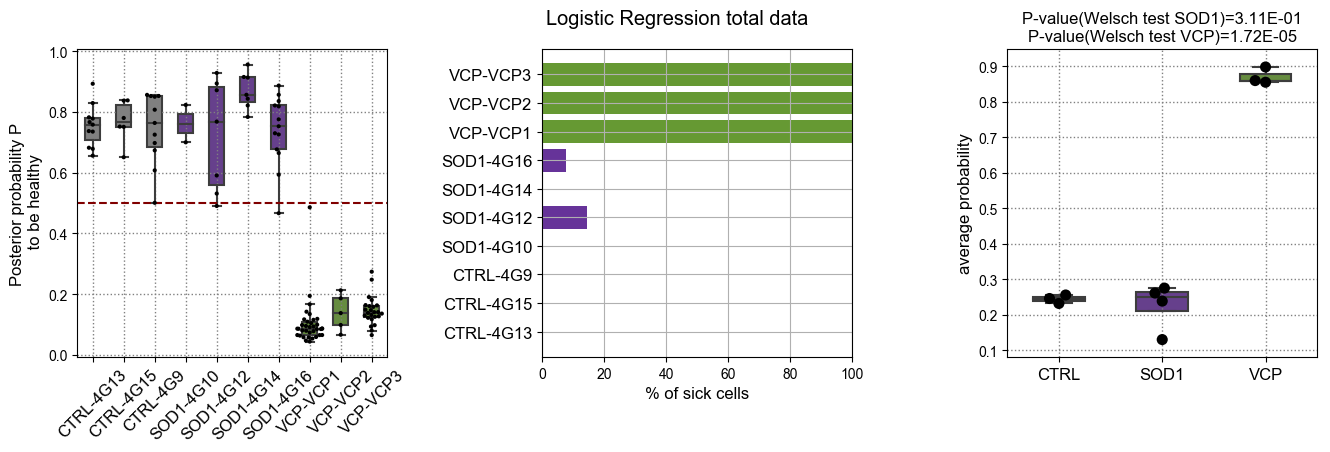

In [173]:
subinfo['prob_LR_sub']=grid_lr_sub.predict_proba(scaler_sub.transform(X_tot))[:,0] 
myLR,mylim,mysummary,mytest,myprob=ML_analysis_updated(myvars='prob_LR_sub',dfc=subinfo.copy(),
                            fst=12,batch=False,limangle=45,title='Logistic Regression total data')

subinfo['test_LR_sub']=mytest;
subinfo['prob_LR_sub']=1-myprob;
subinfo['severity_LR_sub']=-np.log10(myprob);

info['frac_LR_sub']=mysummary['fraction'];
info['prob_LR_sub']=mysummary['avg_prob'];
save_fig(fig_id='LR_result_wo_SOD_spMN_mouse', tight_layout=False)


Saving figure LR_result_full_wo_SOD_spMN_mouse


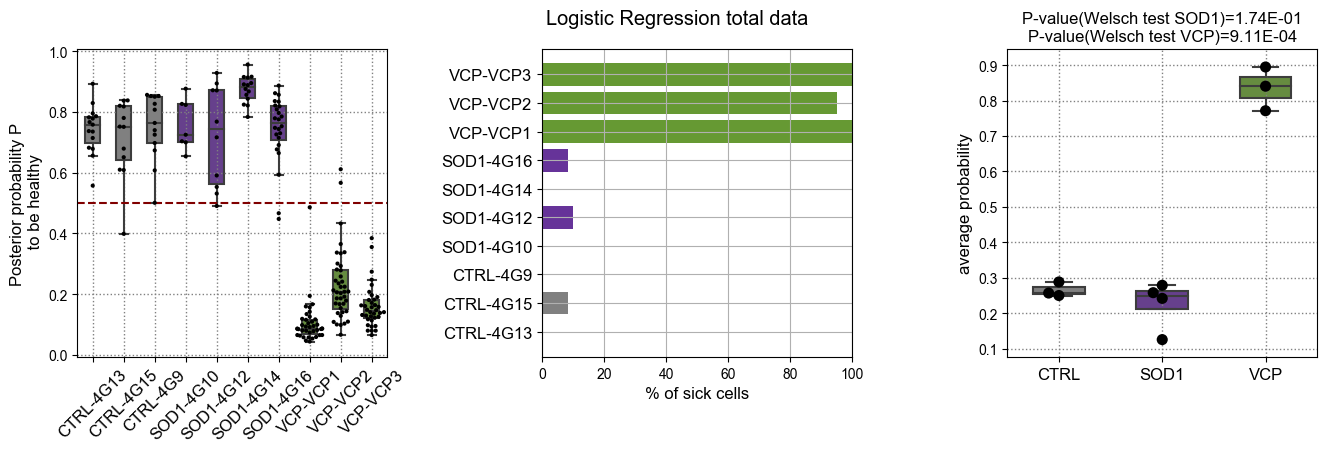

In [174]:
subinfo_full['prob_LR_sub']=grid_lr_sub.predict_proba(scaler_sub.transform(X_tot_full))[:,0]  
myLR,mylim,mysummary,mytest,myprob=ML_analysis_updated(myvars='prob_LR_sub',dfc=subinfo_full.copy(),
                            fst=12,batch=False,limangle=45,title='Logistic Regression total data')
save_fig(fig_id='LR_result_full_wo_SOD_spMN_mouse', tight_layout=False)

subinfo_full['test_LR_sub']=mytest;
subinfo_full['prob_LR_sub']=1-myprob;
subinfo_full['severity_LR_sub']=-np.log10(myprob);


## Neural Network

### Total data

In [175]:
from sklearn.neural_network import MLPClassifier
#PARAMETERS of the MLP
# 1) Alpha == regularization
# 2) Architechture (number of neurons in hidden layer; number of layers --here only one hidden layer)
# 3) Solver ={lbfgs,adam,sgd}
# 4) Activation ={logistic,tanh,relu}
param_grid = [
 {'alpha': np.logspace(-5, 3, 5),'hidden_layer_sizes':np.arange(3,21),'solver':['sgd','adam','lbfgs'],'activation':['logistic','tanh','relu']}
 ]

clf = MLPClassifier(random_state=10)
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [176]:
grid_nn_tot = GridSearchCV(clf, param_grid, cv=5, verbose=1,scoring=scoring,refit='Accuracy')
grid_nn_tot.fit(X_tot_train, y_tot_train)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 4050 out of 4050 | elapsed:  4.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03]), 'hidden_layer_sizes': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20]), 'solver': ['sgd', 'adam', 'lbfgs'], 'activation': ['logistic', 'tanh', 'relu']}],
       pre_dispatch='2*n_jobs', refit='Accuracy',
       return_train_score='warn',
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [177]:
grid_nn_tot.best_params_

{'activation': 'relu',
 'alpha': 1e-05,
 'hidden_layer_sizes': 19,
 'solver': 'adam'}

Saving figure ROC_NN_with_SOD_spMN_mouse


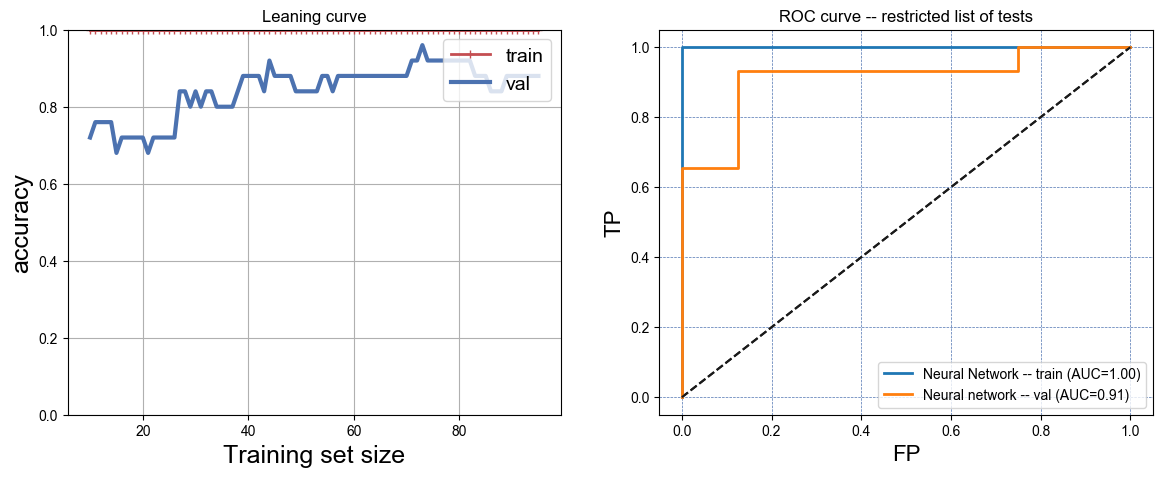

In [178]:
y_scores_nn_tot=grid_nn_tot.predict_proba(X_tot_train)[:,1]    
y_scores_nn_val_tot=grid_nn_tot.predict_proba(X_tot_test)[:,1] 
auc_train_tot_nn=roc_auc_score(y_tot_train, y_scores_nn_tot)
auc_val_tot_nn=roc_auc_score(y_tot_test, y_scores_nn_val_tot)

plt.figure(figsize=(14, 5))
plt.subplot(121)

param_grid = [
 {'alpha': np.logspace(-5, 3, 5),'hidden_layer_sizes':np.arange(3,21),'solver':['sgd','adam','lbfgs'],'activation':['logistic','tanh','relu']}
 ]

clf = MLPClassifier(random_state=1,alpha=grid_nn_tot.best_params_['alpha'],
                    hidden_layer_sizes=(grid_nn_tot.best_params_['hidden_layer_sizes']),
                    solver=grid_nn_tot.best_params_['solver'],
                    activation=grid_nn_tot.best_params_['activation'])

plot_learning_curves(clf, X_tot, y_tot)

plt.subplot(122)
precisions, recalls, thresholds = precision_recall_curve(y_tot_train, y_scores_nn_tot)
fpr_nn, tpr_nn, thresholds = roc_curve(y_tot_train,y_scores_nn_tot)
fpr_nn_test, tpr_nn_test, thresholds_test = roc_curve(y_tot_test,y_scores_nn_val_tot)
#plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_nn, tpr_nn, "Neural Network -- train (AUC="+"%0.2f" % auc_train_tot_nn+")")
plot_roc_curve(fpr_nn_test, tpr_nn_test, "Neural network -- val (AUC="+"%0.2f" % auc_val_tot_nn+")")
plt.legend(loc="best")
plt.title('ROC curve -- restricted list of tests')
save_fig(fig_id='ROC_NN_with_SOD_spMN_mouse', tight_layout=False)


Saving figure NN_result_with_SOD_spMN_mouse


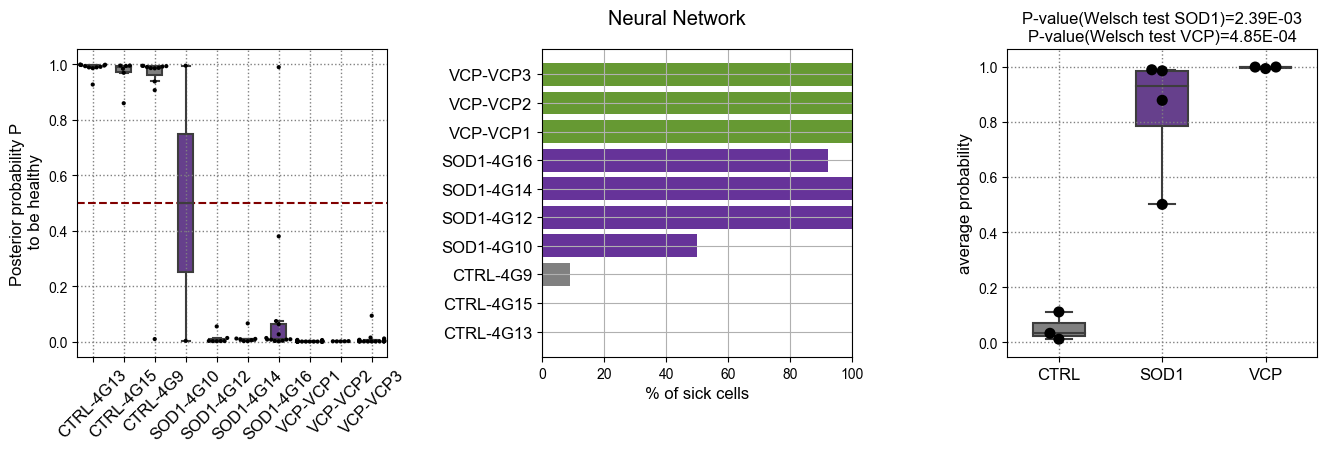

In [179]:
subinfo['prob_NN_tot']=grid_nn_tot.predict_proba(scaler_tot.transform(X_tot))[:,0] 
sfpq_NN,mylim,mysummary,mytest,myprob=ML_analysis_updated(myvars='prob_NN_tot',dfc=subinfo.copy(),
                            fst=12,batch=False,limangle=45,title='Neural Network')

subinfo['test_NN_tot']=mytest;
subinfo['prob_NN_tot']=1-myprob;
subinfo['severity_NN_tot']=-np.log10(myprob);

info['frac_NN_tot']=mysummary['fraction'];
info['prob_NN_tot']=mysummary['avg_prob'];
save_fig(fig_id='NN_result_with_SOD_spMN_mouse', tight_layout=False)


Saving figure LR_result_full_wo_SOD_spMN_mouse


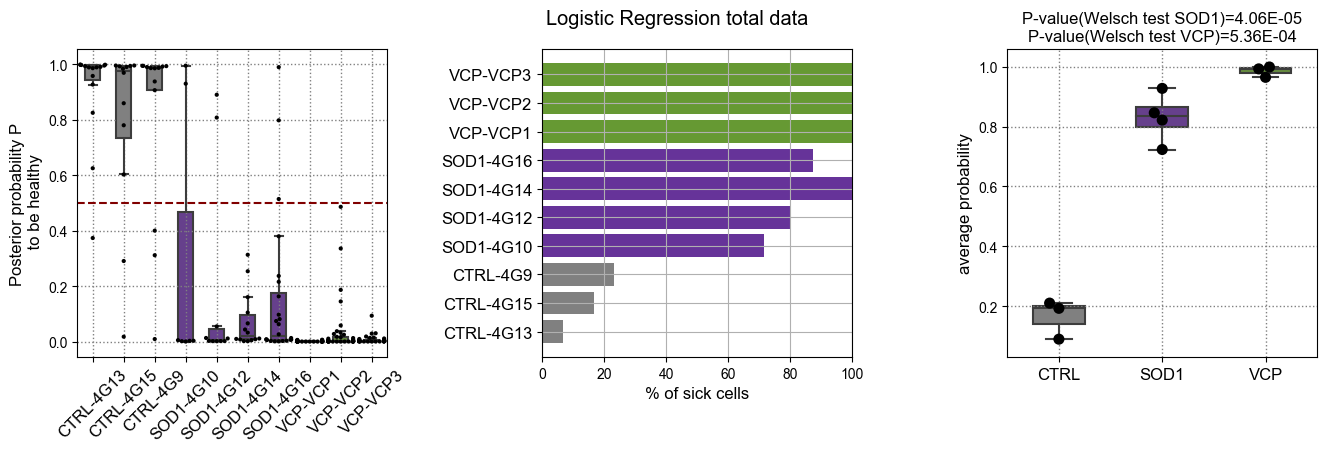

In [180]:
subinfo_full['prob_NN_tot']=grid_nn_tot.predict_proba(scaler_tot.transform(X_tot_full))[:,0] 
myLR,mylim,mysummary,mytest,myprob=ML_analysis_updated(myvars='prob_NN_tot',dfc=subinfo_full.copy(),
                            fst=12,batch=False,limangle=45,title='Logistic Regression total data')
save_fig(fig_id='LR_result_full_wo_SOD_spMN_mouse', tight_layout=False)
subinfo_full['test_NN_tot']=mytest;
subinfo_full['prob_NN_tot']=1-myprob;
subinfo_full['severity_NN_tot']=-np.log10(myprob);


## Neural Network only with VCP

In [181]:
param_grid = [
 {'alpha': np.logspace(-5, 3, 5),'hidden_layer_sizes':np.arange(3,21),'solver':['sgd','adam','lbfgs'],'activation':['logistic','tanh','relu']}
 ]

clf = MLPClassifier(random_state=10)
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
grid_nn_sub = GridSearchCV(clf, param_grid, cv=5, verbose=1,scoring=scoring,refit='Accuracy')
grid_nn_sub.fit(X_sub_train, y_sub_train)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 4050 out of 4050 | elapsed:  3.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03]), 'hidden_layer_sizes': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20]), 'solver': ['sgd', 'adam', 'lbfgs'], 'activation': ['logistic', 'tanh', 'relu']}],
       pre_dispatch='2*n_jobs', refit='Accuracy',
       return_train_score='warn',
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [182]:
grid_nn_sub.best_params_

{'activation': 'logistic',
 'alpha': 1e-05,
 'hidden_layer_sizes': 3,
 'solver': 'sgd'}

Saving figure ROC_NN_wo_SOD_spMN_mouse


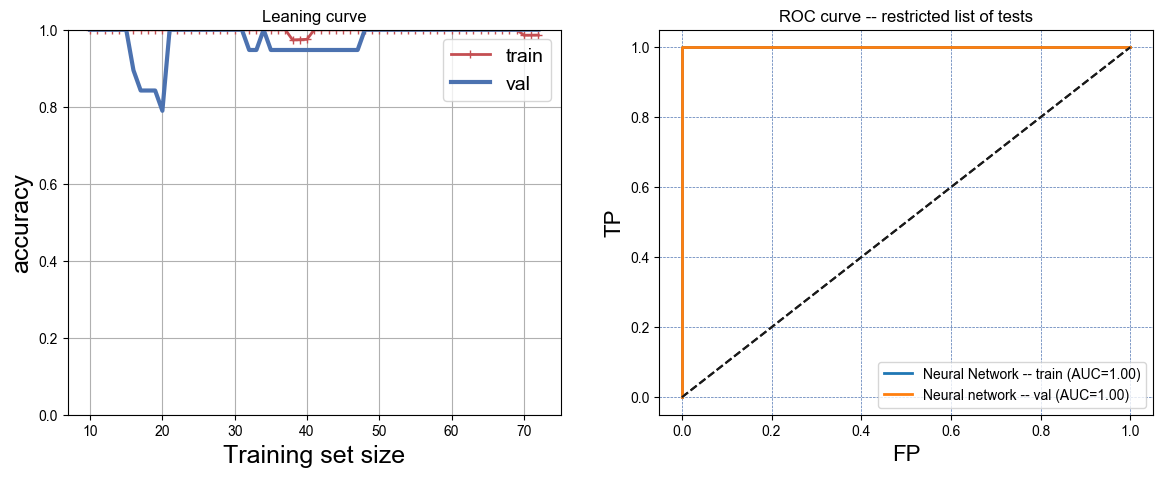

In [183]:
y_scores_nn_sub=grid_nn_sub.predict_proba(X_sub_train)[:,1]    
y_scores_nn_val_sub=grid_nn_sub.predict_proba(X_sub_test)[:,1] 
auc_train_sub_nn=roc_auc_score(y_sub_train, y_scores_nn_sub)
auc_val_sub_nn=roc_auc_score(y_sub_test, y_scores_nn_val_sub)

plt.figure(figsize=(14, 5))
plt.subplot(121)

param_grid = [
 {'alpha': np.logspace(-5, 3, 5),'hidden_layer_sizes':np.arange(3,21),'solver':['sgd','adam','lbfgs'],'activation':['logistic','tanh','relu']}
 ]

clf = MLPClassifier(random_state=1,alpha=grid_nn_sub.best_params_['alpha'],
                    hidden_layer_sizes=(grid_nn_sub.best_params_['hidden_layer_sizes']),
                    solver=grid_nn_sub.best_params_['solver'],
                    activation=grid_nn_sub.best_params_['activation'])

plot_learning_curves(clf, X_sub, y_sub)

plt.subplot(122)
precisions, recalls, thresholds = precision_recall_curve(y_sub_train, y_scores_nn_sub)
fpr_nn, tpr_nn, thresholds = roc_curve(y_sub_train,y_scores_nn_sub)
fpr_nn_test, tpr_nn_test, thresholds_test = roc_curve(y_sub_test,y_scores_nn_val_sub)
#plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_nn, tpr_nn, "Neural Network -- train (AUC="+"%0.2f" % auc_train_sub_nn+")")
plot_roc_curve(fpr_nn_test, tpr_nn_test, "Neural network -- val (AUC="+"%0.2f" % auc_val_sub_nn+")")
plt.legend(loc="best")
plt.title('ROC curve -- restricted list of tests')
save_fig(fig_id='ROC_NN_wo_SOD_spMN_mouse', tight_layout=False)


Saving figure NN_result_wo_SOD_spMN_mouse


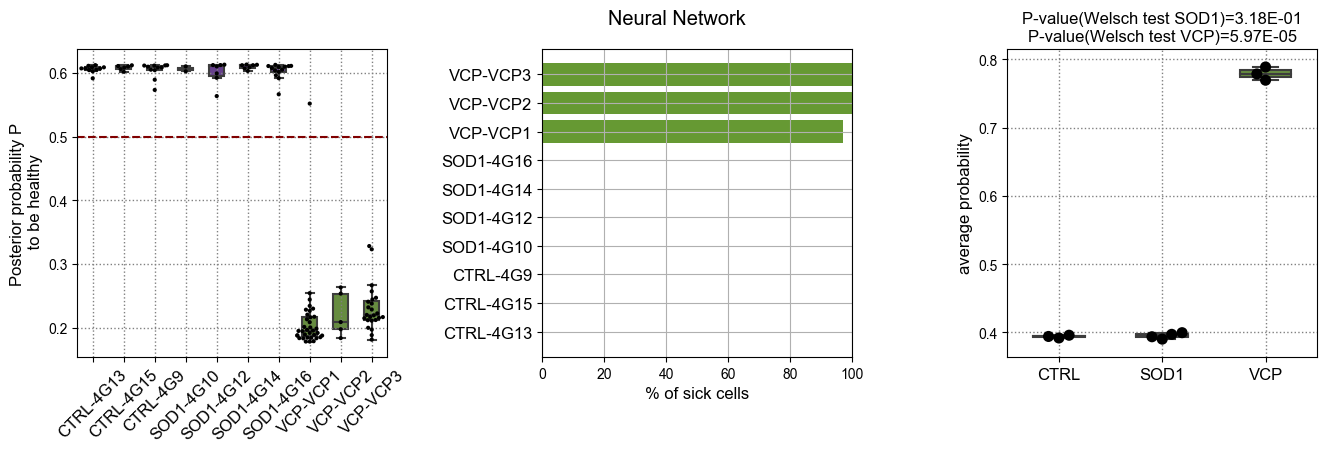

In [184]:
subinfo['prob_NN_sub']=grid_nn_sub.predict_proba(scaler_sub.transform(X_tot))[:,0] 
sfpq_NN,mylim,mysummary,mytest,myprob=ML_analysis_updated(myvars='prob_NN_sub',dfc=subinfo.copy(),
                            fst=12,batch=False,limangle=45,title='Neural Network')

subinfo['test_NN_sub']=mytest;
subinfo['prob_NN_sub']=1-myprob;
subinfo['severity_NN_sub']=-np.log10(myprob);

info['frac_NN_sub']=mysummary['fraction'];
info['prob_NN_sub']=mysummary['avg_prob'];
save_fig(fig_id='NN_result_wo_SOD_spMN_mouse', tight_layout=False)


Saving figure NN_result_full_wo_SOD_spMN_mouse


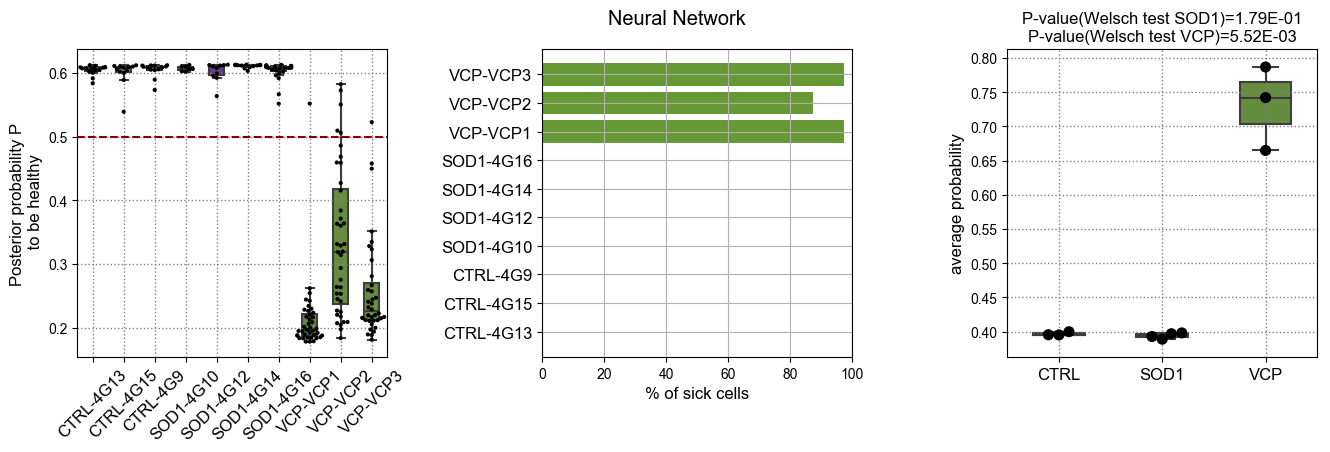

In [185]:
subinfo_full['prob_NN_sub']=grid_nn_sub.predict_proba(scaler_sub.transform(X_tot_full))[:,0]  
sfpq_NN,mylim,mysummary,mytest,myprob=ML_analysis_updated(myvars='prob_NN_sub',dfc=subinfo_full.copy(),
                            fst=12,batch=False,limangle=45,title='Neural Network')

save_fig(fig_id='NN_result_full_wo_SOD_spMN_mouse', tight_layout=False)
subinfo_full['test_NN_sub']=mytest;
subinfo_full['prob_NN_sub']=1-myprob;
subinfo_full['severity_NN_sub']=-np.log10(myprob);


## Save models and data

In [186]:
from joblib import dump, load
dump(grid_nn_sub, '../results_manuscript/grid_nn_sub_mouse.joblib') 
dump(grid_nn_tot, '../results_manuscript/grid_nn_tot_mouse.joblib') 
dump(grid_lr_sub, '../results_manuscript/grid_lr_sub_mouse.joblib') 
dump(grid_lr_tot, '../results_manuscript/grid_lr_tot_mouse.joblib') 

['../results_manuscript/grid_lr_tot_mouse.joblib']

## Compare the different methods


Saving figure Clustering_probs_cells_methods_spMN_mouse_new


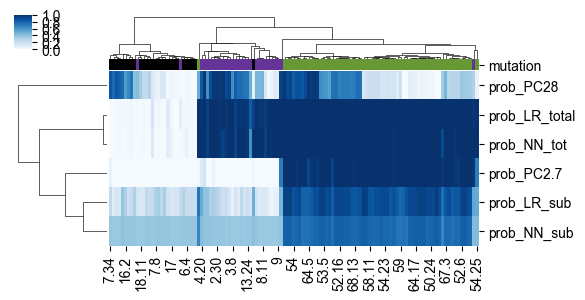

In [187]:
temp=subinfo[['prob_PC2.7','prob_PC28','prob_LR_total','prob_LR_sub','prob_NN_tot','prob_NN_sub']]

g = sns.clustermap(temp.transpose(),col_colors=row_colors,cmap=sns.color_palette("Blues",n_colors=100),figsize=(6,3))


save_fig(fig_id='Clustering_probs_cells_methods_spMN_mouse_new', tight_layout=True)


In [188]:
#Study difference in the cell probabilities between LRs and LR
subinfo['diff_LR']=subinfo['prob_LR_total']-subinfo['prob_LR_sub']
subinfo['diff_NN']=subinfo['prob_NN_tot']-subinfo['prob_NN_sub']
subinfo.columns

Index(['X', 'imageID', 'mutation', 'RBP1', 'RBP2', 'animal', 'origin', 'Lab',
       'pairs', 'cellID', 'ID', 'mutant', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5',
       'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14',
       'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23',
       'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31',
       'fullID', 'test_PC2', 'prob_PC2', 'severity_PC2', 'test_PC2.7',
       'prob_PC2.7', 'severity_PC2.7', 'test_PC28', 'prob_PC28',
       'severity_PC28', 'test_PC7.28', 'prob_PC7.28', 'severity_PC7.28',
       'ismutant', 'prob_LR_tot', 'test_LR_total', 'prob_LR_total',
       'severity_LR_total', 'prob_LR_sub', 'test_LR_sub', 'severity_LR_sub',
       'prob_NN_tot', 'test_NN_tot', 'severity_NN_tot', 'prob_NN_sub',
       'test_NN_sub', 'severity_NN_sub', 'diff_LR', 'diff_NN', 'IDmore'],
      dtype='object')

In [189]:
%%R -w 6 -h 5 --units in -r 150 -i subinfo_full -i positions_cells

pdf("../Figures/mousedata/position_probs.pdf",pointsize=10,width=7)
par(mfrow=c(3,3),mar=c(3,3,3,3))
for(i in unique(subinfo_full$imageID)){
    
    plotCells(mycell=i)
    
}
dev.off()

png 
  2 


## Compare methods

Saving figure ROC_ML_methods


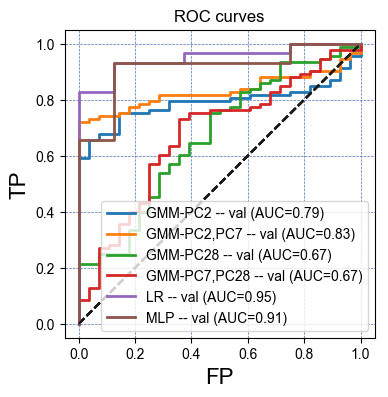

In [190]:
plt.figure(figsize=(4, 4))

lb = preprocessing.LabelBinarizer()
y_test_automated =lb.fit_transform(subinfo['mutant'])
y_scores_GMM_1=subinfo['prob_PC2']
auc_val_GMM_1=roc_auc_score(y_test_automated, y_scores_GMM_1)
fpr_GMM_test, tpr_GMM_test, thresholds_test = roc_curve(y_test_automated,y_scores_GMM_1)
plot_roc_curve(fpr_GMM_test, tpr_GMM_test, "GMM-PC2 -- val (AUC="+"%0.2f" % auc_val_GMM_1+")")


y_scores_GMM_1=subinfo['prob_PC2.7']
auc_val_GMM_1=roc_auc_score(y_test_automated, y_scores_GMM_1)
fpr_GMM_test, tpr_GMM_test, thresholds_test = roc_curve(y_test_automated,y_scores_GMM_1)
plot_roc_curve(fpr_GMM_test, tpr_GMM_test, "GMM-PC2,PC7 -- val (AUC="+"%0.2f" % auc_val_GMM_1+")")

y_scores_GMM_1=subinfo['prob_PC28']
auc_val_GMM_1=roc_auc_score(y_test_automated, y_scores_GMM_1)
fpr_GMM_test, tpr_GMM_test, thresholds_test = roc_curve(y_test_automated,y_scores_GMM_1)
plot_roc_curve(fpr_GMM_test, tpr_GMM_test, "GMM-PC28 -- val (AUC="+"%0.2f" % auc_val_GMM_1+")")

y_scores_GMM_1=subinfo['prob_PC7.28']
auc_val_GMM_1=roc_auc_score(y_test_automated, y_scores_GMM_1)
fpr_GMM_test, tpr_GMM_test, thresholds_test = roc_curve(y_test_automated,y_scores_GMM_1)
plot_roc_curve(fpr_GMM_test, tpr_GMM_test, "GMM-PC7,PC28 -- val (AUC="+"%0.2f" % auc_val_GMM_1+")")


#LR
y_scores_LR_val_tot=grid_lr_tot.predict_proba(X_tot_test)[:,1] 
auc_val_tot_LR=roc_auc_score(y_tot_test, y_scores_LR_val_tot)
fpr_LR_test, tpr_LR_test, thresholds_test = roc_curve(y_tot_test,y_scores_LR_val_tot)
plot_roc_curve(fpr_LR_test, tpr_LR_test, "LR -- val (AUC="+"%0.2f" % auc_val_tot_LR+")")


#MLP
y_scores_nn_val_tot=grid_nn_tot.predict_proba(X_tot_test)[:,1] 
auc_val_tot_nn=roc_auc_score(y_tot_test, y_scores_nn_val_tot)
fpr_nn_test, tpr_nn_test, thresholds_test = roc_curve(y_tot_test,y_scores_nn_val_tot)
plot_roc_curve(fpr_nn_test, tpr_nn_test, "MLP -- val (AUC="+"%0.2f" % auc_val_tot_nn+")")



plt.legend(loc="best")
plt.title('ROC curves')
save_fig(fig_id='ROC_ML_methods', tight_layout=False)


Saving figure Compare_methods_VCP_SOD1_effect


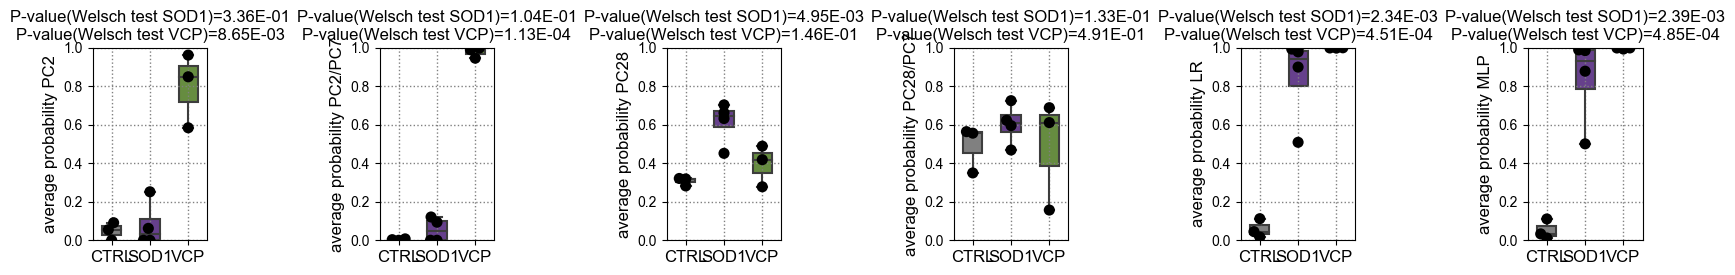

In [191]:
random_state = np.random.RandomState(seed=1)
subinfo['IDmore']=subinfo['mutation']+'-'+subinfo['ID'];
col_CTRL='grey'
col_SOD1='#663399'
col_VCP='#669933'
temp=pd.DataFrame({'name':subinfo['IDmore'].unique()})
g1=np.array(temp.loc[['CTRL' in i for i in temp['name']],'name'])
g2=np.array(temp.loc[['VCP' in i for i in temp['name']],'name'])
g3=np.array(temp.loc[['SOD' in i for i in temp['name']],'name'])
myorder=np.append(np.append(g1,g3),g2)
temp['color']=col_CTRL
temp.loc[['VCP' in i for i in temp['name']],'color']=col_VCP
temp.loc[['SOD' in i for i in temp['name']],'color']=col_SOD1
colorsbx=temp['color']
temp=pd.DataFrame({'name':myorder})
colors=['grey','#663399','#669933'] 
mytemp = subinfo.drop_duplicates('IDmore')
mytemp.index=mytemp['IDmore']




d = {'avg_prob_GMM_1':subinfo.groupby(['IDmore'])['prob_PC2'].mean(),
    'avg_prob_GMM_2':subinfo.groupby(['IDmore'])['prob_PC2.7'].mean(),
    'avg_prob_GMM_3':subinfo.groupby(['IDmore'])['prob_PC28'].mean(),
    'avg_prob_GMM_4':subinfo.groupby(['IDmore'])['prob_PC7.28'].mean(),
    'avg_prob_LR_tot':subinfo.groupby(['IDmore'])['prob_LR_total'].mean(),
    'avg_prob_MLP_total':subinfo.groupby(['IDmore'])['prob_NN_tot'].mean(),
    'avg_prob_LR_sub':subinfo.groupby(['IDmore'])['prob_LR_sub'].mean(),
    'avg_prob_MLP_sub':subinfo.groupby(['IDmore'])['prob_NN_sub'].mean(),
    'avg_sev_GMM_1':subinfo.groupby(['IDmore'])['severity_PC2'].mean(),
    'avg_sev_GMM_2':subinfo.groupby(['IDmore'])['severity_PC2.7'].mean(),
     'avg_sev_GMM_3':subinfo.groupby(['IDmore'])['severity_PC28'].mean(),
    'avg_sev_GMM_4':subinfo.groupby(['IDmore'])['severity_PC7.28'].mean(),
    'avg_sev_LR_tot':subinfo.groupby(['IDmore'])['severity_LR_total'].mean(),
    'avg_sev_MLP_total':subinfo.groupby(['IDmore'])['severity_NN_tot'].mean(),
    'avg_sev_LR_sub':subinfo.groupby(['IDmore'])['severity_LR_sub'].mean(),
    'avg_sev_MLP_sub':subinfo.groupby(['IDmore'])['severity_NN_sub'].mean()}
summary_pc = pd.DataFrame(d)
summary_pc['mutation']=mytemp['mutation']

welsch_vcp_all=[];
welsch_sod1_all=[];

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 2.5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)

def TemPlot(val,title):
    bplot1 = sns.boxplot(y=val, x='mutation', data=summary_pc, width=0.5,order=['CTRL','SOD1','VCP'],palette=colors,showfliers=False)
    bplot1 = sns.swarmplot(y=val, x='mutation', data=summary_pc, color="black",  size=8)
    plt.grid(True,color='grey', linestyle=':', linewidth=1)
    plt.ylabel('average probability '+title,fontsize=12)
    plt.ylim(0,1)
    plt.xticks(fontsize=12)
    plt.xlabel('') 
    welch_vcp=ttest_ind(a=summary_pc.groupby('mutation')[val].get_group('CTRL'),
                    b=summary_pc.groupby('mutation')[val].get_group('VCP'),equal_var=False).pvalue/2
    welch_sod1=ttest_ind(a=summary_pc.groupby('mutation')[val].get_group('CTRL'),
                    b=summary_pc.groupby('mutation')[val].get_group('SOD1'),equal_var=False).pvalue/2

    welsch_vcp_all.append(-np.log10(welch_vcp))
    welsch_sod1_all.append(-np.log10(welch_sod1))

    plt.title( "P-value(Welsch test SOD1)="+str('%.2E' % welch_sod1)+"\nP-value(Welsch test VCP)="+str('%.2E' % welch_vcp))

    

plt.subplot(1,6,1)
TemPlot(val='avg_prob_GMM_1',title='PC2')
plt.subplot(1,6,2)
TemPlot(val='avg_prob_GMM_2',title='PC2/PC7')
plt.subplot(1,6,3)
TemPlot(val='avg_prob_GMM_3',title='PC28')
plt.subplot(1,6,4)
TemPlot(val='avg_prob_GMM_4',title='PC28/PC7')
plt.subplot(1,6,5)
TemPlot(val='avg_prob_LR_tot',title='LR')
plt.subplot(1,6,6)
TemPlot(val='avg_prob_MLP_total',title='MLP')



plt.subplots_adjust(hspace=0.5,wspace=1.5)
save_fig(fig_id='Compare_methods_VCP_SOD1_effect', tight_layout=False)


In [192]:
d = {'avg_prob_GMM_1':subinfo.groupby(['IDmore'])['prob_PC2.7'].mean(),
    'avg_prob_GMM_2':subinfo.groupby(['IDmore'])['prob_PC28'].mean(),
    'avg_prob_LR_tot':subinfo.groupby(['IDmore'])['prob_LR_total'].mean(),
    'avg_prob_MLP_total':subinfo.groupby(['IDmore'])['prob_NN_tot'].mean(),
    'avg_prob_LR_sub':subinfo.groupby(['IDmore'])['prob_LR_sub'].mean(),
    'avg_prob_MLP_sub':subinfo.groupby(['IDmore'])['prob_NN_sub'].mean(),
    'avg_sev_GMM_1':subinfo.groupby(['IDmore'])['severity_PC2'].mean(),
    'avg_sev_GMM_2':subinfo.groupby(['IDmore'])['severity_PC28'].mean(),
    'avg_sev_LR_tot':subinfo.groupby(['IDmore'])['severity_LR_total'].mean(),
    'avg_sev_MLP_total':subinfo.groupby(['IDmore'])['severity_NN_tot'].mean(),
    'avg_sev_LR_sub':subinfo.groupby(['IDmore'])['severity_LR_sub'].mean(),
    'avg_sev_MLP_sub':subinfo.groupby(['IDmore'])['severity_NN_sub'].mean()}
summary_pc = pd.DataFrame(d)
summary_pc['mutation']=mytemp['mutation']
summary_pc

avg_prob_GMM_1  avg_prob_GMM_2  avg_prob_LR_tot  \
IDmore                                                       
CTRL-4G13        0.007311        0.318839         0.016594   
CTRL-4G15        0.000083        0.321152         0.044890   
CTRL-4G9         0.003186        0.282321         0.112156   
SOD1-4G10        0.000129        0.703291         0.508989   
SOD1-4G12        0.121011        0.632388         0.978642   
SOD1-4G14        0.000006        0.451617         0.993159   
SOD1-4G16        0.094040        0.661910         0.899803   
VCP-VCP1         0.990354        0.418604         0.998995   
VCP-VCP2         0.997948        0.277833         0.999894   
VCP-VCP3         0.945831        0.488963         0.998230   

           avg_prob_MLP_total  avg_prob_LR_sub  avg_prob_MLP_sub  \
IDmore                                                             
CTRL-4G13            0.011876         0.246039          0.393968   
CTRL-4G15            0.033107         0.232138          0.391751   
CTRL-4G9             0.110740         0.255983          0.395768   
SOD1-4G10            0.500904         0.238768          0.393532   
SOD1-4G12            0.989121         0.275355          0.399492   
SOD1-4G14            0.985325         0.130475          0.390041   
SOD1-4G16            0.878368         0.261460          0.397051   
VCP-VCP1             0.998906         0.897638          0.788910   
VCP-VCP2             0.999093         0.859438          0.778711   
VCP-VCP3             0.993366         0.854759          0.769561   

           avg_sev_GMM_1  avg_sev_GMM_2  avg_sev_LR_tot  avg_sev_MLP_total  \
IDmore                                                                       
CTRL-4G13       0.036277       0.234852        0.007301           0.005278   
CTRL-4G15       0.000136       0.259587        0.020821           0.015205   
CTRL-4G9        0.085580       0.202125        0.121363           0.195218   
SOD1-4G10       0.000001       0.933062        1.347222           1.285986   
SOD1-4G12       0.288087       0.590319        1.809256           2.436947   
SOD1-4G14       0.000042       0.508972        2.287960           2.174196   
SOD1-4G16       0.051072       0.729725        1.780135           1.778862   
VCP-VCP1        2.196913       0.382714        3.718383           3.401186   
VCP-VCP2        1.078723       0.220245        4.794529           3.077573   
VCP-VCP3        1.347291       0.438555        3.161757           2.789073   

           avg_sev_LR_sub  avg_sev_MLP_sub mutation  
IDmore                                               
CTRL-4G13        0.124275         0.217521     CTRL  
CTRL-4G15        0.116257         0.215926     CTRL  
CTRL-4G9         0.133863         0.218878     CTRL  
SOD1-4G10        0.119906         0.217201     SOD1  
SOD1-4G12        0.152710         0.221654     SOD1  
SOD1-4G14        0.061623         0.214706     SOD1  
SOD1-4G16        0.137389         0.219809     SOD1  
VCP-VCP1         1.044073         0.686097      VCP  
VCP-VCP2         0.888456         0.659380      VCP  
VCP-VCP3         0.858336         0.641913      VCP

In [193]:
info_augm = info.copy()
info_augm['IDmore']=info_augm['mutation']+'-'+info_augm['ID'];
info_augm.index=info_augm['IDmore']


Saving figure Compare_methods_spMN_probs


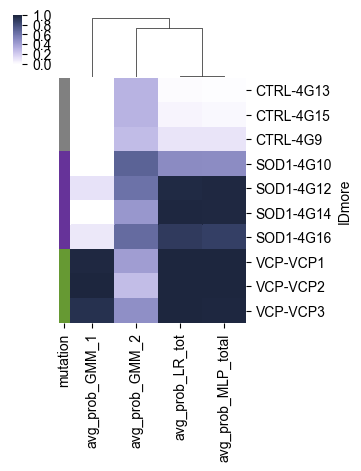

In [194]:
lut = palette=dict(CTRL='grey', SOD1="#663399", VCP='#669933')
row_colors_agg = summary_pc.mutation.map(lut)
aggregatedProbs=summary_pc[['avg_prob_GMM_1','avg_prob_GMM_2','avg_prob_LR_tot','avg_prob_MLP_total']]
sns.clustermap(aggregatedProbs,row_cluster=False,cmap=sns.cubehelix_palette(start=2.8, rot=.1,light=1.0, as_cmap=True),figsize=(3,4),row_colors=row_colors_agg)

save_fig(fig_id='Compare_methods_spMN_probs', tight_layout=False)


Saving figure Compare_methods_spMN_severity


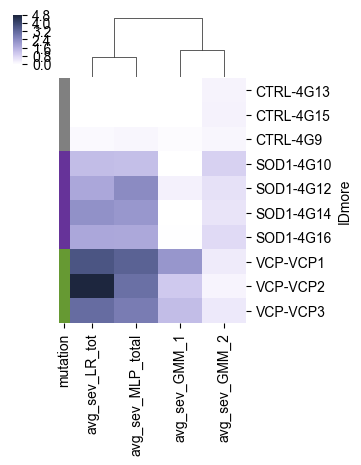

In [195]:
lut = palette=dict(CTRL='grey', SOD1="#663399", VCP='#669933')
row_colors_agg = summary_pc.mutation.map(lut)
aggregatedSev=summary_pc[['avg_sev_GMM_1','avg_sev_GMM_2','avg_sev_LR_tot','avg_sev_MLP_total']]
sns.clustermap(aggregatedSev,row_cluster=False,cmap=sns.cubehelix_palette(start=2.8, rot=.1,light=1.0, as_cmap=True),figsize=(3,4),row_colors=row_colors_agg)

save_fig(fig_id='Compare_methods_spMN_severity', tight_layout=False)


Saving figure Compare_methods_spMN_fraction


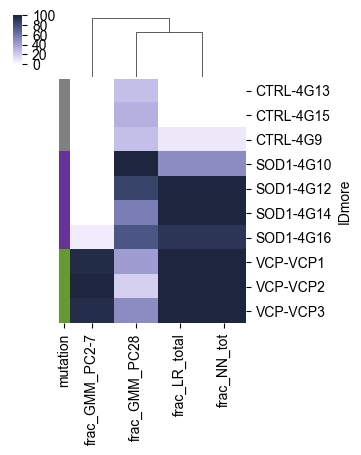

In [196]:
lut = palette=dict(CTRL='grey', SOD1="#663399", VCP='#669933')

temp=info.copy()
temp.index=temp['ID']
temp=temp.reindex(summary_pc.index)

aggregatedFrac=temp[['frac_GMM_PC2-7','frac_GMM_PC28','frac_LR_total','frac_NN_tot']]
row_colors_agg = temp.mutation.map(lut)
sns.clustermap(aggregatedFrac,row_cluster=False,cmap=sns.cubehelix_palette(start=2.8, rot=.1,light=1.0, as_cmap=True),figsize=(3,4),row_colors=row_colors_agg)
save_fig(fig_id='Compare_methods_spMN_fraction', tight_layout=False)


In [197]:
subinfo['fullID']=subinfo['mutation'].astype(str)+subinfo['animal'].astype(str)
lut = dict(CTRL='black', SOD1="#663399", VCP='#669933')
row_colors = subinfo.mutation.map(lut)


png 
  2 


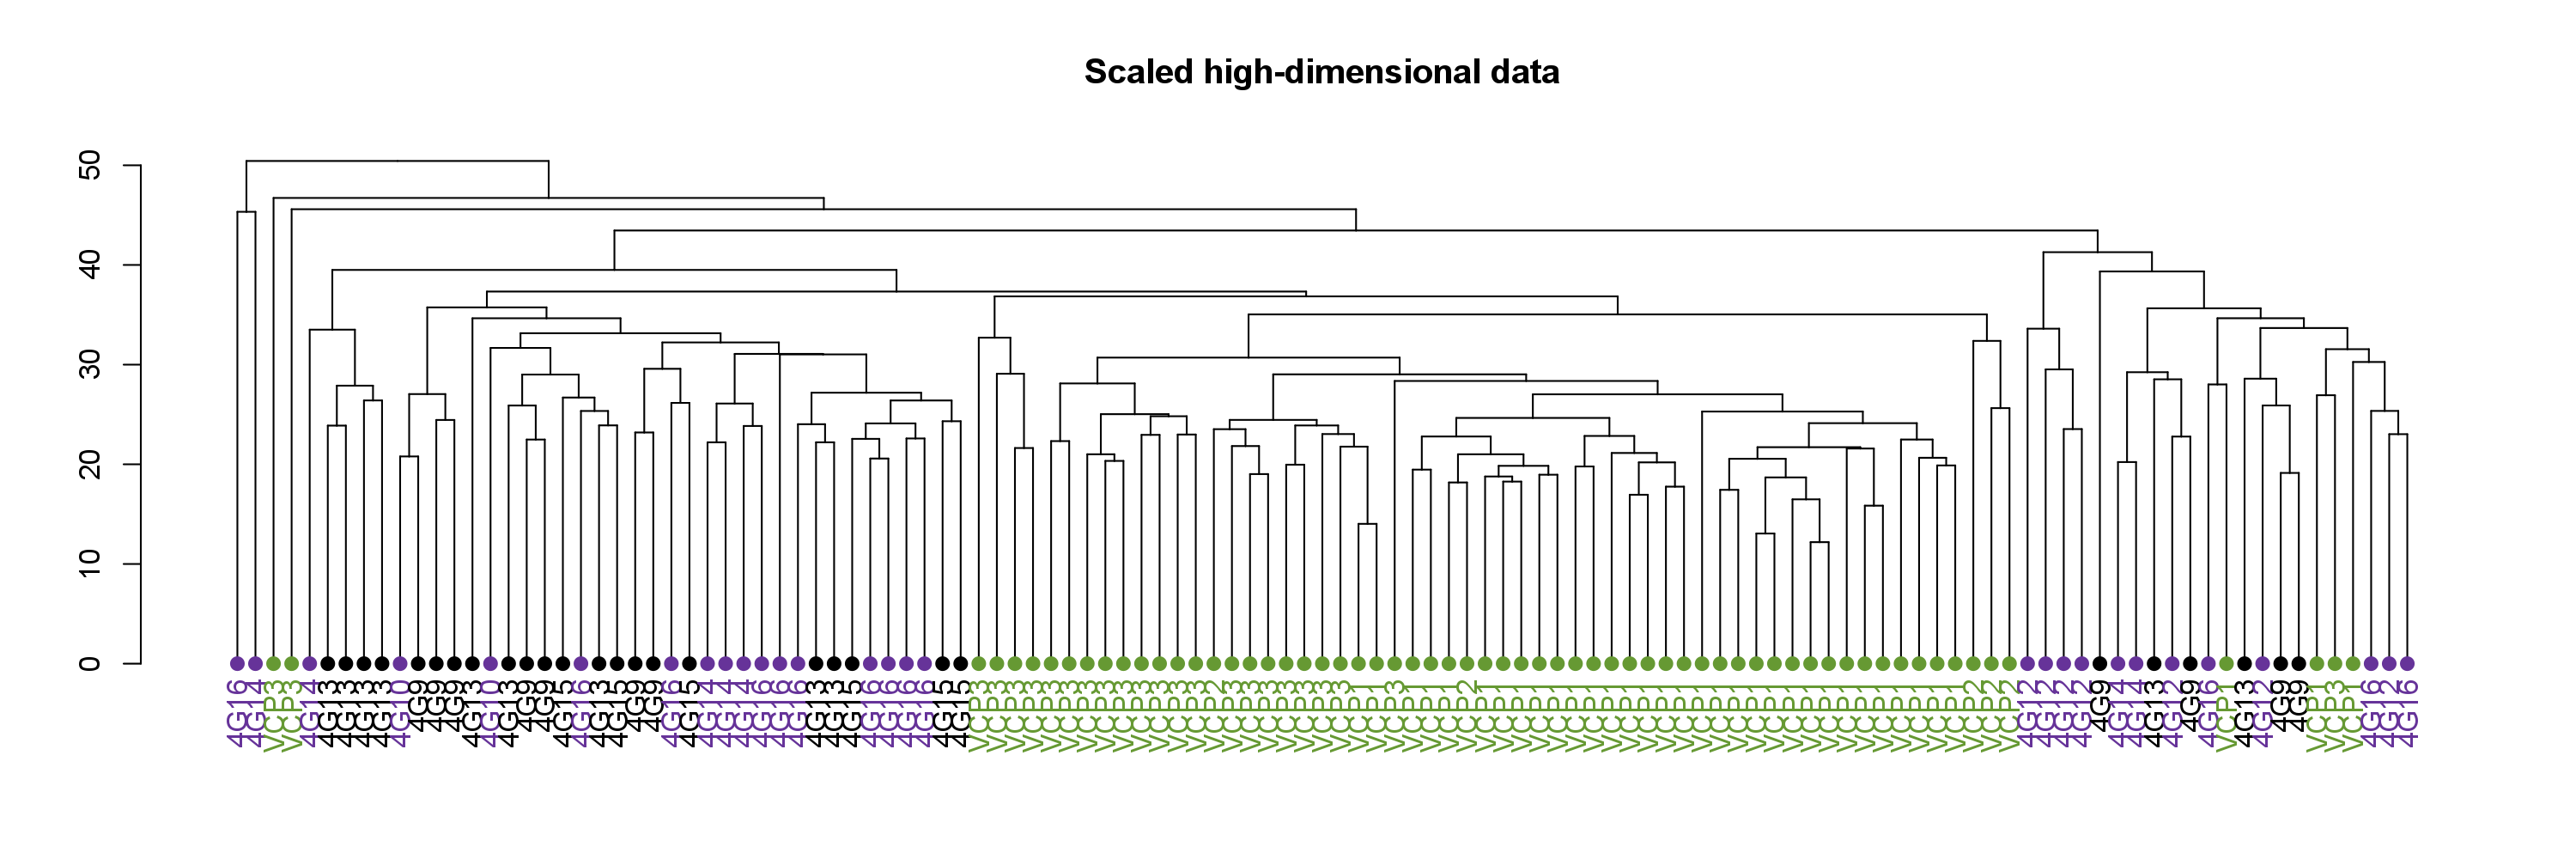

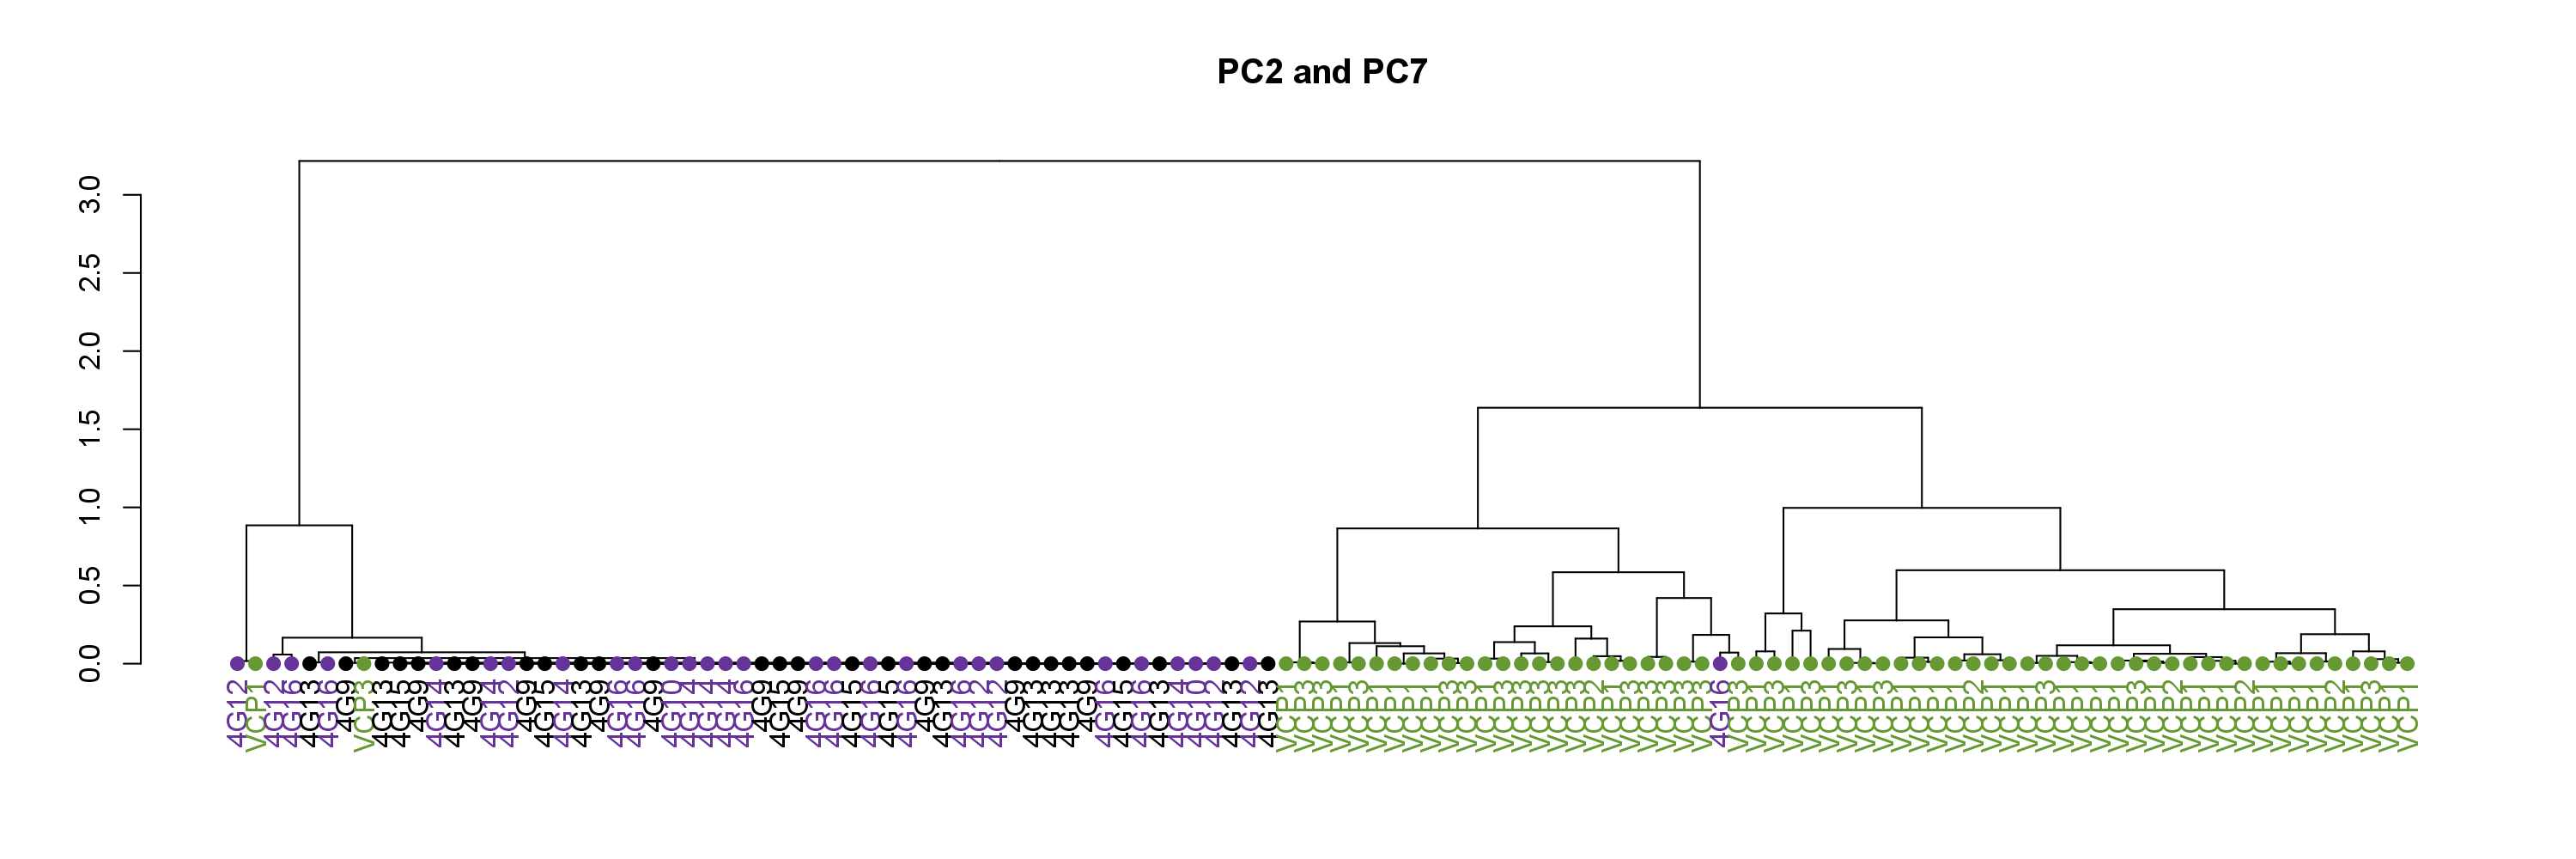

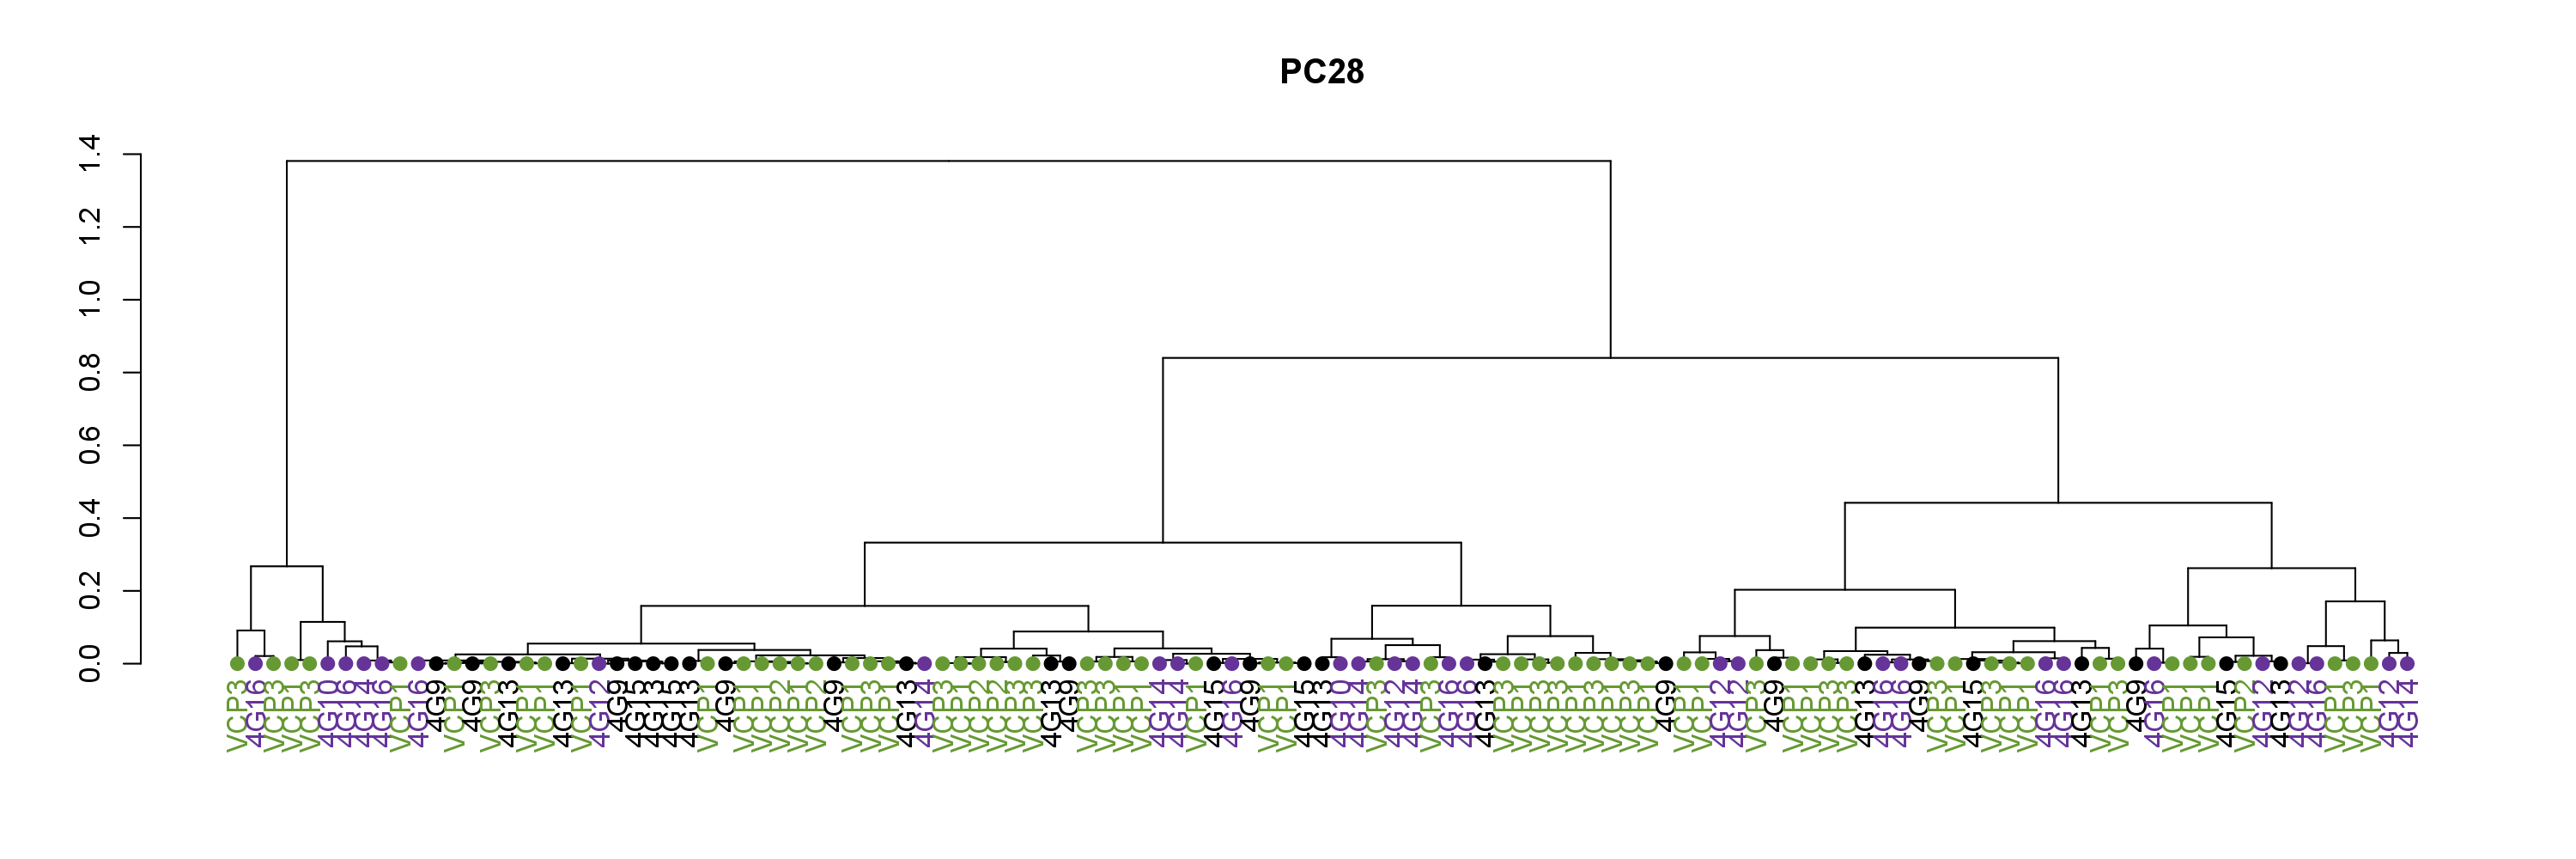

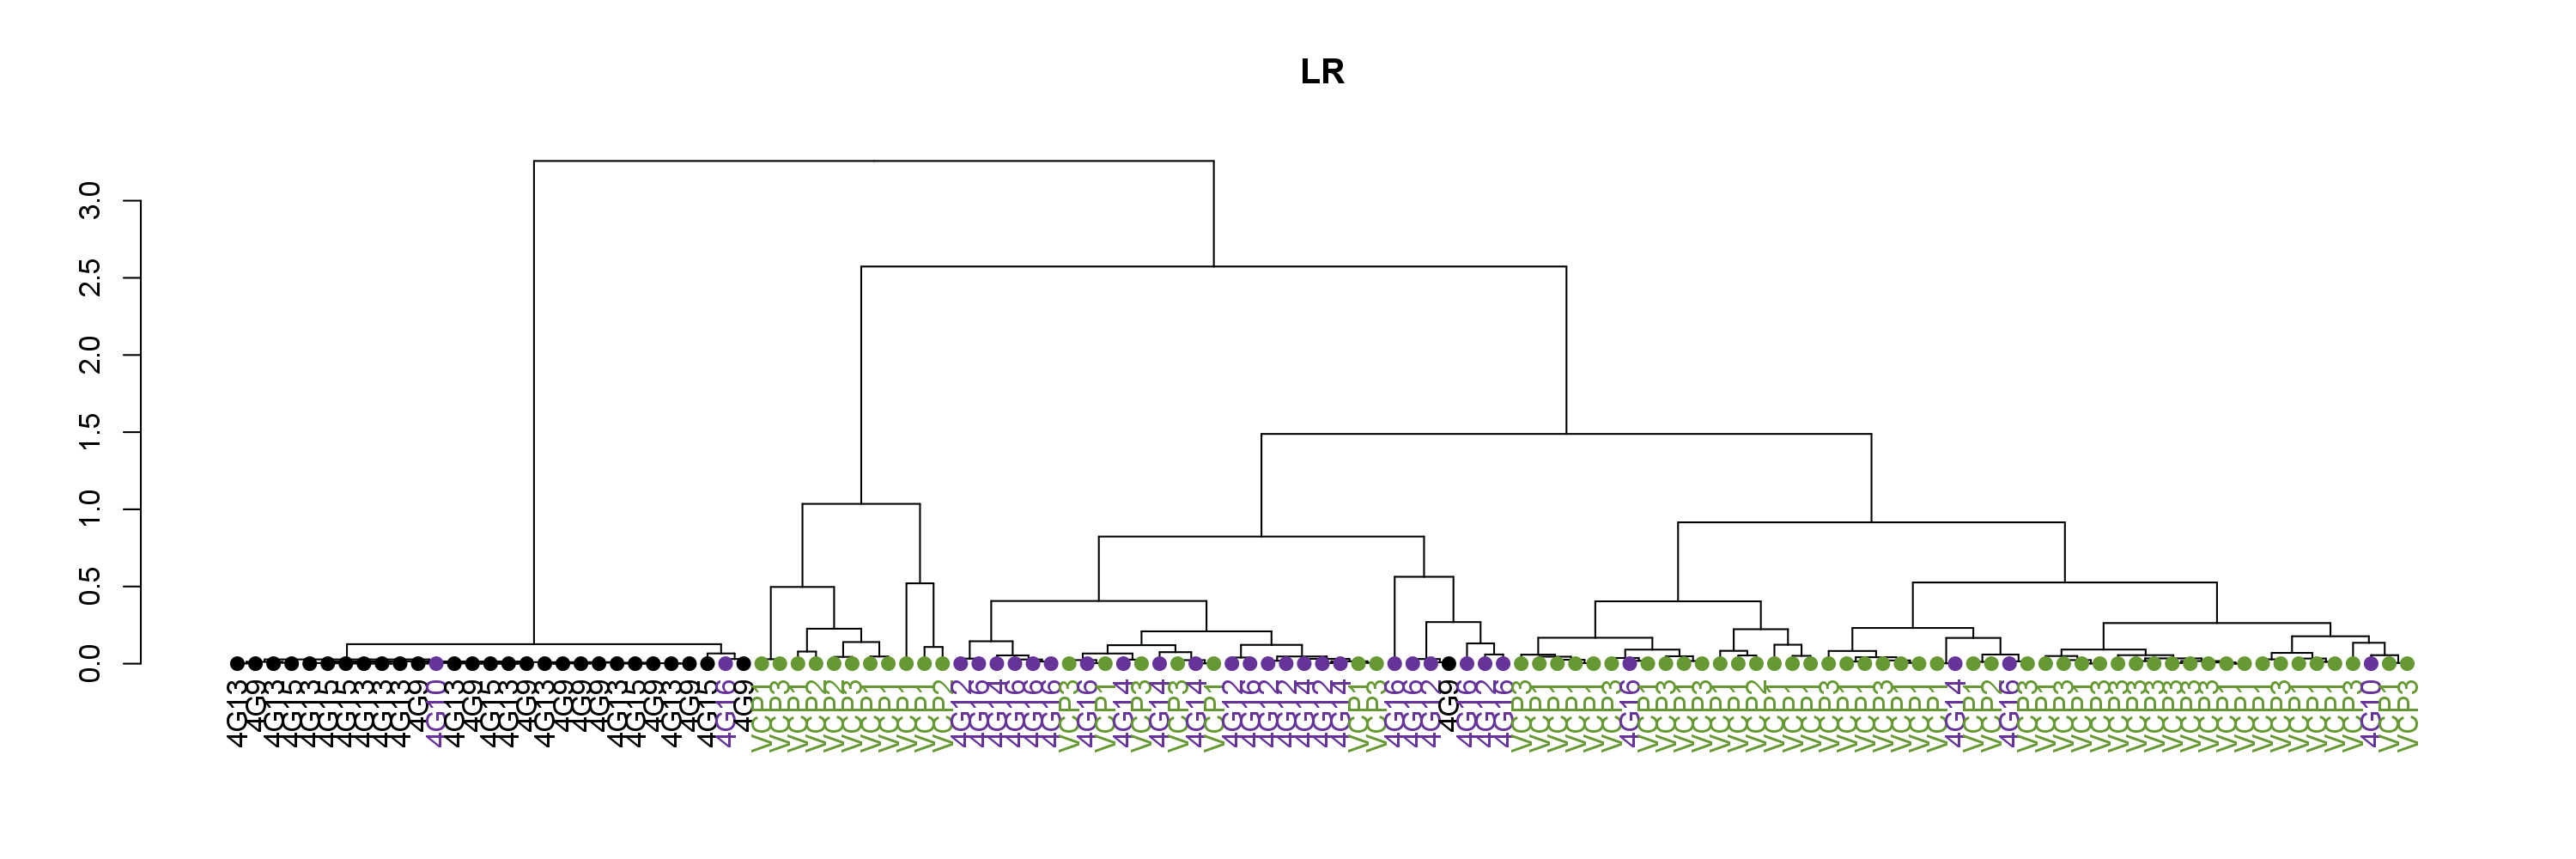

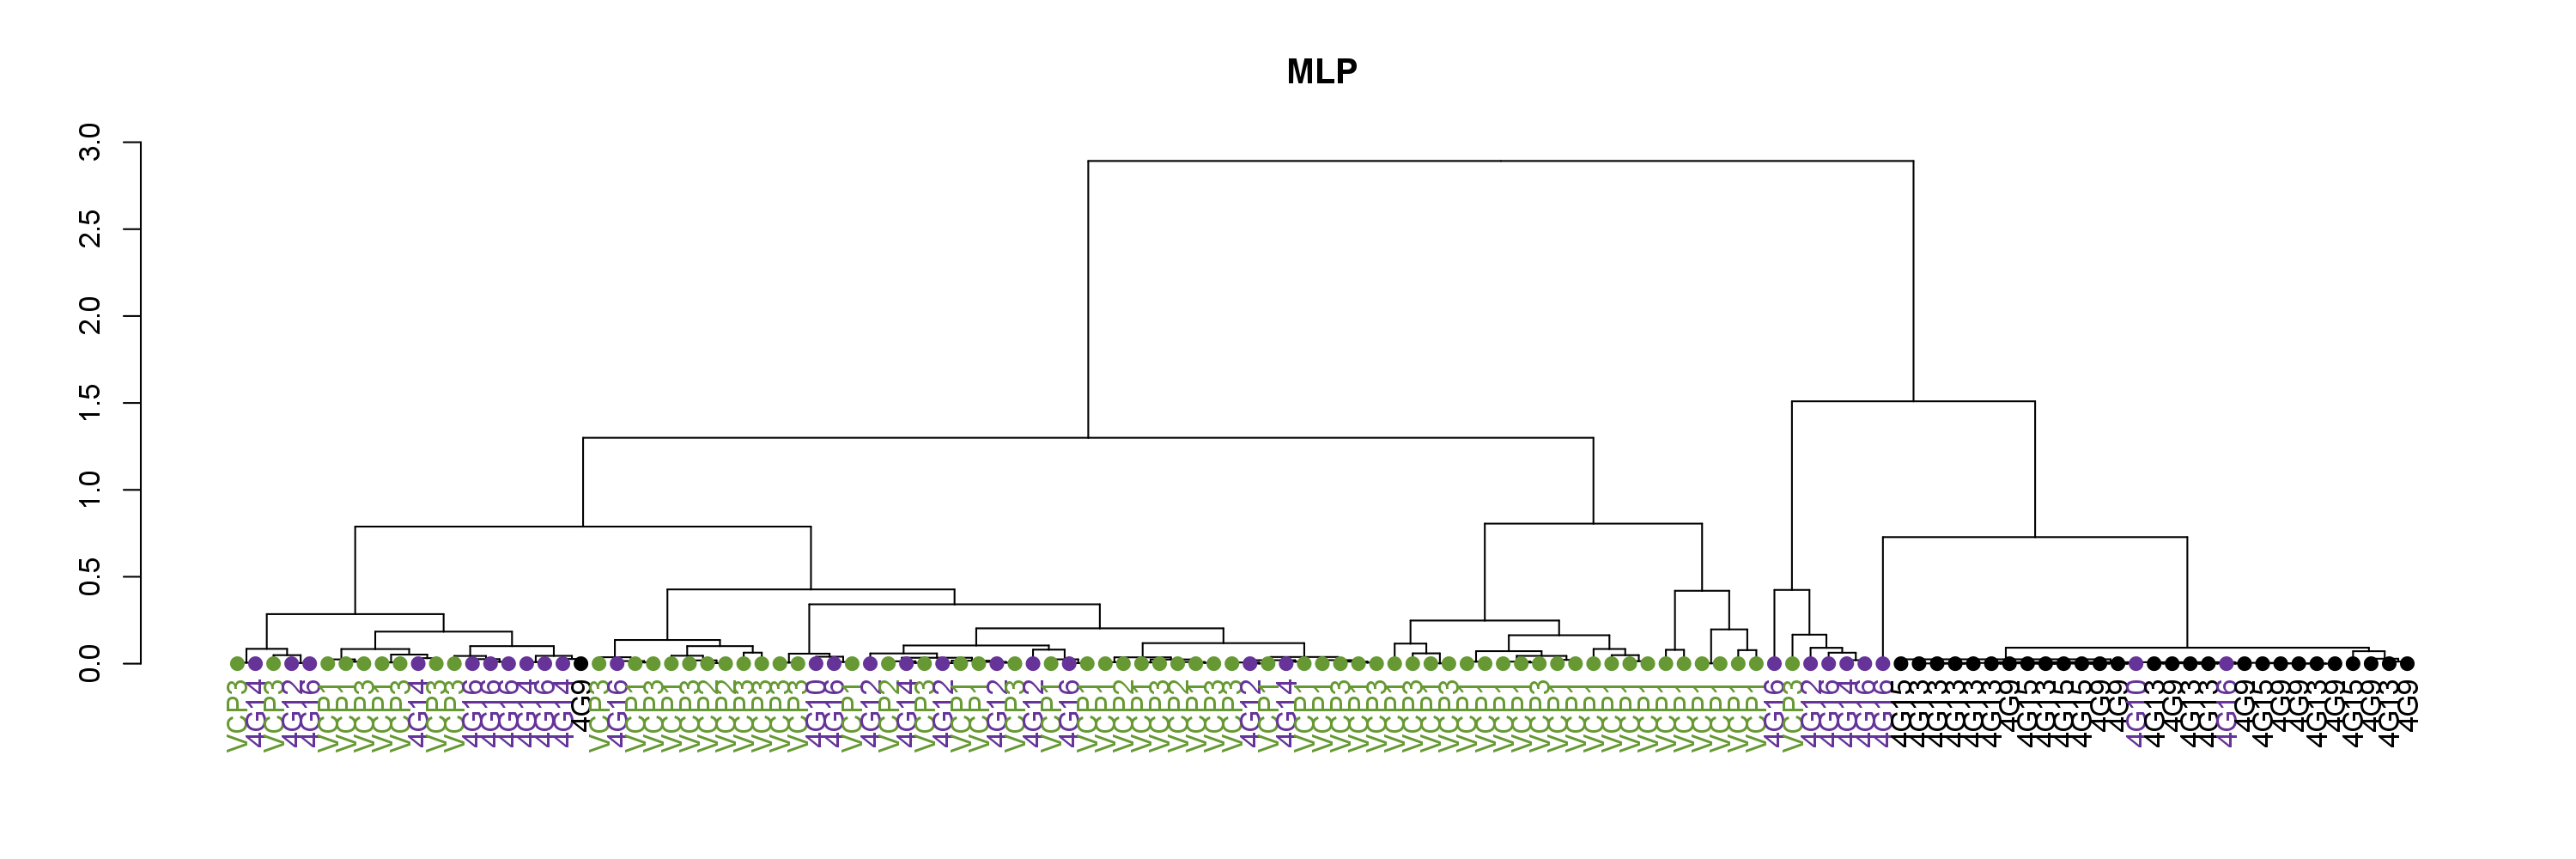

In [198]:
%%R -w 15 -h 5 --units in -r 200 -i data_tot -i subinfo -i row_colors
f1 <- ifelse(subinfo$mutation=="CTRL","C","S")
f1[subinfo$mutation=="VCP"]<-"V"
f2 <- rep(1, length(f1))
f2[which(f1=="C")]<-c(1:length(which(f1=="C")))
f2[which(f1=="S")]<-c(1:length(which(f1=="S")))
f2[which(f1=="V")]<-c(1:length(which(f1=="V")))

library(dendextend)
temp <- data_tot
rownames(temp)<- paste(f1,f2,sep="")
d2 <- as.dendrogram(hclust(dist(temp), method = "average"))
myorder=hclust(dist(temp), method = "average")$order
d2 %>% set("leaves_pch", 19)%>% set("labels", as.character(subinfo$ID)[myorder])%>% 
    set("leaves_col", row_colors[myorder])%>% 
    set("labels_col", row_colors[myorder])  %>% 
    set("labels_cex", 1) %>% plot(main='Scaled high-dimensional data')


temp <- subinfo[,c('prob_PC2.7','severity_PC2.7')]
rownames(temp)<- paste(f1,f2,sep="")
d2 <- as.dendrogram(hclust(dist(temp), method = "average"))
myorder=hclust(dist(temp), method = "average")$order
d2 %>% set("leaves_pch", 19)%>% set("labels", as.character(subinfo$ID)[myorder])%>% 
    set("leaves_col", row_colors[myorder])%>% 
    set("labels_col", row_colors[myorder])  %>% 
    set("labels_cex", 1) %>% plot(main='PC2 and PC7')

temp          <- subinfo[,c('prob_PC28','severity_PC28')]
rownames(temp)<- paste(f1,f2,sep="")
d2 <- as.dendrogram(hclust(dist(temp), method = "average"))
myorder=hclust(dist(temp), method = "average")$order
d2 %>% set("leaves_pch", 19)%>% set("labels", as.character(subinfo$ID)[myorder])%>% 
    set("leaves_col", row_colors[myorder])%>% 
    set("labels_col", row_colors[myorder])  %>% 
    set("labels_cex", 1) %>% plot(main='PC28')


temp          <- subinfo[,c('prob_LR_total','severity_LR_total')]
rownames(temp)<- paste(f1,f2,sep="")
d2 <- as.dendrogram(hclust(dist(temp), method = "average"))
myorder=hclust(dist(temp), method = "average")$order
d2 %>% set("leaves_pch", 19)%>% set("labels", as.character(subinfo$ID)[myorder])%>% 
    set("leaves_col", row_colors[myorder])%>% 
    set("labels_col", row_colors[myorder])  %>% 
    set("labels_cex", 1) %>% plot(main='LR')

temp          <- subinfo[,c('prob_NN_tot','severity_NN_tot')]
rownames(temp)<- paste(f1,f2,sep="")
d2 <- as.dendrogram(hclust(dist(temp), method = "average"))
myorder=hclust(dist(temp), method = "average")$order
d2 %>% set("leaves_pch", 19)%>% set("labels", as.character(subinfo$ID)[myorder])%>% 
    set("leaves_col", row_colors[myorder])%>% 
    set("labels_col", row_colors[myorder])  %>% 
    set("labels_cex", 1) %>% plot(main='MLP')


pdf("../Figures/mousedata/HC_diseaseprofile.pdf",pointsize=10,width=5)
f1 <- ifelse(subinfo$mutation=="CTRL","C","S")
f1[subinfo$mutation=="VCP"]<-"V"
f2 <- rep(1, length(f1))
f2[which(f1=="C")]<-c(1:length(which(f1=="C")))
f2[which(f1=="S")]<-c(1:length(which(f1=="S")))
f2[which(f1=="V")]<-c(1:length(which(f1=="V")))

library(dendextend)
temp <- data_tot
rownames(temp)<- paste(f1,f2,sep="")
d2 <- as.dendrogram(hclust(dist(temp), method = "average"))
myorder=hclust(dist(temp), method = "average")$order
d2 %>% set("leaves_pch", 19)%>% set("labels", as.character(subinfo$ID)[myorder])%>% 
    set("leaves_col", row_colors[myorder])%>% 
    set("labels_col", row_colors[myorder])  %>% 
    set("labels_cex", 1) %>% plot(main='Scaled high-dimensional data')


temp <- subinfo[,c('prob_PC2.7','severity_PC2.7')]
rownames(temp)<- paste(f1,f2,sep="")
d2 <- as.dendrogram(hclust(dist(temp), method = "average"))
myorder=hclust(dist(temp), method = "average")$order
d2 %>% set("leaves_pch", 19)%>% set("labels", as.character(subinfo$ID)[myorder])%>% 
    set("leaves_col", row_colors[myorder])%>% 
    set("labels_col", row_colors[myorder])  %>% 
    set("labels_cex", 1) %>% plot(main='PC2 and PC7')

temp          <- subinfo[,c('prob_PC28','severity_PC28')]
rownames(temp)<- paste(f1,f2,sep="")
d2 <- as.dendrogram(hclust(dist(temp), method = "average"))
myorder=hclust(dist(temp), method = "average")$order
d2 %>% set("leaves_pch", 19)%>% set("labels", as.character(subinfo$ID)[myorder])%>% 
    set("leaves_col", row_colors[myorder])%>% 
    set("labels_col", row_colors[myorder])  %>% 
    set("labels_cex", 1) %>% plot(main='PC28')


temp          <- subinfo[,c('prob_LR_total','severity_LR_total')]
rownames(temp)<- paste(f1,f2,sep="")
d2 <- as.dendrogram(hclust(dist(temp), method = "average"))
myorder=hclust(dist(temp), method = "average")$order
d2 %>% set("leaves_pch", 19)%>% set("labels", as.character(subinfo$ID)[myorder])%>% 
    set("leaves_col", row_colors[myorder])%>% 
    set("labels_col", row_colors[myorder])  %>% 
    set("labels_cex", 1) %>% plot(main='LR')

temp          <- subinfo[,c('prob_NN_tot','severity_NN_tot')]
rownames(temp)<- paste(f1,f2,sep="")
d2 <- as.dendrogram(hclust(dist(temp), method = "average"))
myorder=hclust(dist(temp), method = "average")$order
d2 %>% set("leaves_pch", 19)%>% set("labels", as.character(subinfo$ID)[myorder])%>% 
    set("leaves_col", row_colors[myorder])%>% 
    set("labels_col", row_colors[myorder])  %>% 
    set("labels_cex", 1) %>% plot(main='MLP')
dev.off()

## Analysis of relevant features to predict disease score



In [199]:
hidden_neurons_relevance_tot = grid_nn_tot.best_estimator_.coefs_[1]
hidden_neurons_relevance_tot=np.reshape(hidden_neurons_relevance_tot,len(hidden_neurons_relevance_tot))
params_relevance_tot = grid_nn_tot.best_estimator_.coefs_[0]
hidden_neurons_relevance_sub = grid_nn_sub.best_estimator_.coefs_[1]
hidden_neurons_relevance_sub=np.reshape(hidden_neurons_relevance_sub,len(hidden_neurons_relevance_sub))
params_relevance_sub = grid_nn_sub.best_estimator_.coefs_[0]

In [200]:
feature_importances_tot = grid_lr_tot.best_estimator_.coef_.T
attributes= np.array(Us.columns)
feature_importances_tot=np.reshape(feature_importances_tot,len(feature_importances_tot))
feature_importances_sub = grid_lr_sub.best_estimator_.coef_.T
feature_importances_sub=np.reshape(feature_importances_sub,len(feature_importances_sub))

In [201]:
%%R  -i feature_importances_tot -i feature_importances_sub  -i Us -i params_relevance_sub -i params_relevance_tot -i hidden_neurons_relevance_tot -i hidden_neurons_relevance_sub -o feature_relevance

colnames(params_relevance_tot)  <- paste("HN_",c(1:ncol(params_relevance_tot)),"_tot",sep="")


feature_relevance         <- Us[,c('PC2','PC7','PC28')]
feature_relevance$LR_tot  <- feature_importances_tot
feature_relevance$LR_sub  <- feature_importances_sub
attributes=rownames(feature_relevance)
colnames(params_relevance_tot)  <- paste("HN_",c(1:ncol(params_relevance_tot)),"_tot",sep="")
for(i in c(1:ncol(params_relevance_tot))){
    params_relevance_tot[,i]<-params_relevance_tot[,i]*hidden_neurons_relevance_tot[i]
} 

colnames(params_relevance_sub)  <- paste("HN_",c(1:ncol(params_relevance_sub)),"_sub",sep="")
for(i in c(1:ncol(params_relevance_sub))){
    params_relevance_sub[,i]<-params_relevance_sub[,i]*hidden_neurons_relevance_sub[i]
} 

feature_relevance <- data.frame(feature_relevance,params_relevance_sub,params_relevance_tot)

In [202]:
feature_relevance.columns

Index(['PC2', 'PC7', 'PC28', 'LR_tot', 'LR_sub', 'HN_1_sub', 'HN_2_sub',
       'HN_3_sub', 'HN_1_tot', 'HN_2_tot', 'HN_3_tot', 'HN_4_tot', 'HN_5_tot',
       'HN_6_tot', 'HN_7_tot', 'HN_8_tot', 'HN_9_tot', 'HN_10_tot',
       'HN_11_tot', 'HN_12_tot', 'HN_13_tot', 'HN_14_tot', 'HN_15_tot',
       'HN_16_tot', 'HN_17_tot', 'HN_18_tot', 'HN_19_tot'],
      dtype='object')

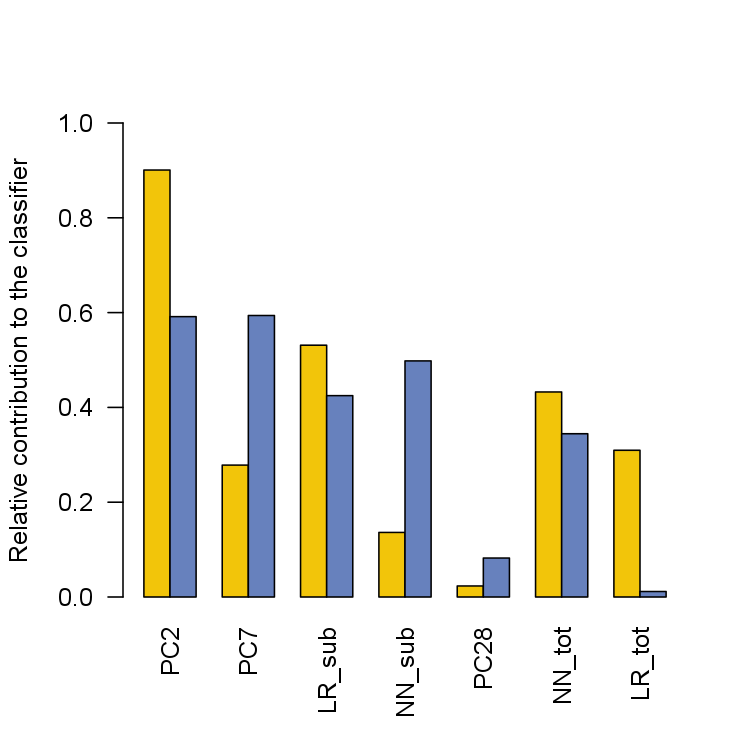

In [203]:
%%R -w 5 -h 5 --units in -r 150 -o relative_feature_importance_tops -i feature_relevance -i hidden_neurons_relevance_sub -i hidden_neurons_relevance_tot -o relative_feature_importance

temp       <- abs(feature_relevance)
for(i in c(1:ncol(temp))){temp[,i]<-temp[,i]/max(temp[,i])}

myMins <- apply(temp,2,min)
myMaxs <- apply(temp,2,max)
temp   <- temp[which(rownames(feature_relevance)%in%c("Intensity_MeanIntensity_SFPQ_nc_ratios","Intensity_MeanIntensity_FUS_nc_ratios")),]
HN_tot <- temp[,grep(colnames(temp),pattern="tot")[-1]]
HN_tot_values <- c(sum(HN_tot[1,]*t(abs(hidden_neurons_relevance_tot)/sum(abs(hidden_neurons_relevance_tot)))),
                   sum(HN_tot[2,]*t(abs(hidden_neurons_relevance_tot)/sum(abs(hidden_neurons_relevance_tot)))))
                   



HN_sub<- temp[,grep(colnames(temp),pattern="sub")[-1]]
HN_sub_values <- c(sum(HN_sub[1,]*t(abs(hidden_neurons_relevance_sub)/sum(abs(hidden_neurons_relevance_sub)))),
                   sum(HN_sub[2,]*t(abs(hidden_neurons_relevance_sub)/sum(abs(hidden_neurons_relevance_sub)))))
        

mytemp <- data.frame(temp[,c("PC2",'PC7',"PC28","LR_tot","LR_sub")],NN_tot=HN_tot_values,NN_sub=HN_sub_values)
barplot(as.matrix(mytemp[,c("PC2",'PC7',"LR_sub","NN_sub","PC28","NN_tot","LR_tot")]),beside=TRUE,col=c("#F2C50A","#6781BD"),las=2,ylim=c(0,1),ylab="Relative contribution to the classifier")
pdf("../Figures/mousedata/FUS_SFPQ_contributions_models_spMN_new.pdf",pointsize=10,width=9)
par(mfrow=c(2,2))
barplot(as.matrix(mytemp[,c("PC2","PC7","LR_sub","NN_sub","PC28","NN_tot","LR_tot")]),beside=TRUE,col=c("#F2C50A","#6781BD"),las=2,ylim=c(0,1),ylab="Relative contribution to the classifier")
dev.off()


temp   <- abs(feature_relevance)
for(i in c(1:ncol(temp))){temp[,i]<-temp[,i]/max(temp[,i])}

HN_tot        <- temp[,grep(colnames(temp),pattern="tot")[-1]]
HN_tot_values <- do.call(what=c,
                         lapply(c(1:nrow(HN_tot)),function(Z)return(sum(HN_tot[Z,]*t(abs(hidden_neurons_relevance_tot)/sum(abs(hidden_neurons_relevance_tot)))))))
HN_sub<- temp[,grep(colnames(temp),pattern="sub")[-1]]
HN_sub_values <- do.call(what=c,
                         lapply(c(1:nrow(HN_sub)),function(Z)return(sum(HN_sub[Z,]*t(abs(hidden_neurons_relevance_sub)/sum(abs(hidden_neurons_relevance_sub)))))))

relative_feature_importance <- data.frame(temp[,c("PC2","PC7","PC28","LR_tot","LR_sub")],NN_tot=HN_tot_values,NN_sub=HN_sub_values)
rownames(relative_feature_importance) <- rownames(feature_relevance)
                                
mysel<-apply(relative_feature_importance>0.7,1,sum)>0
                                
relative_feature_importance_tops <-relative_feature_importance[mysel,]                                 
                                

In [204]:
relative_feature_importance.columns

Index(['PC2', 'PC7', 'PC28', 'LR_tot', 'LR_sub', 'NN_tot', 'NN_sub'], dtype='object')

Saving figure Relative_contribution_features_spMN_mouse


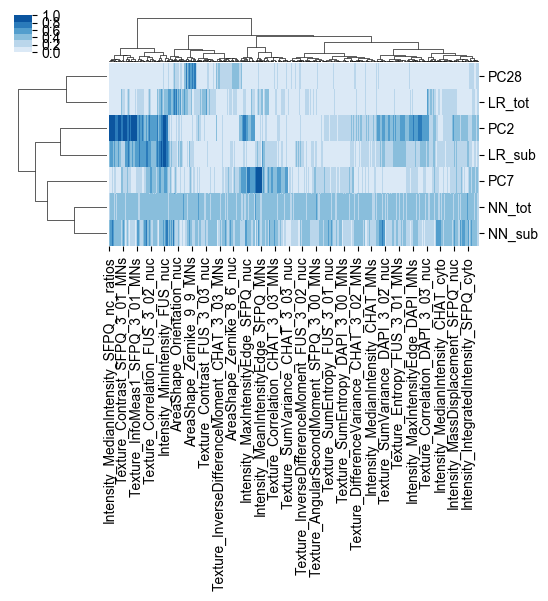

In [205]:
g = sns.clustermap(relative_feature_importance.transpose(),method='ward',metric='euclidean',cmap=sns.color_palette("Blues"),figsize=(6,3))
save_fig(fig_id='Relative_contribution_features_spMN_mouse', tight_layout=True)


In [206]:
%%R -w 12 -h 8 --units in -r 150  -i relative_feature_importance

myterms      <- as.character(rownames(relative_feature_importance))
myterms      <- gsub('[[:digit:]]+', '', myterms)
myterms      <- gsub('__', '', myterms)
tempdata     <- data.frame(terms=myterms,relative_feature_importance)
mdata        <- melt(tempdata, id=c("terms"))
mdata$effect <- ifelse(mdata$variable%in%c("NN_tot","LR_tot","PC28"),"ALS","VCP")



AnalysisEffectFeatures <- function(ix1,ix2,mytitle){
    par(mar=c(3,4,4,2))
    m1.full            <- lmer(value~1+effect+(1|variable), data = mdata[ix1,])
    m1.null            <- lmer(value~1+(1|variable), data = mdata[ix1,])
    tempdat            <- data.frame(anova(m1.null,m1.full))
    tempdat2           <-data.frame(coef(summary(m1.full)))
    var_tests          <- data.frame(c(tempdat['m1.full','Chisq'],tempdat['m1.full','Pr..Chisq.'],tempdat2['effectVCP','Estimate'],tempdat2['effectVCP','Std..Error']))
    rownames(var_tests)<-c("Chisquare","Pvalue","effect_avg","effect_sd")
    boxplot(relative_feature_importance[ix2,c("PC2","PC7","LR_sub","NN_sub","PC28","NN_tot","LR_tot")],
            outline=F,las=2,frame=FALSE,ylim=c(0,1),main=mytitle,ylab="relative contribution")


    voi1=formatC(var_tests["Chisquare",1],format="e",digit=1)
    voi2=formatC(var_tests["Pvalue",1],format="e",digit=2)
    voi3=formatC(var_tests["effect_avg",1],digit=2)
    voi4=formatC(var_tests["effect_sd",1],digit=2)
    mtext(side=3,line=0,text=expr(paste("ALS vs VCP effect by about ",!!voi3, "\u00B1",!!voi4," (sd) ",sep="")),cex=0.9)
    mtext(side=3,line=-1,text=expr(paste(chi^2,"(1) = ",!!voi1,", P = ",!!voi2,sep="")),cex=0.9)
}

GetPvalsEffectFeatures <- function(ix1){
    par(mar=c(3,4,4,2))
    m1.full            <- lmer(value~1+effect+(1|variable), data = mdata[ix1,])
    m1.null            <- lmer(value~1+(1|variable), data = mdata[ix1,])
    tempdat            <- data.frame(anova(m1.null,m1.full))
    tempdat2           <-data.frame(coef(summary(m1.full)))
    var_tests          <- data.frame(c(tempdat['m1.full','Chisq'],tempdat['m1.full','Pr..Chisq.'],tempdat2['effectVCP','Estimate'],tempdat2['effectVCP','Std..Error']))
    rownames(var_tests)<-c("Chisquare","Pvalue","effect_avg","effect_sd")
    return(var_tests )
}

CompareEffectFeaturesTotSub <- function(ix2,mytitle){
    par(mar=c(3,4,4,2))
    
    myvals <- relative_feature_importance[ix2,c("LR_sub","LR_tot","NN_sub","NN_tot")]
    boxplot(myvals,
            outline=F,las=2,frame=FALSE,ylim=c(0,1),main=mytitle,ylab="relative contribution")
    
    tLR <- formatC(t.test(x=myvals[,1],y=myvals[,2],var.equal=FALSE)$p.value,format="e",digit=2)
    tNN <- formatC(t.test(x=myvals[,3],y=myvals[,4],var.equal=FALSE)$p.value,format="e",digit=2)

    mtext(side=3,line=0,text=expr(paste("P-value(NN) =",!!tNN,sep="")),cex=0.7)
    mtext(side=3,line=-1,text=expr(paste("P-value(LR) =",!!tLR,sep="")),cex=0.7)
}

GetPValsEffectDiff <- function(ix){
    myvals <- relative_feature_importance[ix,c("LR_sub","LR_tot","NN_sub","NN_tot")]
    tLR <- t.test(x=myvals[,1],y=myvals[,2],var.equal=FALSE)$p.value
    tNN <- t.test(x=myvals[,3],y=myvals[,4],var.equal=FALSE)$p.value
    return(c(tLR,tNN))

}

png 
  2 


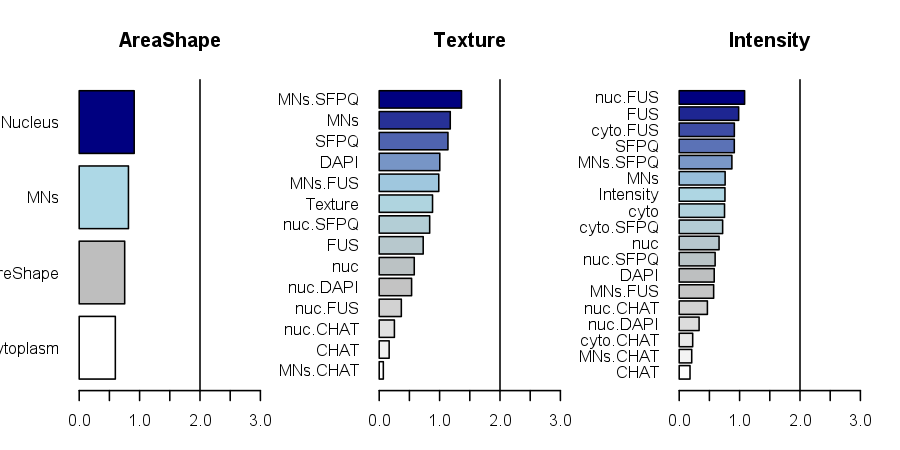

In [207]:
%%R -w 6 -h 3 --units in -r 150  -i relative_feature_importance
par(mfrow=c(1,3),mar=c(4,6,4,4))
pal <- colorRampPalette(c("white","grey", "lightblue","navy"))
#AreaShape
myIX2_shape <- list(grep(mdata$terms,pattern="AreaShape"),
                   intersect(grep(mdata$terms,pattern="AreaShape"),grep(mdata$terms,pattern="MNs")),
                   intersect(grep(mdata$terms,pattern="AreaShape"),grep(mdata$terms,pattern="nuc")),
                   intersect(grep(mdata$terms,pattern="AreaShape"),grep(mdata$terms,pattern="cyto")))
myoutAreShape<- do.call(what=cbind,args=lapply(myIX2_shape,GetPvalsEffectFeatures))
myvec <- -log10(as.numeric(myoutAreShape[2,]))
names(myvec)<-c("AreShape","MNs","Nucleus","Cytoplasm")
barplot(sort(myvec,decreasing=FALSE),beside=TRUE,xlab="-log10(P)",
        las=1,main="AreaShape",horiz=TRUE,xlim=c(0,3),col=pal(length(myvec)))
abline(v=-log10(0.01),col="black",lty=1)



#Texture Analysis
myIX2_texture <- list(grep(mdata$terms,pattern="Texture"),
                   intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="DAPI")),
                   intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="CHAT")),
                   intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="SFPQ")),
                   intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="FUS")),
                   intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="MNs")),
                   intersect(grep(mdata$terms,pattern="MNs"),intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="CHAT"))),
                   intersect(grep(mdata$terms,pattern="MNs"),intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="FUS"))),
                   intersect(grep(mdata$terms,pattern="MNs"),intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="SFPQ"))),
                   intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="nuc")),
                   intersect(grep(mdata$terms,pattern="nuc"),intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="DAPI"))),
                   intersect(grep(mdata$terms,pattern="nuc"),intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="CHAT"))),
                   intersect(grep(mdata$terms,pattern="nuc"),intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="FUS"))),
                   intersect(grep(mdata$terms,pattern="nuc"),intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="SFPQ")))
                    )

myoutTexture<- -log10(do.call(what=rbind,args=lapply(myIX_texture,GetPValsEffectDiff)))
colnames(myoutTexture)<-c("LR","MLP")
myoutTexture<- do.call(what=cbind,args=lapply(myIX2_texture,GetPvalsEffectFeatures))
myvec <- -log10(as.numeric(myoutTexture[2,]))
names(myvec)<-c("Texture","DAPI","CHAT","SFPQ","FUS","MNs","MNs.CHAT","MNs.FUS","MNs.SFPQ","nuc","nuc.DAPI","nuc.CHAT","nuc.FUS","nuc.SFPQ")

barplot(sort(myvec,decreasing=FALSE),beside=TRUE,xlab="-log10(P)",
        las=1,main="Texture",horiz=TRUE,xlim=c(0,3),col=pal(length(myvec)))
abline(v=-log10(0.01),col="black",lty=1)

#Intensity Analysis
myIX2_intensity <- list(grep(mdata$terms,pattern="Intensity"),
                   intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="DAPI")),
                   intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="CHAT")),
                   intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ")),
                   intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="FUS")),
                   intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="MNs")),
                   intersect(grep(mdata$terms,pattern="MNs"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="CHAT"))),
                   intersect(grep(mdata$terms,pattern="MNs"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="FUS"))),
                   intersect(grep(mdata$terms,pattern="MNs"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ"))),
                   intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="nuc")),
                   intersect(grep(mdata$terms,pattern="nuc"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="DAPI"))),
                   intersect(grep(mdata$terms,pattern="nuc"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="CHAT"))),
                   intersect(grep(mdata$terms,pattern="nuc"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="FUS"))),
                   intersect(grep(mdata$terms,pattern="nuc"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ"))),
                   intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="cyto")),
                   intersect(grep(mdata$terms,pattern="cyto"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="CHAT"))),
                   intersect(grep(mdata$terms,pattern="cyto"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="FUS"))),
                   intersect(grep(mdata$terms,pattern="cyto"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ")))
                    )
myoutIntensity<- do.call(what=cbind,args=lapply(myIX2_intensity,GetPvalsEffectFeatures))
myvec <- -log10(as.numeric(myoutIntensity[2,]))
names(myvec)<-c("Intensity","DAPI","CHAT","SFPQ","FUS","MNs","MNs.CHAT","MNs.FUS","MNs.SFPQ","nuc","nuc.DAPI","nuc.CHAT","nuc.FUS","nuc.SFPQ","cyto","cyto.CHAT","cyto.FUS","cyto.SFPQ")
barplot(sort(myvec,decreasing=FALSE),beside=TRUE,xlab="-log10(P)",
        las=1,main="Intensity",horiz=TRUE,xlim=c(0,3),col=pal(length(myvec)))
abline(v=-log10(0.01),col="black",lty=1)

pdf("../Figures/effect_features_LMM_spMN.pdf",pointsize=10,width=9)
par(mfrow=c(3,3),mar=c(4,6,4,4))
myvec <- -log10(as.numeric(myoutAreShape[2,]))
names(myvec)<-c("AreShape","MNs","Nucleus","Cytoplasm")
barplot(sort(myvec,decreasing=FALSE),beside=TRUE,xlab="-log10(P)",
        las=1,main="AreaShape",horiz=TRUE,xlim=c(0,3),col=pal(length(myvec)))
abline(v=-log10(0.01),col="black",lty=1)

myvec <- -log10(as.numeric(myoutTexture[2,]))
names(myvec)<-c("Texture","DAPI","CHAT","SFPQ","FUS","MNs","MNs.CHAT","MNs.FUS","MNs.SFPQ","nuc","nuc.DAPI","nuc.CHAT","nuc.FUS","nuc.SFPQ")
barplot(sort(myvec,decreasing=FALSE),beside=TRUE,xlab="-log10(P)",
        las=1,main="Texture",horiz=TRUE,xlim=c(0,3),col=pal(length(myvec)))
abline(v=-log10(0.01),col="black",lty=1)

myvec <- -log10(as.numeric(myoutIntensity[2,]))
names(myvec)<-c("Intensity","DAPI","CHAT","SFPQ","FUS","MNs","MNs.CHAT","MNs.FUS","MNs.SFPQ","nuc","nuc.DAPI","nuc.CHAT","nuc.FUS","nuc.SFPQ","cyto","cyto.CHAT","cyto.FUS","cyto.SFPQ")
barplot(sort(myvec,decreasing=FALSE),beside=TRUE,xlab="-log10(P)",
        las=1,main="Intensity",horiz=TRUE,xlim=c(0,3),col=pal(length(myvec)))
abline(v=-log10(0.01),col="black",lty=1)

dev.off()


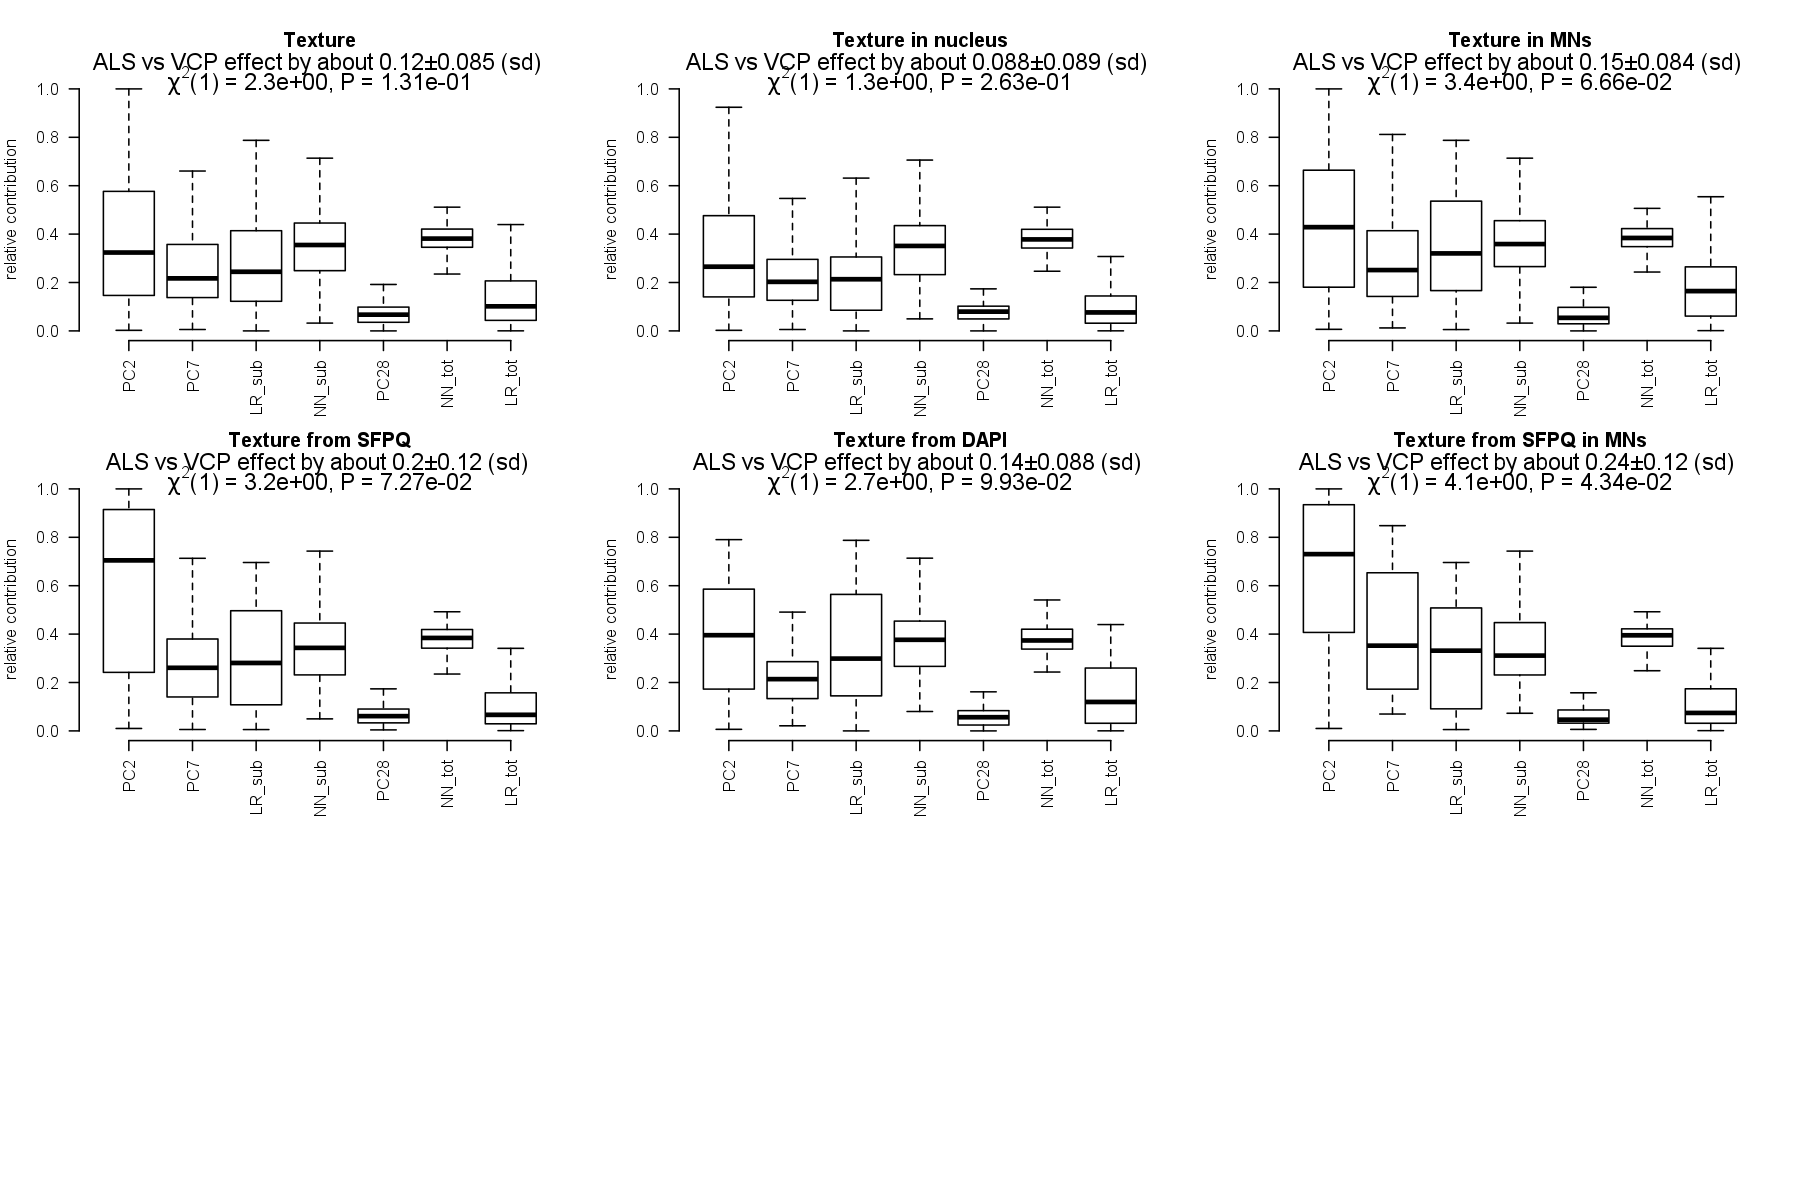

In [208]:
%%R -w 12 -h 8 --units in -r 150 

par(mfrow=c(3,3))
AnalysisEffectFeatures(ix1=grep(mdata$terms,pattern="Texture"),
                       ix2=grep(myterms,pattern="Texture"),
                       mytitle="Texture")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="nuc")),
                       ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="nuc")),
                       mytitle="Texture in nucleus")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="MNs")),
                       ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="MNs")),
                       mytitle="Texture in MNs")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="SFPQ")),
                       ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="SFPQ")),
                       mytitle="Texture from SFPQ")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="DAPI")),
                       ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="DAPI")),
                       mytitle="Texture from DAPI")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="MNs"),intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="SFPQ"))),
                       ix2=intersect(grep(myterms,pattern="MNs"),intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="SFPQ"))),
                       mytitle="Texture from SFPQ in MNs")


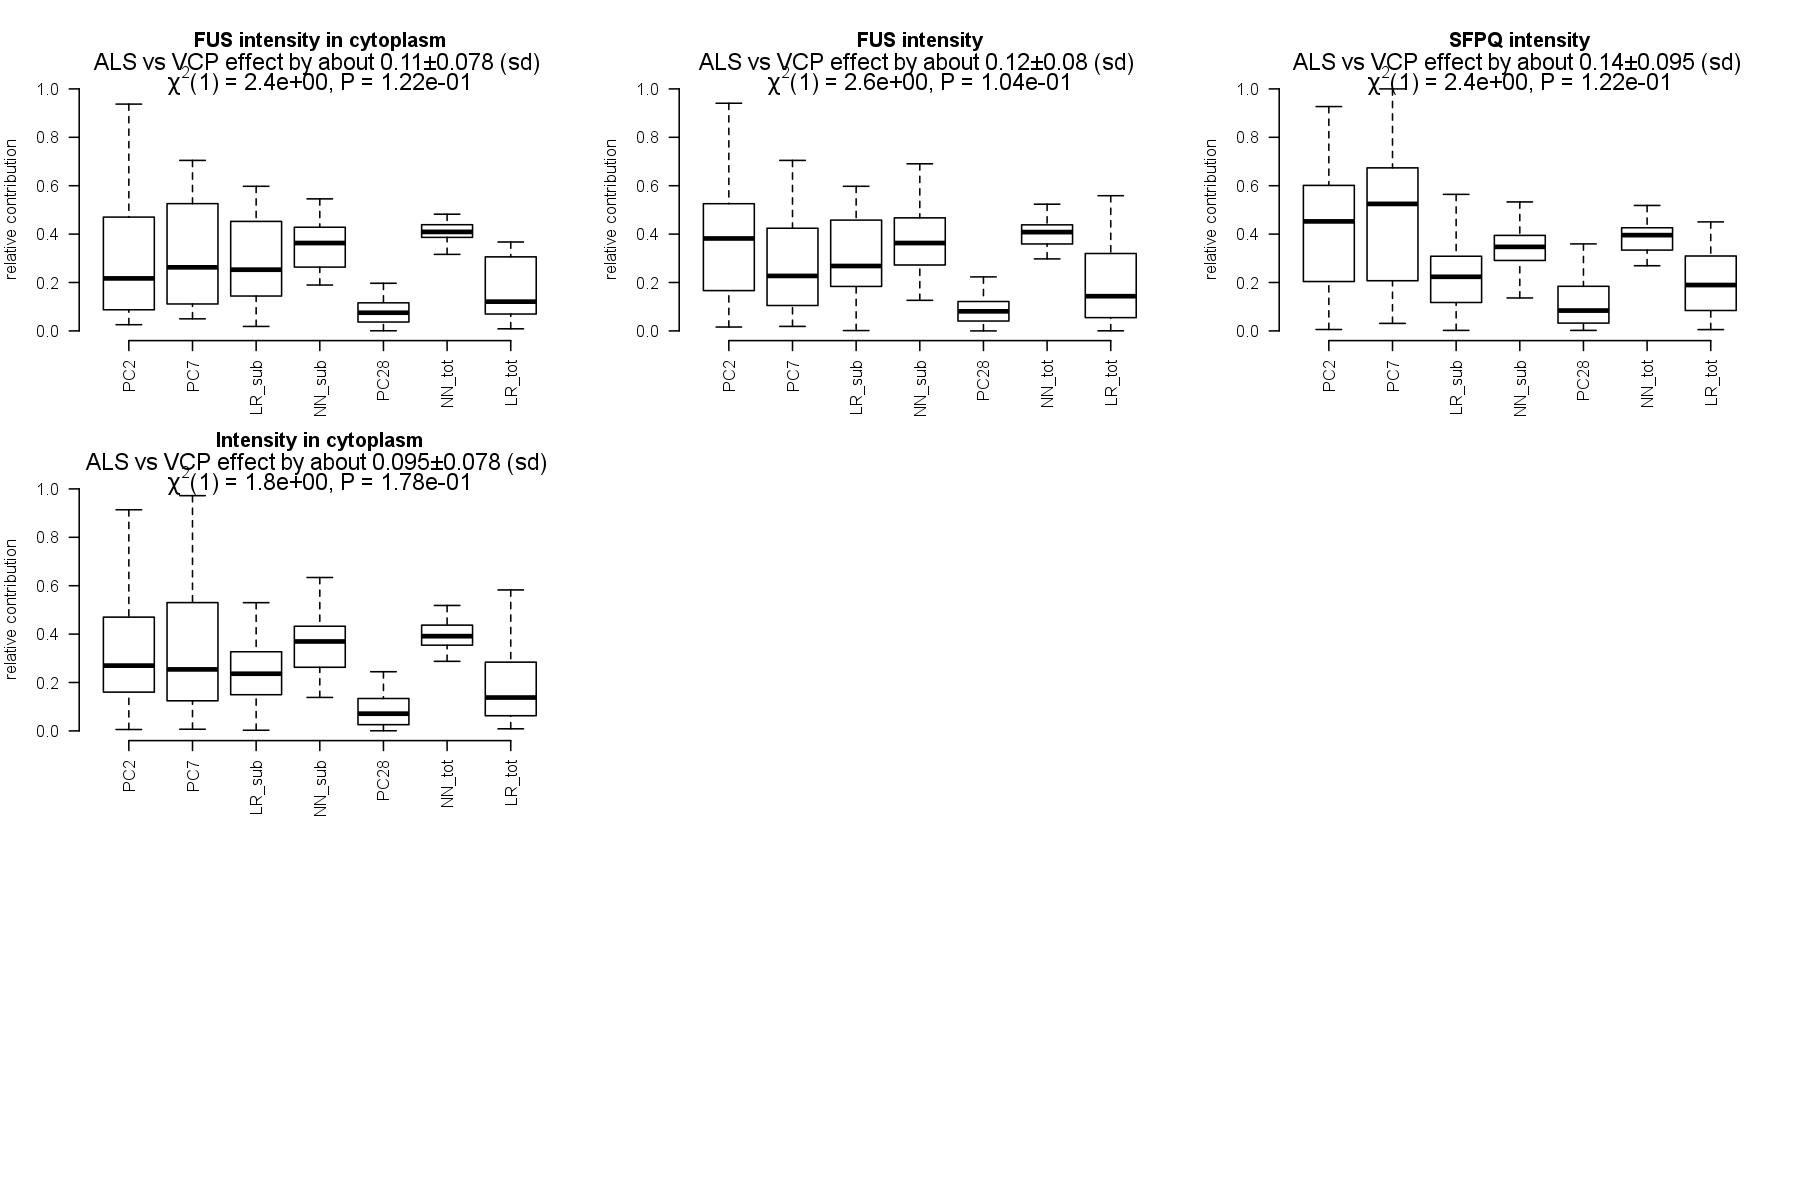

In [209]:
%%R -w 12 -h 8 --units in -r 150
par(mfrow=c(3,3))
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),intersect(grep(mdata$terms,pattern="cyto"),grep(mdata$terms,pattern="FUS"))),
                       ix2=intersect(grep(myterms,pattern="Intensity"),intersect(grep(myterms,pattern="cyto"),grep(myterms,pattern="FUS"))),
                       mytitle="FUS intensity in cytoplasm")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="FUS")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="FUS")),
                       mytitle="FUS intensity")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="SFPQ")),
                       mytitle="SFPQ intensity")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="cyto")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="cyto")),
                       mytitle="Intensity in cytoplasm")




png 
  2 


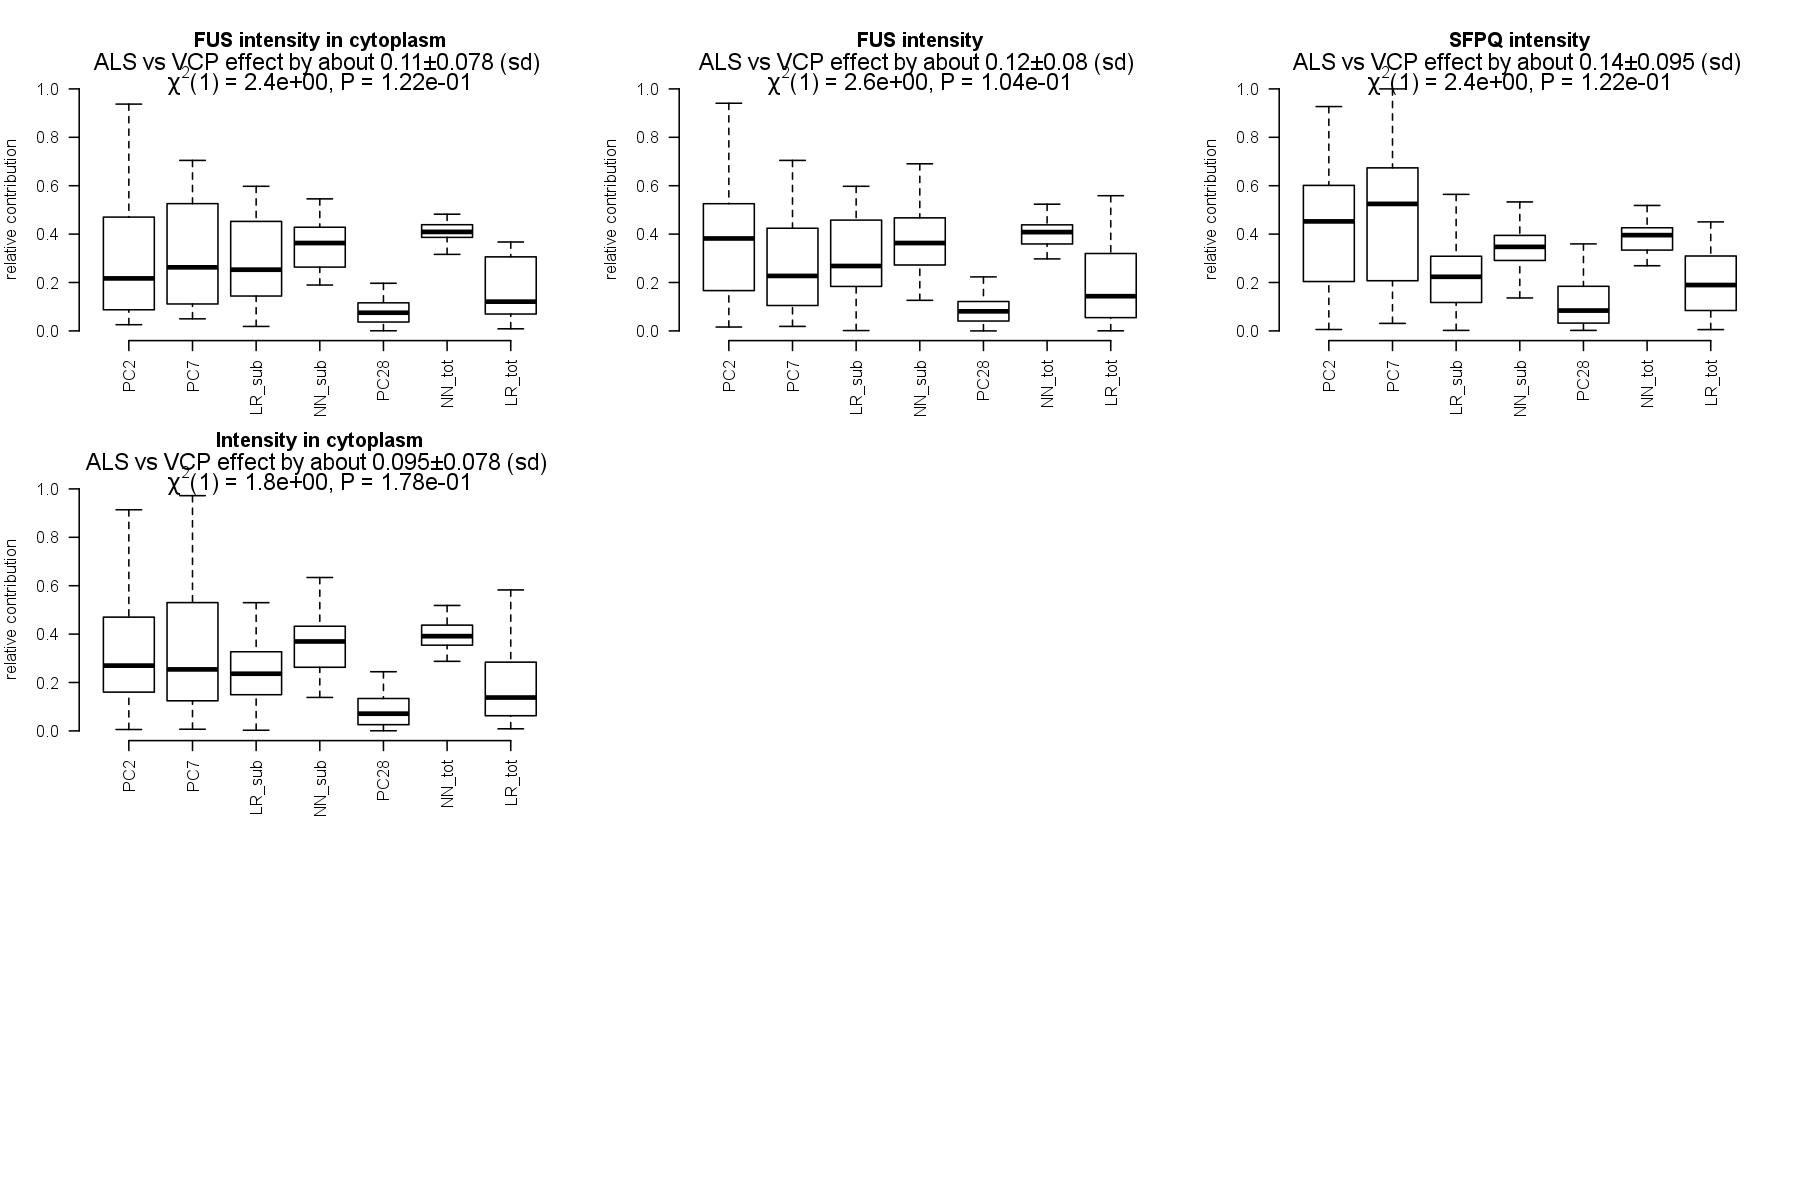

In [210]:
%%R -w 12 -h 8 --units in -r 150
par(mfrow=c(3,3))
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),intersect(grep(mdata$terms,pattern="cyto"),grep(mdata$terms,pattern="FUS"))),
                       ix2=intersect(grep(myterms,pattern="Intensity"),intersect(grep(myterms,pattern="cyto"),grep(myterms,pattern="FUS"))),
                       mytitle="FUS intensity in cytoplasm")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="FUS")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="FUS")),
                       mytitle="FUS intensity")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="SFPQ")),
                       mytitle="SFPQ intensity")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="cyto")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="cyto")),
                       mytitle="Intensity in cytoplasm")


pdf("../Figures/mousedata/effect_intensity_LMM_spMN_new.pdf",pointsize=10,width=9)
par(mfrow=c(3,3))
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),intersect(grep(mdata$terms,pattern="cyto"),grep(mdata$terms,pattern="FUS"))),
                       ix2=intersect(grep(myterms,pattern="Intensity"),intersect(grep(myterms,pattern="cyto"),grep(myterms,pattern="FUS"))),
                       mytitle="FUS intensity in cytoplasm")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="FUS")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="FUS")),
                       mytitle="FUS intensity")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="SFPQ")),
                       mytitle="SFPQ intensity")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="cyto")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="cyto")),
                       mytitle="Intensity in cytoplasm")

dev.off()

png 
  2 


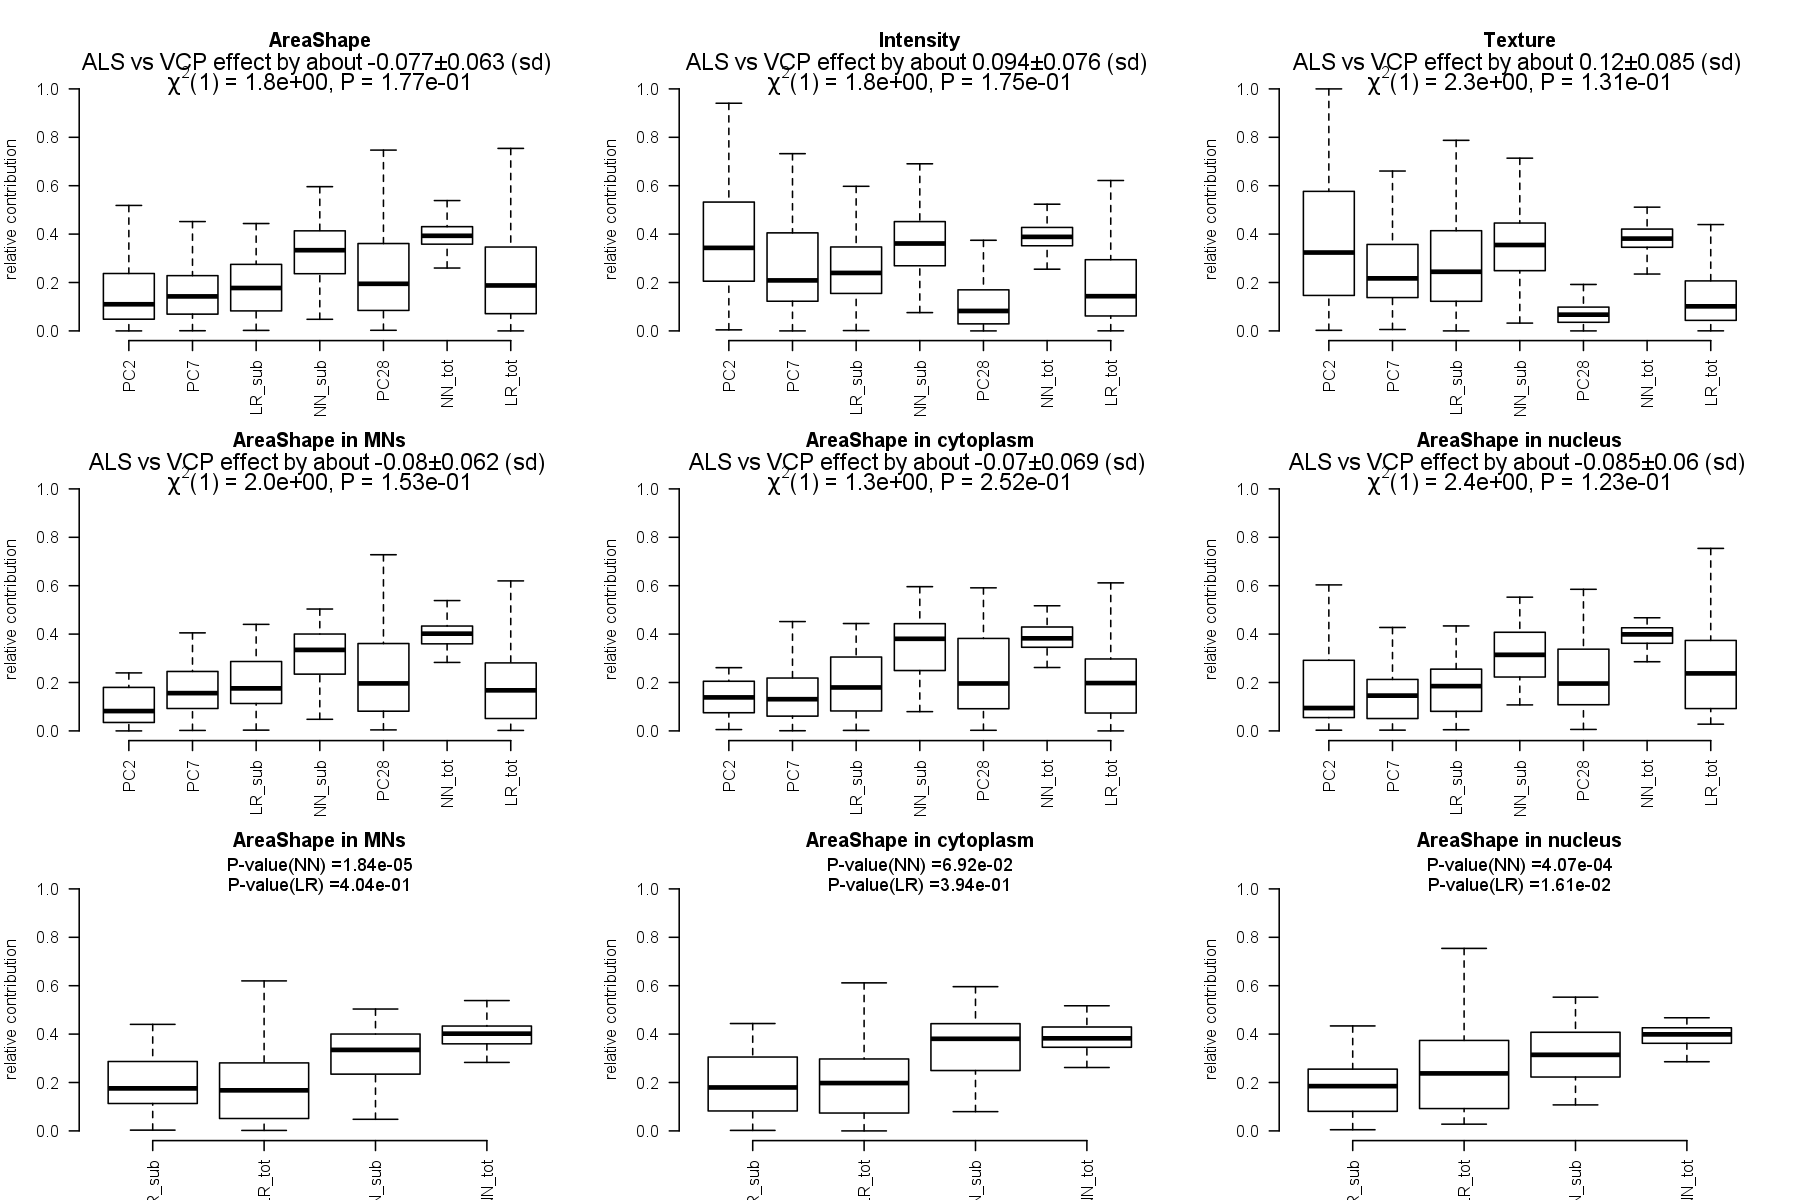

In [211]:
%%R -w 12 -h 8 --units in -r 150 
par(mfrow=c(3,3))
AnalysisEffectFeatures(ix1=grep(mdata$terms,pattern="AreaShape"),
                       ix2=grep(myterms,pattern="AreaShape"),
                       mytitle="AreaShape")

AnalysisEffectFeatures(ix1=grep(mdata$terms,pattern="Intensity"),
                       ix2=grep(myterms,pattern="Intensity"),
                       mytitle="Intensity")


AnalysisEffectFeatures(ix1=grep(mdata$terms,pattern="Texture"),
                       ix2=grep(myterms,pattern="Texture"),
                       mytitle="Texture")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="AreaShape"),grep(mdata$terms,pattern="MNs")),
                       ix2=intersect(grep(myterms,pattern="AreaShape"),grep(myterms,pattern="MNs")),
                       mytitle="AreaShape in MNs")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="AreaShape"),grep(mdata$terms,pattern="cyto")),
                       ix2=intersect(grep(myterms,pattern="AreaShape"),grep(myterms,pattern="cyto")),
                       mytitle="AreaShape in cytoplasm")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="AreaShape"),grep(mdata$terms,pattern="nuc")),
                       ix2=intersect(grep(myterms,pattern="AreaShape"),grep(myterms,pattern="nuc")),
                       mytitle="AreaShape in nucleus")

CompareEffectFeaturesTotSub(ix2=intersect(grep(myterms,pattern="AreaShape"),grep(myterms,pattern="MNs")),mytitle="AreaShape in MNs")
CompareEffectFeaturesTotSub(ix2=intersect(grep(myterms,pattern="AreaShape"),grep(myterms,pattern="cyto"))
                                          ,mytitle="AreaShape in cytoplasm")
CompareEffectFeaturesTotSub(ix2=intersect(grep(myterms,pattern="AreaShape"),grep(myterms,pattern="nuc"))
                                          ,mytitle="AreaShape in nucleus")
                           
                            
pdf("../Figures/mousedata/effect_features_1_spMN_new.pdf",pointsize=10,width=9)
par(mfrow=c(3,3))
AnalysisEffectFeatures(ix1=grep(mdata$terms,pattern="AreaShape"),
                       ix2=grep(myterms,pattern="AreaShape"),
                       mytitle="AreaShape")

AnalysisEffectFeatures(ix1=grep(mdata$terms,pattern="Intensity"),
                       ix2=grep(myterms,pattern="Intensity"),
                       mytitle="Intensity")


AnalysisEffectFeatures(ix1=grep(mdata$terms,pattern="Texture"),
                       ix2=grep(myterms,pattern="Texture"),
                       mytitle="Texture")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="AreaShape"),grep(mdata$terms,pattern="MNs")),
                       ix2=intersect(grep(myterms,pattern="AreaShape"),grep(myterms,pattern="MNs")),
                       mytitle="AreaShape in MNs")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="AreaShape"),grep(mdata$terms,pattern="cyto")),
                       ix2=intersect(grep(myterms,pattern="AreaShape"),grep(myterms,pattern="cyto")),
                       mytitle="AreaShape in cytoplasm")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="AreaShape"),grep(mdata$terms,pattern="nuc")),
                       ix2=intersect(grep(myterms,pattern="AreaShape"),grep(myterms,pattern="nuc")),
                       mytitle="AreaShape in nucleus")

CompareEffectFeaturesTotSub(ix2=intersect(grep(myterms,pattern="AreaShape"),grep(myterms,pattern="MNs")),mytitle="AreaShape in MNs")
CompareEffectFeaturesTotSub(ix2=intersect(grep(myterms,pattern="AreaShape"),grep(myterms,pattern="cyto"))
                                          ,mytitle="AreaShape in cytoplasm")
CompareEffectFeaturesTotSub(ix2=intersect(grep(myterms,pattern="AreaShape"),grep(myterms,pattern="nuc"))
                                          ,mytitle="AreaShape in nucleus")

dev.off()

png 
  2 


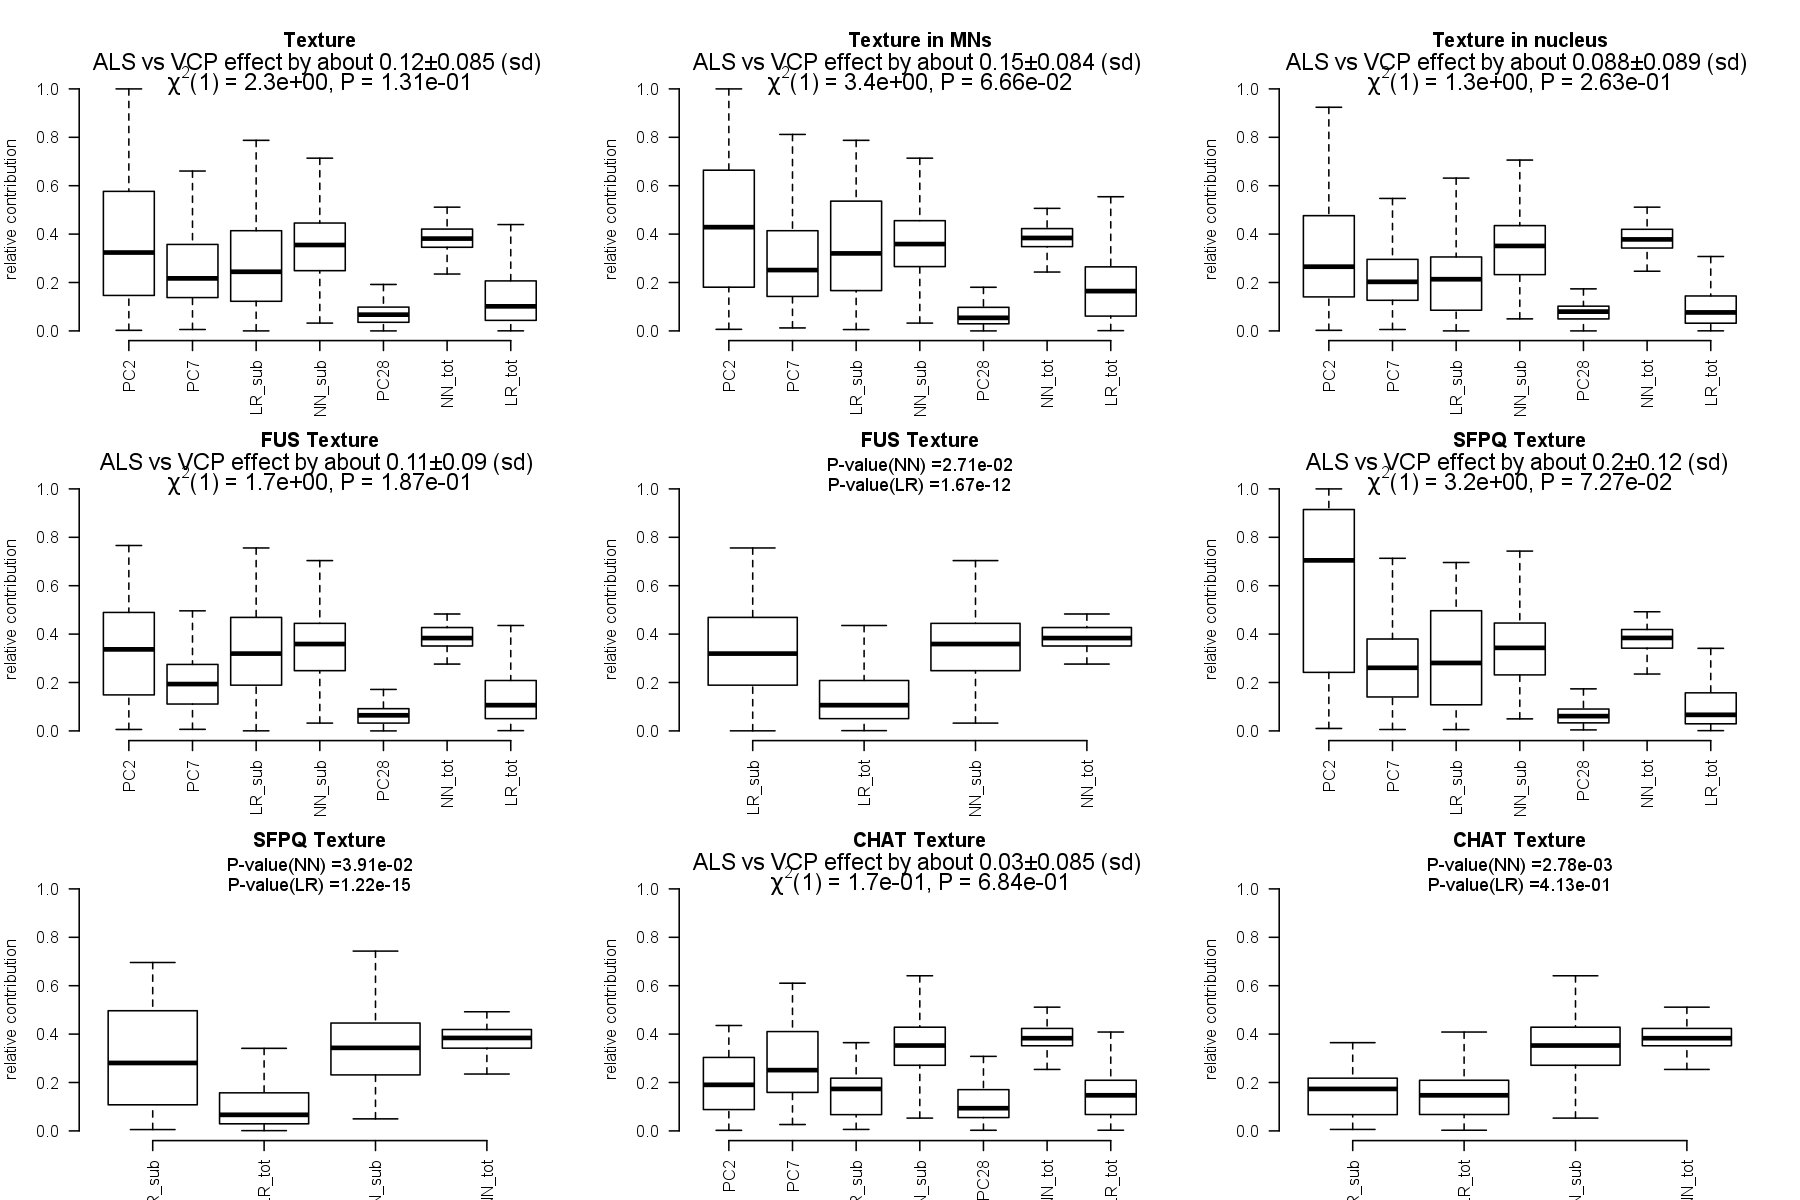

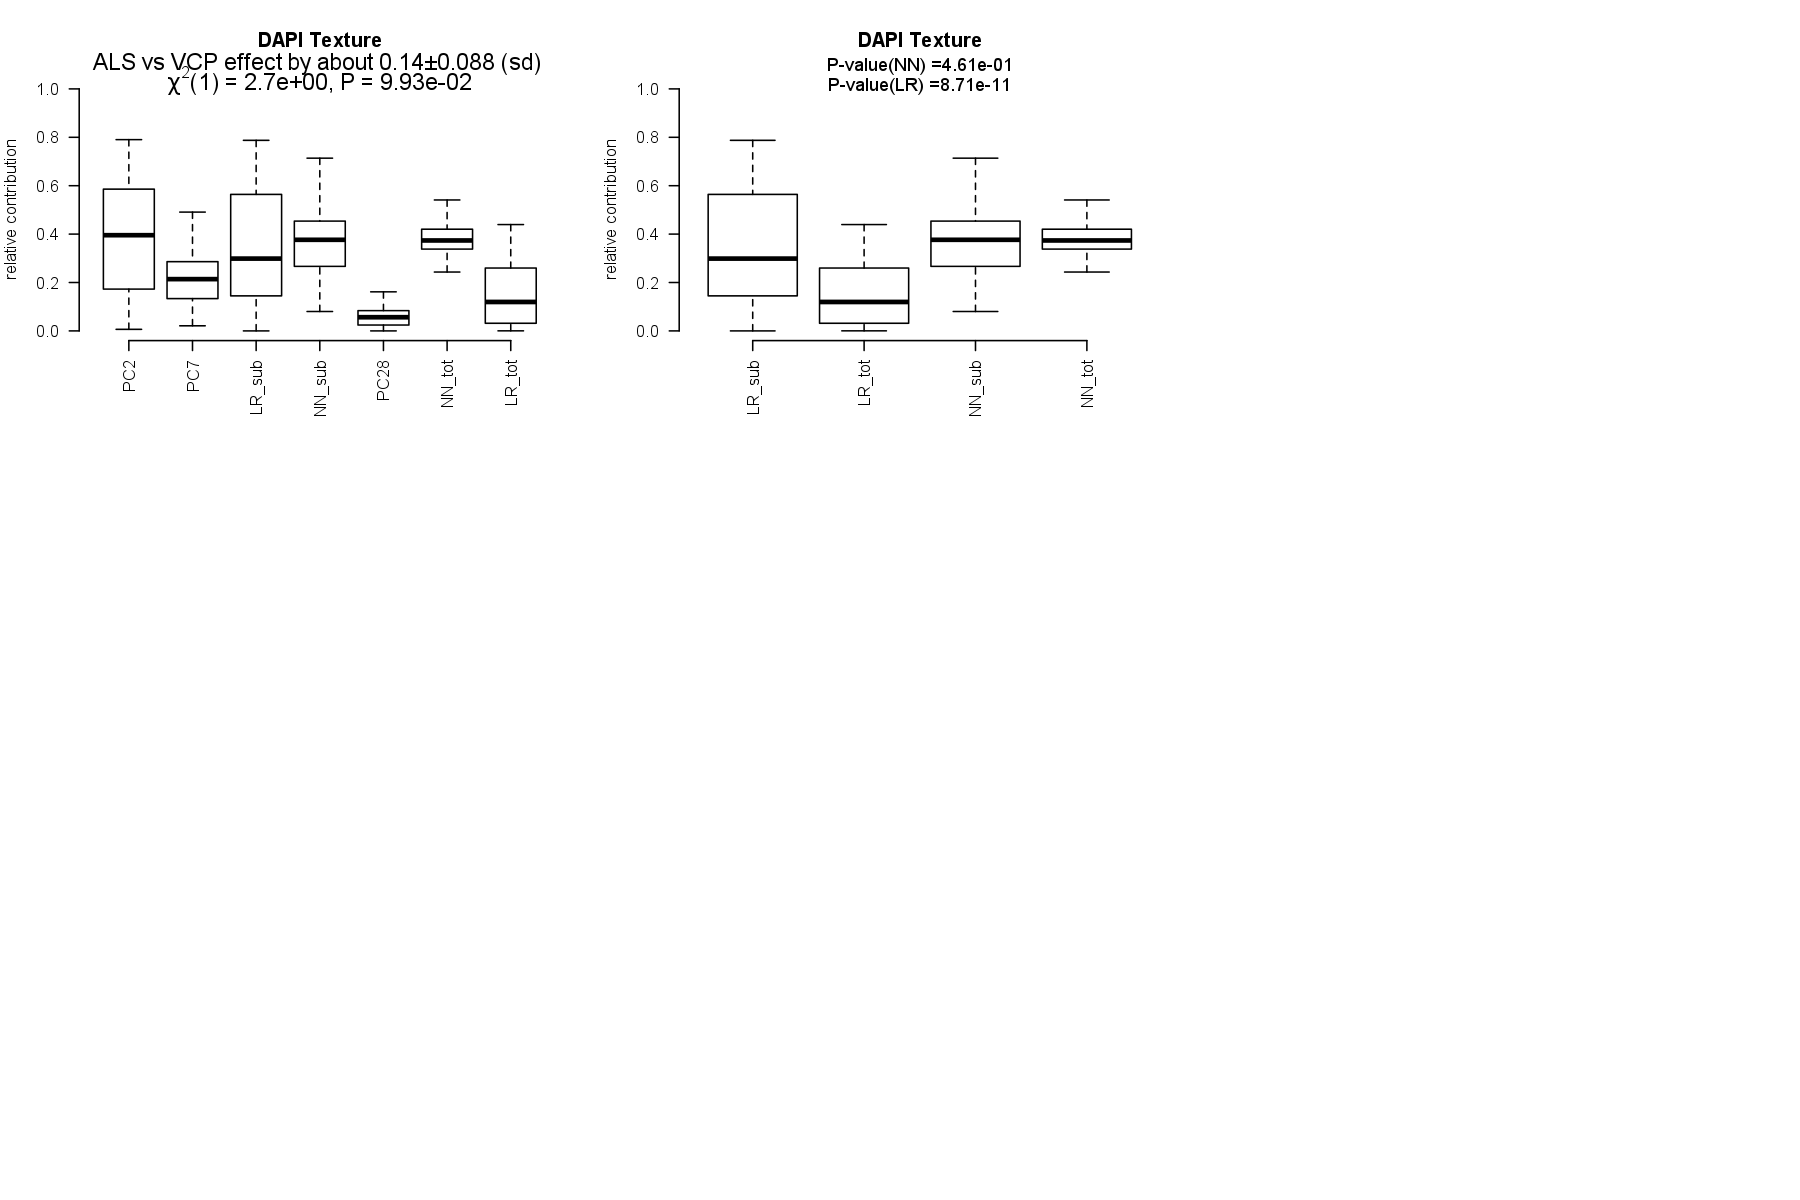

In [212]:
%%R -w 12 -h 8 --units in -r 150 

par(mfrow=c(3,3))
AnalysisEffectFeatures(ix1=grep(mdata$terms,pattern="Texture"),
                       ix2=grep(myterms,pattern="Texture"),
                       mytitle="Texture")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="MNs")),
                       ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="MNs")),
                       mytitle="Texture in MNs")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="nuc")),
                       ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="nuc")),
                       mytitle="Texture in nucleus")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="FUS")),
                       ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="FUS")),
                       mytitle="FUS Texture")


CompareEffectFeaturesTotSub(ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="FUS"))
                                          ,mytitle="FUS Texture")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="SFPQ")),
                       ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="SFPQ")),
                       mytitle="SFPQ Texture")

CompareEffectFeaturesTotSub(ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="SFPQ"))
                                          ,mytitle="SFPQ Texture")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="CHAT")),
                       ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="CHAT")),
                       mytitle="CHAT Texture")

CompareEffectFeaturesTotSub(ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="CHAT"))
                                          ,mytitle="CHAT Texture")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="DAPI")),
                       ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="DAPI")),
                       mytitle="DAPI Texture")

CompareEffectFeaturesTotSub(ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="DAPI"))
                                          ,mytitle="DAPI Texture")

pdf("../Figures/mousedata/effect_features_2_spMN_new.pdf",pointsize=10,width=9)
par(mfrow=c(3,3))
AnalysisEffectFeatures(ix1=grep(mdata$terms,pattern="Texture"),
                       ix2=grep(myterms,pattern="Texture"),
                       mytitle="Texture")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="MNs")),
                       ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="MNs")),
                       mytitle="Texture in MNs")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="nuc")),
                       ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="nuc")),
                       mytitle="Texture in nucleus")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="FUS")),
                       ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="FUS")),
                       mytitle="FUS Texture")


CompareEffectFeaturesTotSub(ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="FUS"))
                                          ,mytitle="FUS Texture")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="SFPQ")),
                       ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="SFPQ")),
                       mytitle="SFPQ Texture")

CompareEffectFeaturesTotSub(ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="SFPQ"))
                                          ,mytitle="SFPQ Texture")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="CHAT")),
                       ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="CHAT")),
                       mytitle="CHAT Texture")

CompareEffectFeaturesTotSub(ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="CHAT"))
                                          ,mytitle="CHAT Texture")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Texture"),grep(mdata$terms,pattern="DAPI")),
                       ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="DAPI")),
                       mytitle="DAPI Texture")

CompareEffectFeaturesTotSub(ix2=intersect(grep(myterms,pattern="Texture"),grep(myterms,pattern="DAPI"))
                                          ,mytitle="DAPI Texture")

dev.off()

png 
  2 


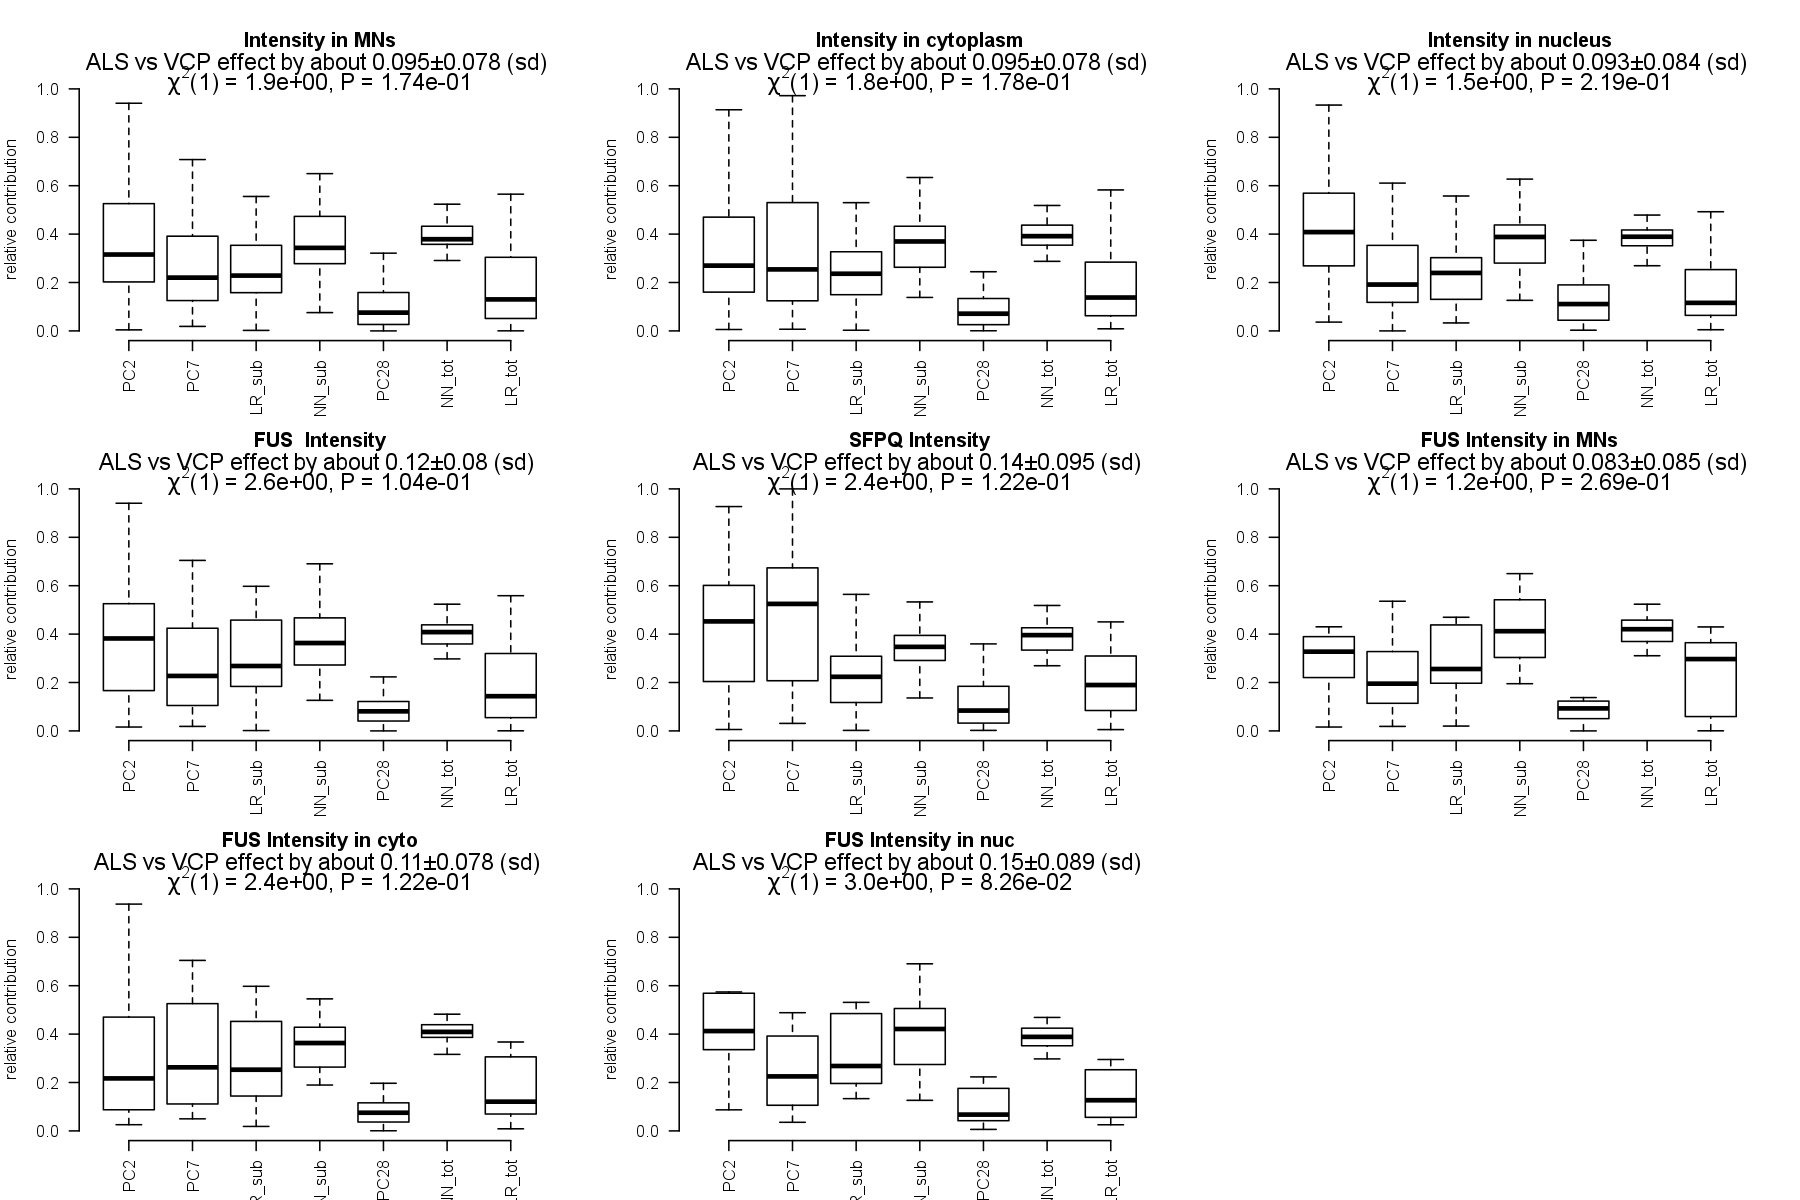

In [213]:
%%R -w 12 -h 8 --units in -r 150 
par(mfrow=c(3,3))


AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="MNs")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="MNs")),
                       mytitle="Intensity in MNs")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="cyto")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="cyto")),
                       mytitle="Intensity in cytoplasm")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="nuc")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="nuc")),
                       mytitle="Intensity in nucleus")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="FUS")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="FUS")),
                       mytitle="FUS  Intensity")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="SFPQ")),
                       mytitle="SFPQ Intensity")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="MNs"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="FUS"))),
                       ix2=intersect(grep(myterms,pattern="MNs"),intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="FUS"))),
                       mytitle="FUS Intensity in MNs")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="cyto"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="FUS"))),
                       ix2=intersect(grep(myterms,pattern="cyto"),intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="FUS"))),
                       mytitle="FUS Intensity in cyto")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="nuc"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="FUS"))),
                       ix2=intersect(grep(myterms,pattern="nuc"),intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="FUS"))),
                       mytitle="FUS Intensity in nuc")

pdf("../Figures/mousedata/effect_features_2_spMN_new.pdf",pointsize=10,width=9)
par(mfrow=c(3,3))


AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="MNs")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="MNs")),
                       mytitle="Intensity in MNs")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="cyto")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="cyto")),
                       mytitle="Intensity in cytoplasm")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="nuc")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="nuc")),
                       mytitle="Intensity in nucleus")


AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="FUS")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="FUS")),
                       mytitle="FUS Intensity")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="SFPQ")),
                       mytitle="SFPQ Intensity")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="MNs"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="FUS"))),
                       ix2=intersect(grep(myterms,pattern="MNs"),intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="FUS"))),
                       mytitle="FUS Intensity in MNs")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="cyto"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="FUS"))),
                       ix2=intersect(grep(myterms,pattern="cyto"),intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="FUS"))),
                       mytitle="FUS Intensity in cyto")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="nuc"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="FUS"))),
                       ix2=intersect(grep(myterms,pattern="nuc"),intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="FUS"))),
                       mytitle="FUS Intensity in nuc")
dev.off()

png 
  2 


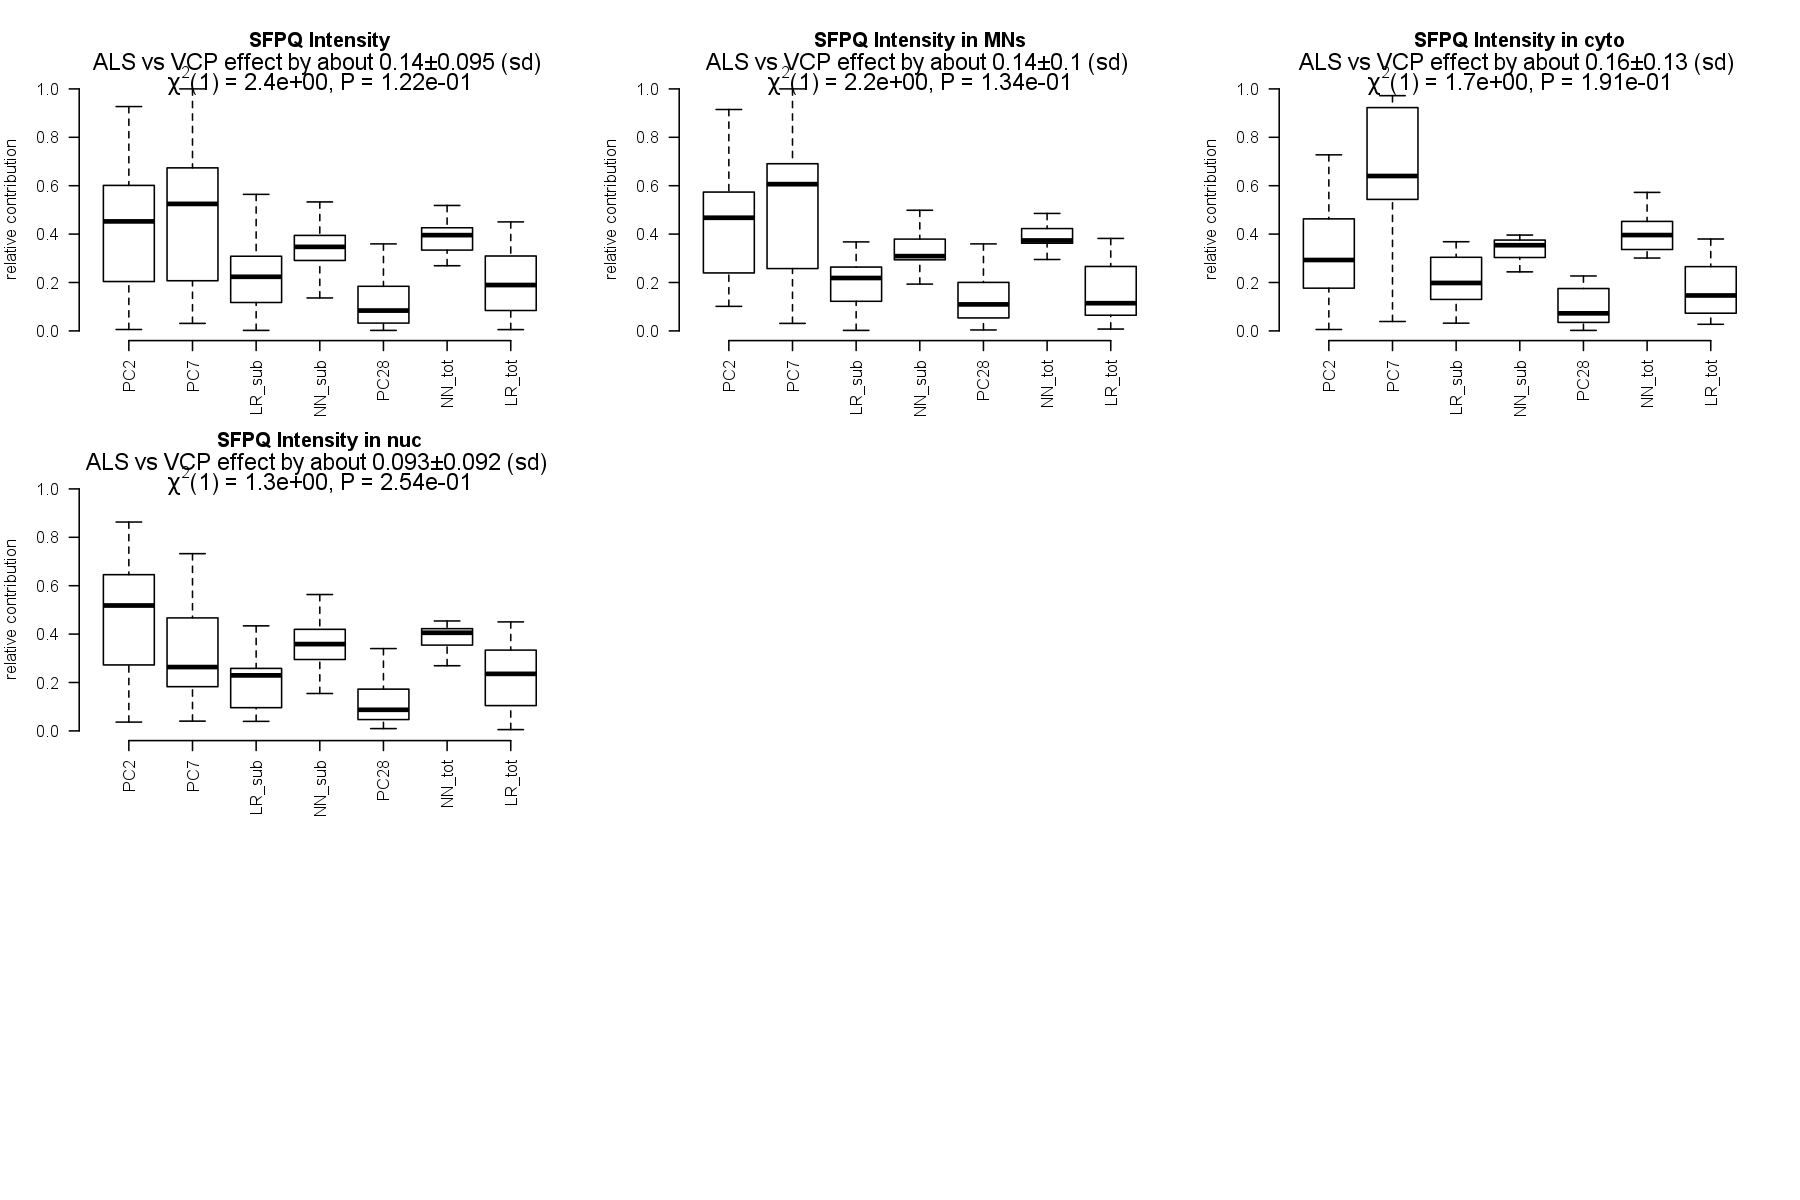

In [214]:
%%R -w 12 -h 8 --units in -r 150 
par(mfrow=c(3,3))

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="SFPQ")),
                       mytitle="SFPQ Intensity")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="MNs"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ"))),
                       ix2=intersect(grep(myterms,pattern="MNs"),intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="SFPQ"))),
                       mytitle="SFPQ Intensity in MNs")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="cyto"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ"))),
                       ix2=intersect(grep(myterms,pattern="cyto"),intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="SFPQ"))),
                       mytitle="SFPQ Intensity in cyto")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="nuc"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ"))),
                       ix2=intersect(grep(myterms,pattern="nuc"),intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="SFPQ"))),
                       mytitle="SFPQ Intensity in nuc")

pdf("../Figures/mousedata/effect_features_3_spMN_new.pdf",pointsize=10,width=9)
par(mfrow=c(3,3))


AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ")),
                       ix2=intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="SFPQ")),
                       mytitle="SFPQ Intensity")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="MNs"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ"))),
                       ix2=intersect(grep(myterms,pattern="MNs"),intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="SFPQ"))),
                       mytitle="SFPQ Intensity in MNs")
AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="cyto"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ"))),
                       ix2=intersect(grep(myterms,pattern="cyto"),intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="SFPQ"))),
                       mytitle="SFPQ Intensity in cyto")

AnalysisEffectFeatures(ix1=intersect(grep(mdata$terms,pattern="nuc"),intersect(grep(mdata$terms,pattern="Intensity"),grep(mdata$terms,pattern="SFPQ"))),
                       ix2=intersect(grep(myterms,pattern="nuc"),intersect(grep(myterms,pattern="Intensity"),grep(myterms,pattern="SFPQ"))),
                       mytitle="SFPQ Intensity in nuc")
dev.off()

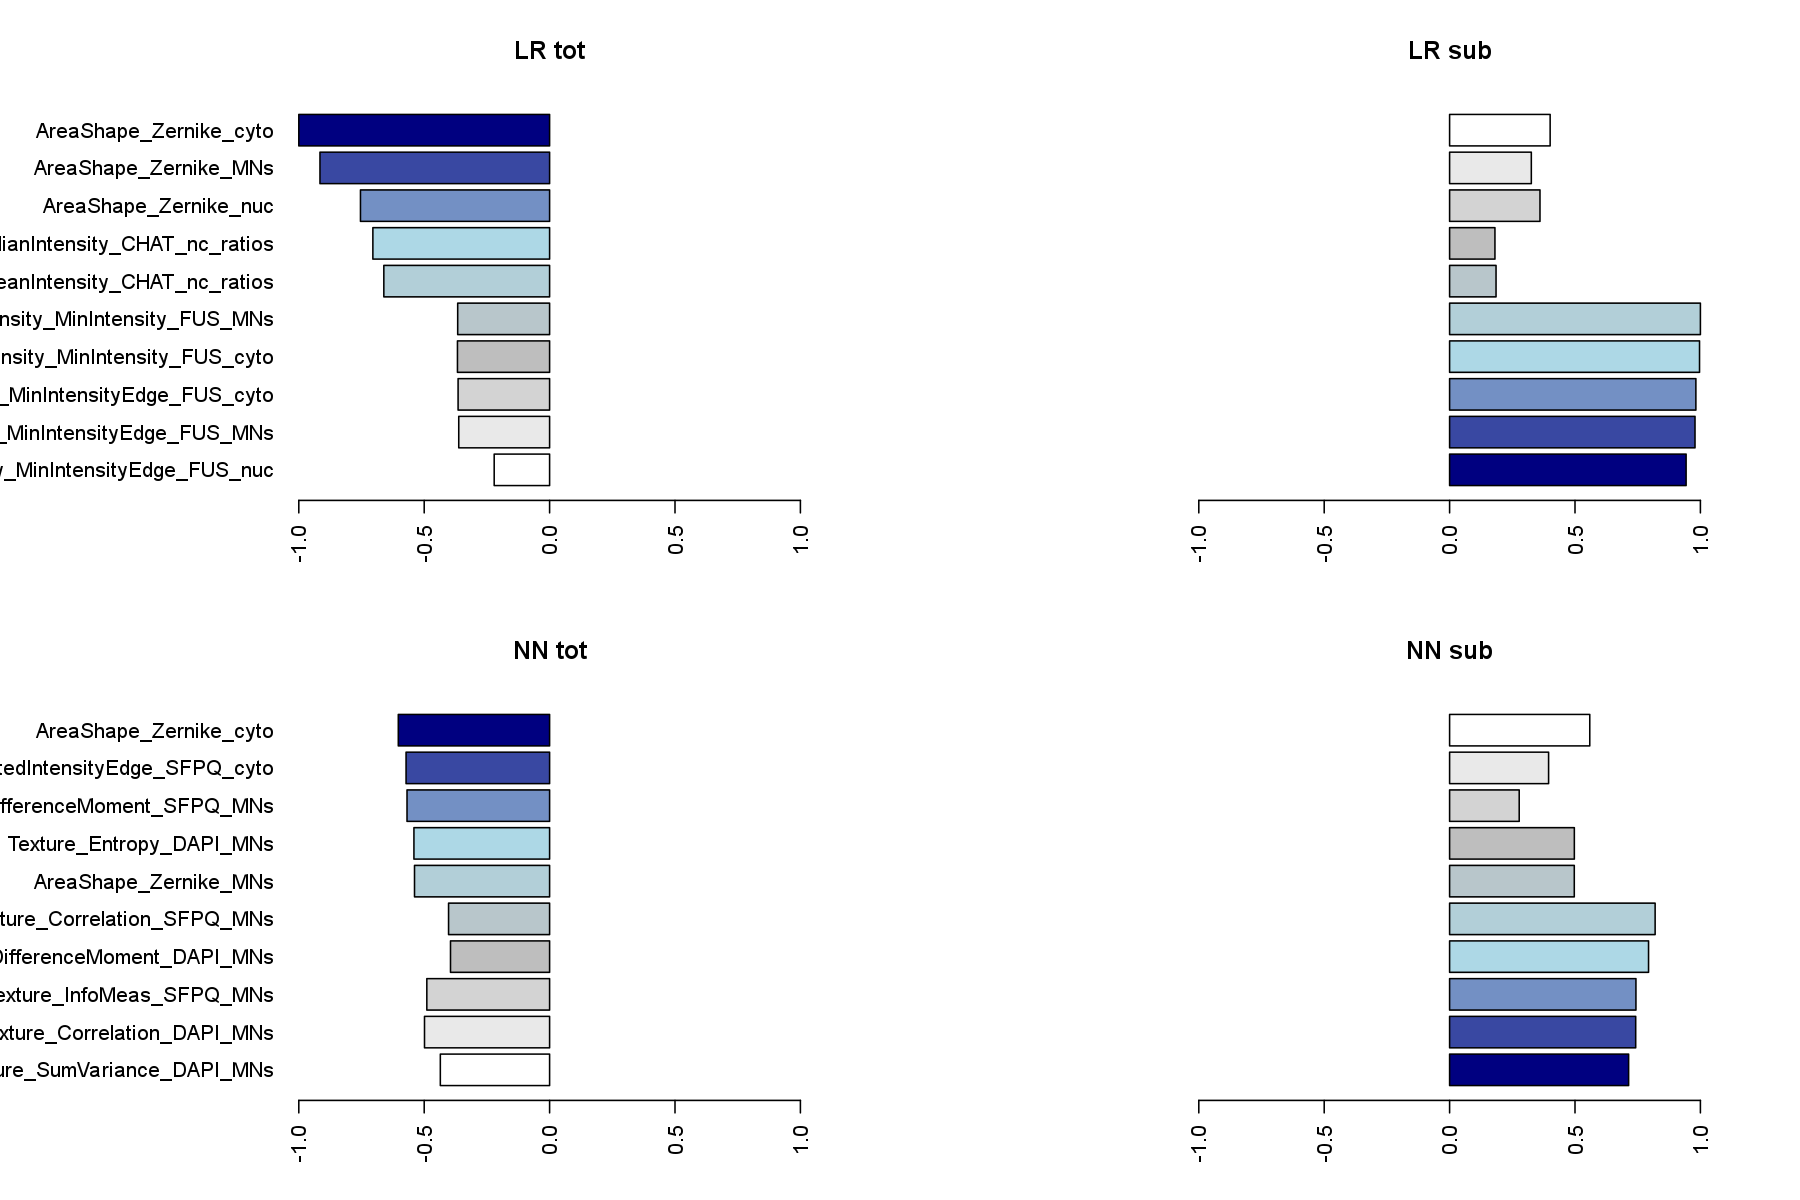

In [215]:
%%R -w 12 -h 8 --units in -r 150  -i relative_feature_importance -o mytop_contributions
myterms <- as.character(rownames(relative_feature_importance))
myterms <- gsub('[[:digit:]]+', '', myterms)
myterms <- gsub('__', '', myterms)

mytop_contributions <- do.call(args=lapply(c(1:ncol(relative_feature_importance)),function(IX){
    myorder <- sort(relative_feature_importance[,IX],index.return=TRUE,decreasing=TRUE)$ix
    myout   <- data.frame(terms=myterms[myorder],contribution=relative_feature_importance[myorder,IX])
    colnames(myout)<- paste(colnames(relative_feature_importance)[IX],colnames(myout),sep=".")
    return(myout[!duplicated(myout[,1]),])
}),what=cbind)

par(mfrow=c(2,2),mar=c(4,12,4,4))
termsoi <- unique(c(as.character(mytop_contributions$LR_tot.terms[c(1:5)]),as.character(mytop_contributions$LR_sub.terms[c(1:5)])))
myvec=mytop_contributions$LR_tot.contribution[match(termsoi,mytop_contributions$LR_tot.terms)]
names(myvec)<- termsoi
barplot(-rev(myvec),horiz=TRUE,xlim=c(-1,1),las=2,col=pal(length(myvec)),main="LR tot")
myvec=mytop_contributions$LR_sub.contribution[match(termsoi,mytop_contributions$LR_sub.terms)]
barplot(rev(myvec),horiz=TRUE,xlim=c(-1,1),las=2,col=rev(pal(length(myvec))),main="LR sub")

termsoi <- unique(c(as.character(mytop_contributions$NN_tot.terms[c(1:5)]),as.character(mytop_contributions$NN_sub.terms[c(1:5)])))
myvec=mytop_contributions$NN_tot.contribution[match(termsoi,mytop_contributions$NN_tot.terms)]
names(myvec)<- termsoi
barplot(-rev(myvec),horiz=TRUE,xlim=c(-1,1),las=2,col=pal(length(myvec)),main="NN tot")
myvec=mytop_contributions$NN_sub.contribution[match(termsoi,mytop_contributions$NN_sub.terms)]
barplot(rev(myvec),horiz=TRUE,xlim=c(-1,1),las=2,col=rev(pal(length(myvec))),main="NN sub")

